#>CONFIGURAÇÃO DO AMBIENTE

In [4]:
###INSTALAÇÃO DE MÓDULOS ADICIONAIS
##! pip install mlxtend
#! pip install xlrd
#! pip install graphviz

In [5]:
from google.colab import data_table
from google.colab import files
from google.colab import drive

data_table.enable_dataframe_formatter()

In [99]:
#IMPORTAÇÃO DE BIBLIOTECAS
import pandas as pd
import re
import seaborn as sb
import numpy as np
import nltk
import warnings
import matplotlib.pyplot as plt
from collections import Counter

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

#bibliotecas ml
from sklearn import datasets, tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, r2_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

#biblioteca de modelos
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

#>IMPORTAÇÃO DE DADOS

####DEFEITOS EM PLACAS

In [7]:
##importanto e realizando pre tratamento na base

drive.mount('/content/drive', force_remount=True)
raw_placas = pd.read_csv('/content/drive/My Drive/PUC-PROJETO/SLAB-DATA/placas-defeitos-2021.csv')

##SINTIZA EVENTOS DE DEFEITOS EM PLACAS
raw_placas['DEFECT_CD']=raw_placas['DEFECT_CD'].replace(to_replace=["||||||||||||"], value=np.nan)
raw_placas['Defeitos'] = np.where(pd.isnull(raw_placas['DEFECT_CD']), False, True)

raw_placas.head()

Mounted at /content/drive


,DEFECT_CD,SLAB_NO,ORD_NO,ORD_ITEM,HEAT_NO,DATA_INSPECAO,FASE,Defeitos
0,NaN,A039267091,2840,70,A039267,01/01/21 00:14:32..4490620,INSP. PRIMARIA,False
1,NaN,A039267591,2840,70,A039267,01/01/21 00:14:32..5692690,INSP. PRIMARIA,False
2,NaN,A039268011,2840,60,A039268,01/01/21 00:28:30..6155180,INSP. PRIMARIA,False
3,NaN,A039268021,2840,60,A039268,01/01/21 00:28:30..8018630,INSP. PRIMARIA,False
4,NaN,A039268511,2840,60,A039268,01/01/21 00:28:30..9206060,INSP. PRIMARIA,False


####CORRIDAS

In [ ]:
drive.mount('/content/drive', force_remount=True)
raw_corridas = pd.read_csv('/content/drive/My Drive/PUC-PROJETO/SLAB-DATA/placas-corridas-2021.csv')

raw_corridas.set_index('SLAB_NO')
raw_corridas['HEAT'] = raw_corridas['SLAB_NO'].str.slice(0,7)
raw_corridas.fillna (value=0, inplace=True)
raw_corridas.head()

####EVENTOS DE QUALIDADE

In [9]:
drive.mount('/content/drive', force_remount=True)
raw_evento_qualidade = pd.read_csv('/content/drive/My Drive/PUC-PROJETO/SLAB-DATA/placas-qe-2021.csv')

raw_evento_qualidade.set_index('SLAB_NO')
raw_evento_qualidade.fillna(value='NoEvent', inplace=True)

eq_pivot = raw_evento_qualidade.pivot (index='SLAB_NO', columns='QLTY_TRK_CD', values='QLTY_TRK_RSLT')
eq_pivot.reset_index (inplace=True)
eq_pivot.fillna (value=0, inplace=True)

del(raw_evento_qualidade)
print(type(eq_pivot))
eq_pivot.set_index('SLAB_NO')
eq_pivot.head()

Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>


QLTY_TRK_CD,SLAB_NO,NoEvent,S100,S101,S102,S103,S104,S105,S106,S107,S108,S109,S111,S113,S122,S123,S125,S126,S127,S128,S129,S130,S131,S134,S135,S136,S137,S138,S141,S142,S143,S144,S145,S146,S147,S148,S149,S150,S152,S155,S156,S158,S159,S161,S162,S163
0,A039267091,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,A039267591,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,A039268011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,A039268021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A039268031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


####PROGRAMAÇÃO DE CORRIDAS

In [10]:
drive.mount('/content/drive', force_remount=True)
raw_schedule_placas = pd.read_csv('/content/drive/My Drive/PUC-PROJETO/SLAB-DATA/placas_programacao_2021.csv')

raw_schedule_placas.set_index('SLAB_NO')
raw_schedule_placas.head()

Mounted at /content/drive


,SLAB_NO,SPEC_CD,PLAN_SLAB_THK,PLAN_SLAB_WTH,PLAN_SLAB_STA_WTH,PLAN_SLAB_END_WTH,PLAN_SLAB_WGT,SCARF_TY,UST_YN,SMPING_TY,TAPER_TY,STR_NO,MIXED_TY,COOLING_TY,SHORT_SLAB_TY,HEAT_SEQ_POSITION,PLAN_SECOND_RFN_CD,PLAN_DE_P_YN,PLAN_HEAT_WGT,PLAN_WTH_CHANGE_YN,PLAN_TUDISH_CHG_FL
0,A039267091,SAE1006,250,1520,1520,1520,18.225,NaN,NaN,NaN,NaN,1,NaN,A,NaN,0.32,2A,N,309.825,N,N
1,A039267591,SAE1006,250,1520,1520,1520,18.225,NaN,NaN,NaN,NaN,2,NaN,A,NaN,0.32,2A,N,309.825,N,N
2,A039268011,SAE1006,250,1520,1520,1520,15.062,NaN,NaN,NaN,NaN,1,NaN,A,NaN,0.36,2A,N,301.240,N,N
3,A039268021,SAE1006,250,1520,1520,1520,15.062,NaN,NaN,NaN,NaN,1,NaN,A,NaN,0.36,2A,N,301.240,N,N
4,A039268031,SAE1006,250,1520,1520,1520,15.062,NaN,NaN,NaN,NaN,1,NaN,A,NaN,0.36,2A,N,301.240,N,N


####RESULTADOS DE LINGOTAMENTO

In [11]:
drive.mount('/content/drive', force_remount=True)
casting_result_placas1 = pd.read_csv('/content/drive/My Drive/PUC-PROJETO/SLAB-DATA/placas_resultado_lingotamento_2021-COMPLETO1.csv')
casting_result_placas2 = pd.read_csv('/content/drive/My Drive/PUC-PROJETO/SLAB-DATA/placas_resultado_lingotamento_2021-COMPLETO2.csv')

casting_result_placas = casting_result_placas1.join(casting_result_placas2.set_index('SLAB_NO')) 
casting_result_placas.reset_index()
casting_result_placas.sort_values(by='SLAB_NO')
casting_result_placas.head()

Mounted at /content/drive


,SLAB_NO,PLAN_CUT_SLAB_NO,PROC_MC_NO,cc_STR_NO,MIXD_SLAB_HEAT_NO,CAST_IN_LD_STEEL_WGT,TD_STEEL_SUPERH_DGR,CUT_SLAB_THK,CUT_SLAB_WTH,CUT_SLAB_LTH,CUT_SLAB_WGT,CUT_SLAB_CONN_LTH,SLAB_CUT_POSIT_CD,ORD_NO,ORD_ITEM,CC_TAPER_TY,CUT_SLAB_STA_WTH,CUT_SLAB_END_WTH,MLD_TAPR_RGT_CHG_VAL,MLD_TAPR_LFT_CHG_VAL,RGT_MD_TAPR_RATE,LFT_MD_TAPR_RATE,TD_AVG_TEMP,TD_STEEL_WGT,TD_SLID_NZ_MAX_OPEN,TD_SLID_NZ_MIN_OPEN,TD_SLID_GATE_OPEN_QTY,TD_SLID_NZ_OPEN_VAR_RATE,MLD_WIDE_IS_CW_TEMP_DIFF,MLD_WIDE_OS_CW_TEMP_DIFF,MLD_NARW_LFT_CW_TEMP_DIFF,MLD_NARW_RGT_CW_TEMP_DIFF,MLD_OSCILL_GAP,CAST_MIN_SPD,CAST_MAX_SPD,CAST_AVG_SPD,CAST_IN_CAST_SPD_CHG_VAL,MLAC_SCAN_TOT_CNT,MLAC_3MM_OVER_CNT,MLAC_5MM_OVER_CNT,MLAC_10MM_OVER_CNT,MLAC_20MM_OVER_CNT,SH_NZ_DIP_MAX_DEPTH,SH_NZ_DIP_MIN_DEPTH,SH_NZ_DIP_AVG_DEPTH,SN_SETTLE_MIN_DEPTH,SN_SETTLE_MAX_DEPTH,SN_SETTLE_AVG_DEPTH,SH_NZ_AR_FLW_MIN,SH_NZ_AR_FLW_MAX,SH_NZ_AR_PRS_MIN,SH_NZ_AR_PRS_MAX,TD_UP_NZ_AR_FLW_MAX,TD_UP_NZ_AR_FLW_MIN,TD_UP_NZ_AR_FLW_AVG,UP_PLT_AR_FLW_MAX,UP_PLT_AR_FLW_MIN,ENTRY_CW_TEMP,SOFT_PRS_TY,SOFT_PRS_ENTRY_THK,SOFT_PRS_EXIT_THK,SOFT_PRS_PRS_DN_VAL,SOFT_PRS_ZONE_CNT,LD_SN_RP_CAST_HEAD_POSIT,LD_OPEN_PUR_STA_CAST_HPOSIT,LD_OPEN_PUR_END_CAST_HPOSIT,LD_EXCHG_SN_DIP_DEPTH,LASER_MSU_TAIL_WTH,LASER_MSU_HEAD_WTH,LASER_MSU_MID_WTH,LST_SLAB_YN,CUT_SLAB_LTH_CONT_RATE,CUT_SLAB_WTH_CONT_RATE,CUT_SLAB_HEAD_MLD_PASS_DTM,CUT_SLAB_TAIL_MLD_PASS_DTM,MLD_MAX_CHG_CAST_SPD,MLD_MAX_CAST_SPD_CHG_POSIT,MLD_LEVEL_MAX_HUNT_AMT,MLD_LEVEL_MAX_HUNT_POSIT,BY_PLAN_YN,SEN_EXCHANGE_FLAG,TAPPER_SLAB_FLAG,MLD_LEVEL_AUTO_MODE,MLAC_50MM_OVER_CNT,MLD_SURF_VORTEX_YN,TCM_CUT_MODE
0,A039267091,P046277091,1,1,NaN,237.5,29.0,250,1529,6053,18.163,0.0,Y,2840,70,N,1529,1529,0.0,0.0,1.07,1.10,1559.0,60.0,90.0,88.0,89.0,0.02,5.5,5.3,7.1,6.8,7.4,1.31,1.35,1.34,0.18,176.0,13.0,1.0,0.0,0.0,214.0,7.0,188.0,171.0,176.0,174.0,149.7,150.0,149.2,150.0,20.0,20.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A039267591,P046277581,1,2,A039268,283.5,29.0,250,1529,6050,18.154,5516.0,K,2840,70,N,1529,1529,0.0,0.0,1.09,1.09,1559.0,64.0,84.0,79.0,81.0,0.05,4.5,4.6,6.4,6.2,6.1,1.35,1.35,1.35,0.00,195.0,0.0,0.0,0.0,0.0,235.0,224.0,229.0,173.0,176.0,174.0,149.8,150.0,149.8,150.0,20.0,20.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,A039268011,P046278011,1,1,A039267,205.6,24.0,250,1529,5001,15.006,493.0,K,2840,60,N,1529,1529,0.0,0.0,1.07,1.10,1554.0,64.0,91.0,89.0,90.0,0.02,5.7,5.5,7.3,7.1,7.4,1.35,1.35,1.35,0.00,146.0,5.0,0.0,0.0,0.0,235.0,86.0,153.0,173.0,177.0,174.0,149.8,150.0,149.9,150.0,20.0,20.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,A039268021,P046278021,1,1,NaN,174.0,24.0,250,1529,5001,15.006,0.0,L,2840,60,N,1529,1529,0.0,0.0,1.07,1.10,1554.0,64.0,91.0,89.0,90.0,0.02,5.7,5.4,7.5,7.1,7.4,1.35,1.35,1.35,0.00,143.0,4.0,0.0,0.0,0.0,235.0,222.0,227.0,171.0,176.0,174.0,149.8,150.0,149.9,150.0,20.0,20.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,A039268031,P046278031,1,1,NaN,142.3,24.0,250,1529,5003,15.012,0.0,N,2840,60,N,1529,1529,0.0,0.0,1.07,1.10,1554.0,64.0,90.0,89.0,89.0,0.01,5.7,5.4,7.4,7.1,7.4,1.35,1.35,1.35,0.00,147.0,12.0,1.0,0.0,0.0,234.0,219.0,228.0,172.0,176.0,174.0,149.8,150.0,149.8,150.0,20.0,20.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


####COMPOSIÇÃO QUIMICA

In [12]:
#obtendo os dados de resultados quimicos e especificação quimica das bases csv Google Drive
drive.mount('/content/drive', force_remount=True)
raw_chem_heat_result = pd.read_csv('/content/drive/My Drive/PUC-PROJETO/SLAB-DATA/Resultado_Quimico_Corridas_2021.csv')
raw_chem_heat_result.reset_index()
raw_chem_heat_result.sort_values(by='HEAT')

#tratando somente dados da amostra final de corrida
raw_chem_heat_result = raw_chem_heat_result[(raw_chem_heat_result['AMOSTRA'].str.contains('PDA1417101'))]

#analisando saida dos dados de resultados quimicos
raw_chem_heat_result.head()


Mounted at /content/drive


,HEAT,AMOSTRA,ELEMENTO,RESULTADO
48,A039267,PDA1417101,V04,0.0140
49,A039267,PDA1417101,V36,0.0038
50,A039267,PDA1417101,V02,0.0140
51,A039267,PDA1417101,V03,0.2030
52,A039267,PDA1417101,V05,0.0063


In [13]:
#obtendo os dados de especificações quimicas das bases csv Google Drive
raw_chem_heat_spec = pd.read_csv('/content/drive/My Drive/PUC-PROJETO/SLAB-DATA/Espec_Quimico_Corridas_2021.csv')
raw_chem_heat_spec.reset_index()
raw_chem_heat_spec.sort_values(by='HEAT')

raw_chem_heat_spec["MIN_VAL"] = raw_chem_heat_spec["MIN_VAL"].fillna(0)

#analisando saida dos dados de especificação quimica
raw_chem_heat_spec.head()


,HEAT,ELEMENTO,TGT_VAL,MIN_VAL,MAX_VAL
0,A039267,V01,0.04,0.03,0.060
1,A039267,V02,0.00,0.00,0.030
2,A039267,V03,0.18,0.15,0.230
3,A039267,V04,0.00,0.00,0.025
4,A039267,V05,0.00,0.00,0.010


In [14]:
#consolidação dos dados de especificação e resultados quimicos
quimico_spec_rsult = raw_chem_heat_result.merge(raw_chem_heat_spec, on=['HEAT', 'ELEMENTO'])
quimico_spec_rsult['APROV'] = np.where((quimico_spec_rsult['RESULTADO']>= quimico_spec_rsult['MIN_VAL']) & (quimico_spec_rsult['RESULTADO']<=quimico_spec_rsult['MAX_VAL']), True, False)

In [15]:
#montrando estrutura de pivot para consolidação dos resultados quimicos
quimico_spec_rsult['AMOSTRA'] = quimico_spec_rsult["AMOSTRA"].astype(str) + quimico_spec_rsult["ELEMENTO"]
resultados_quimicos = quimico_spec_rsult.pivot (index='HEAT', columns='AMOSTRA', values='APROV')
resultados_quimicos.head()

AMOSTRA,PDA1417101V01,PDA1417101V02,PDA1417101V03,PDA1417101V04,PDA1417101V05,PDA1417101V06,PDA1417101V07,PDA1417101V08,PDA1417101V10,PDA1417101V11,PDA1417101V14,PDA1417101V15,PDA1417101V16,PDA1417101V18,PDA1417101V19,PDA1417101V20,PDA1417101V21,PDA1417101V22,PDA1417101V23,PDA1417101V24,PDA1417101V25,PDA1417101V30,PDA1417101V31,PDA1417101V33,PDA1417101V36,PDA1417101V37,PDA1417101V69,PDA1417101V94,PDA1417101V96,PDA1417101V97,PDA1417101V98
HEAT,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A039267,True,True,True,True,True,True,True,NaN,True,True,True,True,True,True,True,NaN,True,True,NaN,NaN,True,NaN,True,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN
A039268,True,True,True,True,True,True,True,NaN,True,True,True,True,True,True,True,NaN,True,True,NaN,NaN,True,NaN,True,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN
A039269,True,True,True,True,True,True,True,NaN,True,True,True,True,True,True,True,NaN,True,True,NaN,NaN,True,NaN,True,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN
A039270,True,True,True,True,True,True,True,NaN,True,True,True,True,True,True,True,NaN,True,True,NaN,NaN,True,NaN,True,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN
A039271,True,True,True,True,True,True,True,NaN,True,True,True,True,True,True,True,NaN,True,True,NaN,NaN,True,NaN,True,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN


#>PREPARAÇÃO DOS DADOS

##>>CONSOLIDAÇÃO DO DATASET

In [16]:
#Consolidando todos os dataframes indexados por placa em um unico dataframe
data_analysis = raw_placas.groupby('SLAB_NO')['Defeitos'].any().to_frame() #sumarizando todas as inspeçoes de placas com predominancia da indicação de defeitos
data_analysis = data_analysis.join(raw_corridas.set_index('SLAB_NO'), how='outer')  #sumarizando os dados de resultados de produção de corridas com dataset de defeitos de placas
data_analysis = data_analysis.join(eq_pivot.set_index('SLAB_NO'), how='outer') #sumarizando os dados de eventos de qualidades de placas com dataset de defeitos de placas
data_analysis = data_analysis.join(raw_schedule_placas.set_index('SLAB_NO'), how='outer') #sumarizando os dados de programação de produção com dataset de defeitos de placas
data_analysis = data_analysis.join(casting_result_placas.set_index('SLAB_NO'), how='outer') #sumarizando os dados de resultado de lingotamento com dataset de defeitos de placas
data_analysis['SLAB_NO'] = data_analysis.index #removndo referencia do indice para tratamento da placa nos processos de tratamento da dado omissos

data_analysis = resultados_quimicos.join(data_analysis.set_index('HEAT'), on='HEAT') #sumarizando os dados de resultados quimicos no dataset de defeitos de placas
data_analysis['HEAT'] = data_analysis.index #removndo referencia do indice para tratamento da placa nos processos de tratamento da dado omissos

data_analysis = data_analysis.reset_index(drop=True)
data_analysis.head()

,PDA1417101V01,PDA1417101V02,PDA1417101V03,PDA1417101V04,PDA1417101V05,PDA1417101V06,PDA1417101V07,PDA1417101V08,PDA1417101V10,PDA1417101V11,PDA1417101V14,PDA1417101V15,PDA1417101V16,PDA1417101V18,PDA1417101V19,PDA1417101V20,PDA1417101V21,PDA1417101V22,PDA1417101V23,PDA1417101V24,PDA1417101V25,PDA1417101V30,PDA1417101V31,PDA1417101V33,PDA1417101V36,PDA1417101V37,PDA1417101V69,PDA1417101V94,PDA1417101V96,PDA1417101V97,PDA1417101V98,Defeitos,TGT_STEEL_GRD,PASS_PROC_ROUTE,PLAN_PROC_ROUTE,SECOND_RFN_CD,HEAT_ACT_WGT,ROTA_DIVERGENTE,KR_NO,KR_TOTAL_TIME,KR_PROCESS_TIME,KR_WAIT_START_TIME,KR_WAIT_DEPARTUE_TIME,BOF_NO,BOF_CHRG_TIME,BOF_BLW_TIME,BOF_TAP_TIME,BAP_NO,BAP_TOTAL_TIME,BAP_PROCESS_TIME,BAP_WAIT_START_TIME,BAP_WAIT_DEPARTUE_TIME,BAP_RSLT_TIME,BAP_PROCESSO_PADRAO,BAP_TOP_BB_TOT_CNT,BAP_TOP_BB_TOT_DUR,BAP_BTM_BB_TOT_CNT,BAP_BTM_BB_TOT_DUR,BAP_TEMPERATURA_SAIDA,BAP_PI_USED_CNT,BAP_VOLUME_ARGONIO,BAP_VOLUME_N2,RH_NO,RH_TOTAL_TIME,RH_PROCESS_TIME,RH_WAIT_START_TIME,RH_WAIT_DEPARTUE_TIME,LF_NO,LF_TOTAL_TIME,LF_PROCESS_TIME,LF_WAIT_START_TIME,LF_WAIT_DEPARTUE_TIME,CC_NO,CC_TOTAL_TIME,CC_PROCESS_TIME,CC_WAIT_START_TIME,CC_WAIT_DEPARTUE_TIME,NoEvent,S100,S101,S102,S103,S104,S105,S106,S107,S108,S109,S111,S113,S122,S123,S125,S126,S127,S128,S129,S130,S131,S134,S135,S136,S137,S138,S141,S142,S143,S144,S145,S146,S147,S148,S149,S150,S152,S155,S156,S158,S159,S161,S162,S163,SPEC_CD,PLAN_SLAB_THK,PLAN_SLAB_WTH,PLAN_SLAB_STA_WTH,PLAN_SLAB_END_WTH,PLAN_SLAB_WGT,SCARF_TY,UST_YN,SMPING_TY,TAPER_TY,STR_NO,MIXED_TY,COOLING_TY,SHORT_SLAB_TY,HEAT_SEQ_POSITION,PLAN_SECOND_RFN_CD,PLAN_DE_P_YN,PLAN_HEAT_WGT,PLAN_WTH_CHANGE_YN,PLAN_TUDISH_CHG_FL,PLAN_CUT_SLAB_NO,PROC_MC_NO,cc_STR_NO,MIXD_SLAB_HEAT_NO,CAST_IN_LD_STEEL_WGT,TD_STEEL_SUPERH_DGR,CUT_SLAB_THK,CUT_SLAB_WTH,CUT_SLAB_LTH,CUT_SLAB_WGT,CUT_SLAB_CONN_LTH,SLAB_CUT_POSIT_CD,ORD_NO,ORD_ITEM,CC_TAPER_TY,CUT_SLAB_STA_WTH,CUT_SLAB_END_WTH,MLD_TAPR_RGT_CHG_VAL,MLD_TAPR_LFT_CHG_VAL,RGT_MD_TAPR_RATE,LFT_MD_TAPR_RATE,TD_AVG_TEMP,TD_STEEL_WGT,TD_SLID_NZ_MAX_OPEN,TD_SLID_NZ_MIN_OPEN,TD_SLID_GATE_OPEN_QTY,TD_SLID_NZ_OPEN_VAR_RATE,MLD_WIDE_IS_CW_TEMP_DIFF,MLD_WIDE_OS_CW_TEMP_DIFF,MLD_NARW_LFT_CW_TEMP_DIFF,MLD_NARW_RGT_CW_TEMP_DIFF,MLD_OSCILL_GAP,CAST_MIN_SPD,CAST_MAX_SPD,CAST_AVG_SPD,CAST_IN_CAST_SPD_CHG_VAL,MLAC_SCAN_TOT_CNT,MLAC_3MM_OVER_CNT,MLAC_5MM_OVER_CNT,MLAC_10MM_OVER_CNT,MLAC_20MM_OVER_CNT,SH_NZ_DIP_MAX_DEPTH,SH_NZ_DIP_MIN_DEPTH,SH_NZ_DIP_AVG_DEPTH,SN_SETTLE_MIN_DEPTH,SN_SETTLE_MAX_DEPTH,SN_SETTLE_AVG_DEPTH,SH_NZ_AR_FLW_MIN,SH_NZ_AR_FLW_MAX,SH_NZ_AR_PRS_MIN,SH_NZ_AR_PRS_MAX,TD_UP_NZ_AR_FLW_MAX,TD_UP_NZ_AR_FLW_MIN,TD_UP_NZ_AR_FLW_AVG,UP_PLT_AR_FLW_MAX,UP_PLT_AR_FLW_MIN,ENTRY_CW_TEMP,SOFT_PRS_TY,SOFT_PRS_ENTRY_THK,SOFT_PRS_EXIT_THK,SOFT_PRS_PRS_DN_VAL,SOFT_PRS_ZONE_CNT,LD_SN_RP_CAST_HEAD_POSIT,LD_OPEN_PUR_STA_CAST_HPOSIT,LD_OPEN_PUR_END_CAST_HPOSIT,LD_EXCHG_SN_DIP_DEPTH,LASER_MSU_TAIL_WTH,LASER_MSU_HEAD_WTH,LASER_MSU_MID_WTH,LST_SLAB_YN,CUT_SLAB_LTH_CONT_RATE,CUT_SLAB_WTH_CONT_RATE,CUT_SLAB_HEAD_MLD_PASS_DTM,CUT_SLAB_TAIL_MLD_PASS_DTM,MLD_MAX_CHG_CAST_SPD,MLD_MAX_CAST_SPD_CHG_POSIT,MLD_LEVEL_MAX_HUNT_AMT,MLD_LEVEL_MAX_HUNT_POSIT,BY_PLAN_YN,SEN_EXCHANGE_FLAG,TAPPER_SLAB_FLAG,MLD_LEVEL_AUTO_MODE,MLAC_50MM_OVER_CNT,MLD_SURF_VORTEX_YN,TCM_CUT_MODE,SLAB_NO,HEAT
0,True,True,True,True,True,True,True,NaN,True,True,True,True,True,True,True,NaN,True,True,NaN,NaN,True,NaN,True,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,False,W04018RAXX1,PRKRDCEBRHLC,KRDCEBRHLC,2A,342.8,0.0,1.0,47.0,32.0,7.0,8.0,2.0,0.0,20.0,11.0,2.0,2.0,0.0,0.0,0.0,0.0,Z,0.0,0.0,0.0,0.0,1619.0,1.0,0.0,0.0,1.0,19.0,13.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,59.0,39.0,23.0,-3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SAE1006,250.0,1520.0,1520.0,1520.0,18.225,NaN,NaN,NaN,NaN,1.0,NaN,A,NaN,0.32,2A,N,309.825,N,N,P046277091,1.0,1.0,NaN,237.5,29.0,250.0,1529.0,6053.0,18.163,0.0,Y,2840.0,70.0,N,1529.0,1529.0,0.0,0.0,1.07,1.10,1559.0,60.0,9

In [17]:
#analisando consumo de memoria dos dados do modelo
data_analysis.info(memory_usage='deep') 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60847 entries, 0 to 60846
Columns: 229 entries, PDA1417101V01 to HEAT
dtypes: float64(168), object(61)
memory usage: 221.3 MB


In [18]:
#liberando variaveis de memória que não serão mais utlilizadas no modelo
del(raw_placas)
del(raw_schedule_placas) 
del(eq_pivot)
del(raw_corridas)
del(raw_chem_heat_spec)
del(raw_chem_heat_result)
del(quimico_spec_rsult)
del(resultados_quimicos)
del(casting_result_placas)
del(casting_result_placas1)
del(casting_result_placas2)

##>>ANALISE PRELIMINAR DOS DADOS

array([[<Axes: title={'center': 'HEAT_ACT_WGT'}>,
        <Axes: title={'center': 'ROTA_DIVERGENTE'}>,
        <Axes: title={'center': 'KR_NO'}>,
        <Axes: title={'center': 'KR_TOTAL_TIME'}>,
        <Axes: title={'center': 'KR_PROCESS_TIME'}>,
        <Axes: title={'center': 'KR_WAIT_START_TIME'}>,
        <Axes: title={'center': 'KR_WAIT_DEPARTUE_TIME'}>,
        <Axes: title={'center': 'BOF_NO'}>,
        <Axes: title={'center': 'BOF_CHRG_TIME'}>,
        <Axes: title={'center': 'BOF_BLW_TIME'}>,
        <Axes: title={'center': 'BOF_TAP_TIME'}>,
        <Axes: title={'center': 'BAP_NO'}>,
        <Axes: title={'center': 'BAP_TOTAL_TIME'}>],
       [<Axes: title={'center': 'BAP_PROCESS_TIME'}>,
        <Axes: title={'center': 'BAP_WAIT_START_TIME'}>,
        <Axes: title={'center': 'BAP_WAIT_DEPARTUE_TIME'}>,
        <Axes: title={'center': 'BAP_RSLT_TIME'}>,
        <Axes: title={'center': 'BAP_TOP_BB_TOT_CNT'}>,
        <Axes: title={'center': 'BAP_TOP_BB_TOT_DUR'}>,
        <

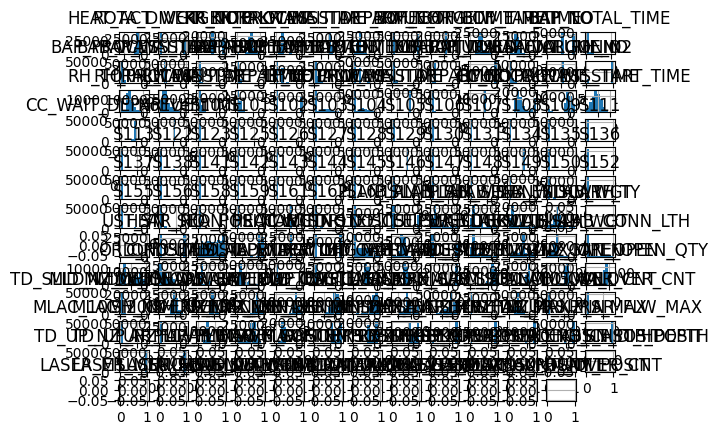

In [19]:
data_analysis.hist()

In [20]:
print("Sumarização de Defeitos: \n{0}\n".format(data_analysis.Defeitos.value_counts()))
print("Total de registros: \n{0}\n".format(len(data_analysis.index)))

Sumarização de Defeitos: 
False    39443
True     16188
Name: Defeitos, dtype: int64

Total de registros: 
60847



In [21]:
#Excluindo linhas que não possuem referencia com defeito. Irrelevantes para analise dos resultados e modelo.
data_analysis.dropna(subset=['Defeitos'], inplace=True)

print("Sumarização de Defeitos: \n{0}\n".format(data_analysis.Defeitos.value_counts()))
print("Total de registros: \n{0}\n".format(len(data_analysis.index)))

Sumarização de Defeitos: 
False    39443
True     16188
Name: Defeitos, dtype: int64

Total de registros: 
55631



In [22]:
data_analysis.isnull().sum()

PDA1417101V01             0
PDA1417101V02           150
PDA1417101V03           150
PDA1417101V04           150
PDA1417101V05           150
                      ...  
MLAC_50MM_OVER_CNT    55631
MLD_SURF_VORTEX_YN    55631
TCM_CUT_MODE          55631
SLAB_NO                   0
HEAT                      0
Length: 229, dtype: int64

##>>TRATAMENTO DE VALORES OMISSOS

###QUIMICOS

In [38]:
#ANALISANDO OCORRENCIAS DE VALORES OMISSOS DE COMPOSIÇÃO QUIMICA
print(data_analysis.groupby('Defeitos')['PDA1417101V01'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V02'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V03'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V04'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V05'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V06'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V07'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V08'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V10'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V11'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V14'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V15'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V16'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V18'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V19'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V20'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V21'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V22'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V23'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V24'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V25'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V30'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V31'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V33'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V36'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V37'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V69'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V94'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V96'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V97'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V98'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas.  

Defeitos  PDA1417101V01
False     True             37281
          False             2162
True      True             15071
          False             1117
Name: PDA1417101V01, dtype: int64
Defeitos  PDA1417101V02
False     True             38065
          False             1378
True      True             15626
          False              562
Name: PDA1417101V02, dtype: int64
Defeitos  PDA1417101V03
False     True             38845
          False              598
True      True             15915
          False              273
Name: PDA1417101V03, dtype: int64
Defeitos  PDA1417101V04
False     True             38294
          False             1149
True      True             15743
          False              445
Name: PDA1417101V04, dtype: int64
Defeitos  PDA1417101V05
False     True             38615
          False              828
True      True             15798
          False              390
Name: PDA1417101V05, dtype: int64
Defeitos  PDA1417101V06
False     True            

In [39]:
#TRATANDO VALORES OMISSOS DE COMPOSIÇÃO QUIMICA
data_analysis["PDA1417101V01"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V02"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V03"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V04"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V05"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V06"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V07"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V08"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V10"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V11"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V14"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V15"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V16"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V18"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V19"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V20"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V21"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V22"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V23"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V24"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V25"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V30"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V31"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V33"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V36"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V37"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V69"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V94"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V96"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V97"].fillna(value=True,inplace=True)
data_analysis["PDA1417101V98"].fillna(value=True,inplace=True)

In [40]:
#ANALISANDO OCORRENCIAS DE VALORES OMISSOS DE COMPOSIÇÃO QUIMICA
print(data_analysis.groupby('Defeitos')['PDA1417101V01'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V02'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V03'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V04'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V05'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V06'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V07'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V08'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V10'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V11'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V14'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V15'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V16'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V18'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V19'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V20'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V21'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V22'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V23'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V24'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V25'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V30'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V31'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V33'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V36'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V37'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V69'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V94'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V96'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V97'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas. 	
print(data_analysis.groupby('Defeitos')['PDA1417101V98'].value_counts(dropna=False)) #analisando ocorrencias de defeitos por caracteristicas quimicas não nulas.  

Defeitos  PDA1417101V01
False     True             37281
          False             2162
True      True             15071
          False             1117
Name: PDA1417101V01, dtype: int64
Defeitos  PDA1417101V02
False     True             38065
          False             1378
True      True             15626
          False              562
Name: PDA1417101V02, dtype: int64
Defeitos  PDA1417101V03
False     True             38845
          False              598
True      True             15915
          False              273
Name: PDA1417101V03, dtype: int64
Defeitos  PDA1417101V04
False     True             38294
          False             1149
True      True             15743
          False              445
Name: PDA1417101V04, dtype: int64
Defeitos  PDA1417101V05
False     True             38615
          False              828
True      True             15798
          False              390
Name: PDA1417101V05, dtype: int64
Defeitos  PDA1417101V06
False     True            

###LINGOTAMENTO

In [41]:
# CC_STR_NO: Valores omissos referenciam as ocorrencias de placas objetivadas (Defeito=True), aplicando regra para limpeza desta informação
data_analysis.groupby('Defeitos')['cc_STR_NO'].value_counts(dropna=False)

Defeitos  cc_STR_NO
False     5            19649
          0            19278
          6              273
          1              243
True      0             8099
          5             7737
          1              178
          6              172
          7                2
Name: cc_STR_NO, dtype: int64

In [42]:
#A 8ª posição da placa indica o veio de lingotamento, podendo mapear o veio corretamente
data_analysis['cc_STR_NO'] = pd.Categorical([cc_no[7] for cc_no in data_analysis['SLAB_NO'].astype(str)]).astype(int)
data_analysis['STR_NO'] = data_analysis['cc_STR_NO'].apply(lambda x: 2 if x>=5 else 1)

data_analysis.groupby('Defeitos')['STR_NO'].value_counts(dropna=False)

Defeitos  STR_NO
False     2         19922
          1         19521
True      1          8277
          2          7911
Name: STR_NO, dtype: int64

In [43]:
# SMPING_TY: Valores omissos referenciam as ocorrencias de placas objetivadas (Defeito=True), aplicando regra para limpeza desta informação. Placas amostradas fisicamente no processo
data_analysis.groupby('Defeitos')['SMPING_TY'].value_counts(dropna=False)

Defeitos  SMPING_TY
False     N            39101
          S              342
True      N            15942
          S              246
Name: SMPING_TY, dtype: int64

In [44]:
#aplicando tratamento de placas não amostradas
data_analysis["SMPING_TY"].fillna(value='N',inplace=True)

# SMPING_TY: Valores omissos referenciam as ocorrencias de placas objetivadas (Defeito=True), aplicando regra para limpeza desta informação. Placas amostradas fisicamente no processo
data_analysis.groupby('Defeitos')['SMPING_TY'].value_counts(dropna=False)

Defeitos  SMPING_TY
False     N            39101
          S              342
True      N            15942
          S              246
Name: SMPING_TY, dtype: int64

###VELOCIDADES DE LINGOTAMENTO

Total de registros nulos para CAST_MIN_SPD: 0

 Distribuição dos resultados:


array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>, <Axes: >], dtype=object)

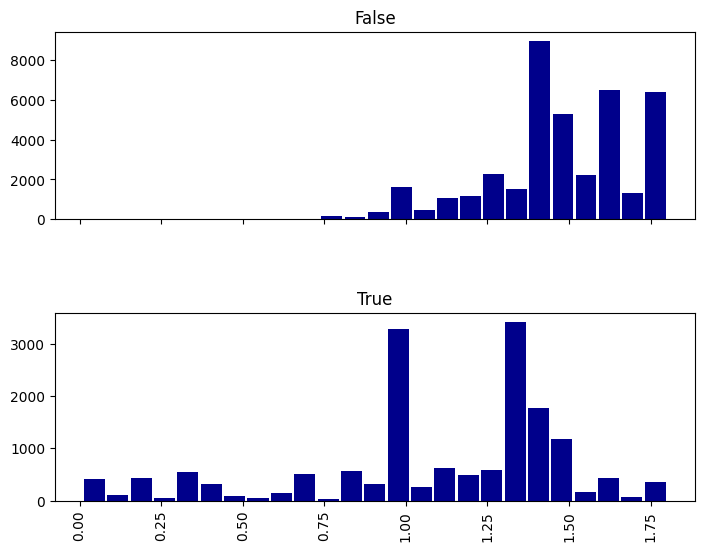

In [45]:
print("Total de registros nulos para CAST_MIN_SPD: {0}\n\n Distribuição dos resultados:".format(data_analysis.CAST_MIN_SPD.isna().sum()))

# CAST_MIN_SPD:Analisando histograma da variavel
data_analysis.hist(column='CAST_MIN_SPD',by='Defeitos', bins=25, grid=False, figsize=(8,10), layout=(3,1), sharex=True, color='#00008B', zorder=2, rwidth=0.9)

array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>, <Axes: >], dtype=object)

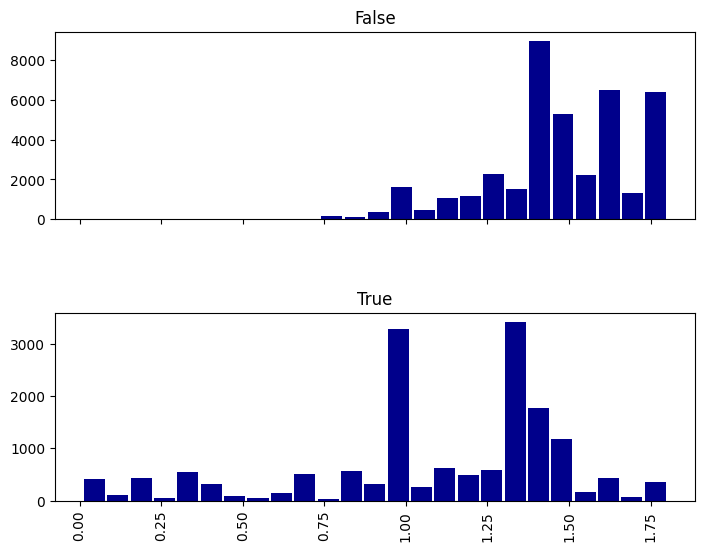

In [46]:
#aplicando a mediana das velocidades 
data_analysis["CAST_MIN_SPD"].fillna(value=data_analysis['CAST_MIN_SPD'].mean(),inplace=True)

# CAST_MIN_SPD:Analisando histograma da variavel
data_analysis.hist(column='CAST_MIN_SPD',by='Defeitos', bins=25, grid=False, figsize=(8,10), layout=(3,1), sharex=True, color='#00008B', zorder=2, rwidth=0.9)

Total de registros nulos para CAST_MAX_SPD: 0

 Distribuição dos resultados:


array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>, <Axes: >], dtype=object)

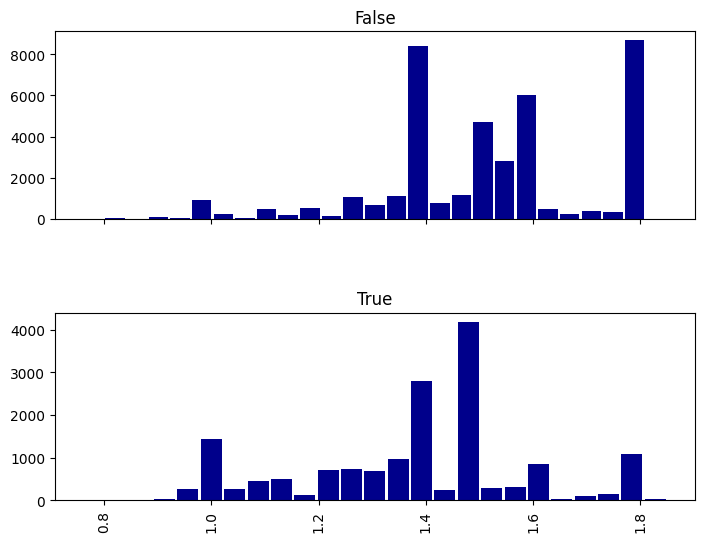

In [47]:
print("Total de registros nulos para CAST_MAX_SPD: {0}\n\n Distribuição dos resultados:".format(data_analysis.CAST_MAX_SPD.isna().sum()))

# CAST_MAX_SPD: Analisando histograma da variavel
data_analysis.hist(column='CAST_MAX_SPD',by='Defeitos', bins=25, grid=False, figsize=(8,10), layout=(3,1), sharex=True, color='#00008B', zorder=2, rwidth=0.9)

array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>, <Axes: >], dtype=object)

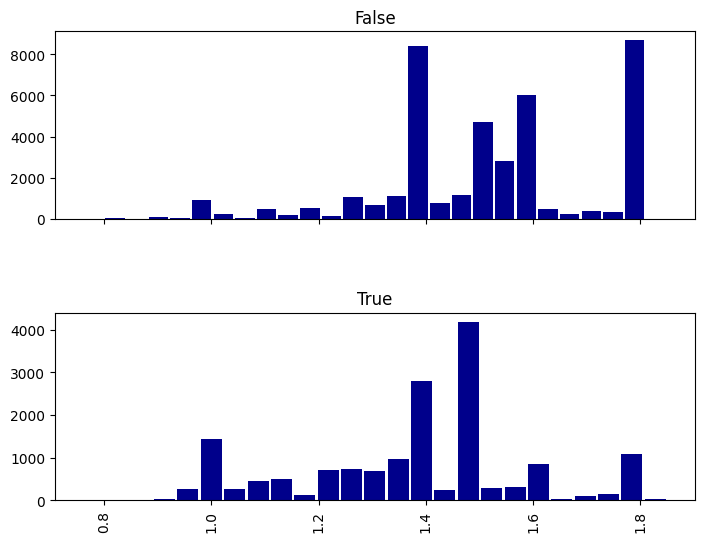

In [48]:
#aplicando a mediana das velocidades 
data_analysis["CAST_MAX_SPD"].fillna(value=data_analysis['CAST_MAX_SPD'].mean(),inplace=True)

# CAST_MAX_SPD: Analisando histograma da variavel
data_analysis.hist(column='CAST_MAX_SPD',by='Defeitos', bins=25, grid=False, figsize=(8,10), layout=(3,1), sharex=True, color='#00008B', zorder=2, rwidth=0.9)

Total de registros nulos para CAST_AVG_SPD: 0

 Distribuição dos resultados:


array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>, <Axes: >], dtype=object)

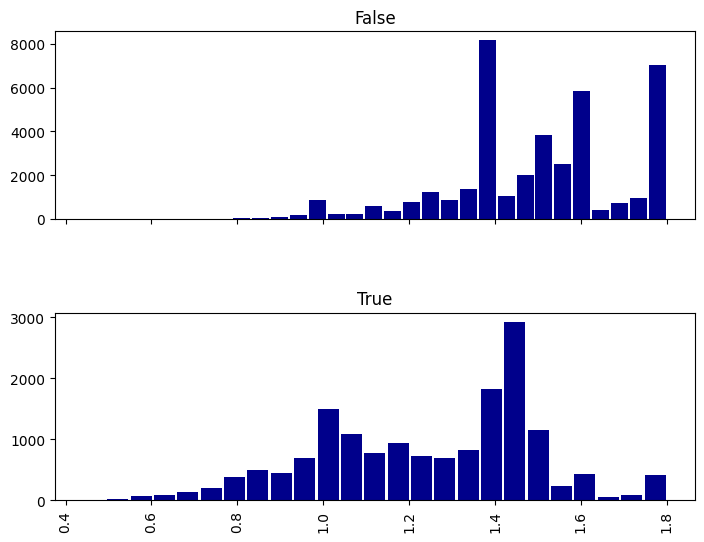

In [49]:
print("Total de registros nulos para CAST_AVG_SPD: {0}\n\n Distribuição dos resultados:".format(data_analysis.CAST_AVG_SPD.isna().sum()))

# CAST_AVG_SPD: Analisando histograma da variavel
data_analysis.hist(column='CAST_AVG_SPD',by='Defeitos', bins=25, grid=False, figsize=(8,10), layout=(3,1), sharex=True, color='#00008B', zorder=2, rwidth=0.9)

array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>, <Axes: >], dtype=object)

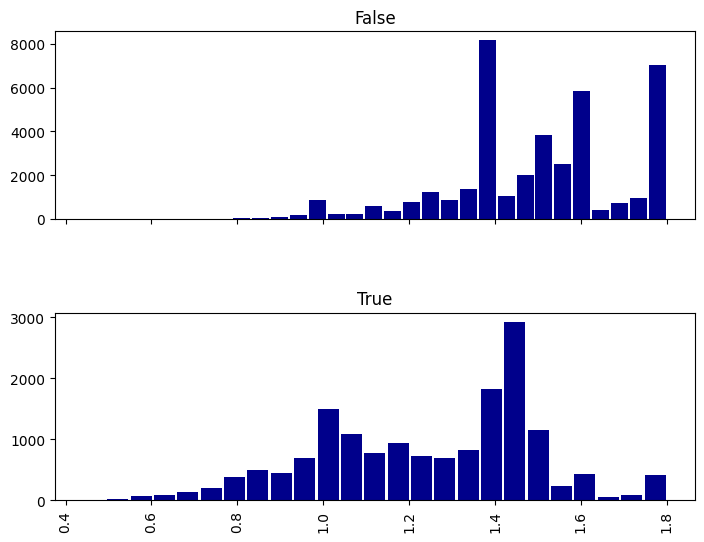

In [50]:
#aplicando a mediana das velocidades 
data_analysis["CAST_AVG_SPD"].fillna(value=data_analysis['CAST_AVG_SPD'].mean(),inplace=True)

# CAST_AVG_SPD: Analisando histograma da variavel
data_analysis.hist(column='CAST_AVG_SPD',by='Defeitos', bins=25, grid=False, figsize=(8,10), layout=(3,1), sharex=True, color='#00008B', zorder=2, rwidth=0.9)

###RESULTADO LINGOTAMENTO

In [51]:
#nalise de parametros de lingotamento nulas
print("Total de registros nulos para TD_AVG_TEMP: {0}".format(data_analysis.TD_AVG_TEMP.isna().sum()))
print("Total de registros nulos para MLAC_3MM_OVER_CNT: {0}".format(data_analysis.MLAC_3MM_OVER_CNT.isna().sum()))
print("Total de registros nulos para MLAC_5MM_OVER_CNT: {0}".format(data_analysis.MLAC_5MM_OVER_CNT.isna().sum()))
print("Total de registros nulos para MLAC_10MM_OVER_CNT: {0}".format(data_analysis.MLAC_10MM_OVER_CNT.isna().sum()))
print("Total de registros nulos para MLAC_20MM_OVER_CNT: {0}".format(data_analysis.MLAC_20MM_OVER_CNT.isna().sum()))
print("Total de registros nulos para TD_UP_NZ_AR_FLW_MIN: {0}".format(data_analysis.TD_UP_NZ_AR_FLW_MIN.isna().sum()))
print("Total de registros nulos para TD_UP_NZ_AR_FLW_AVG: {0}".format(data_analysis.TD_UP_NZ_AR_FLW_AVG.isna().sum()))
print("Total de registros nulos para TD_UP_NZ_AR_FLW_MAX: {0}".format(data_analysis.TD_UP_NZ_AR_FLW_MAX.isna().sum()))
print("Total de registros nulos para SH_NZ_DIP_MAX_DEPTH: {0}".format(data_analysis.SH_NZ_DIP_MAX_DEPTH.isna().sum()))
print("Total de registros nulos para SH_NZ_DIP_MIN_DEPTH: {0}".format(data_analysis.SH_NZ_DIP_MIN_DEPTH.isna().sum()))
print("Total de registros nulos para SN_SETTLE_MIN_DEPTH: {0}".format(data_analysis.SN_SETTLE_MIN_DEPTH.isna().sum()))
print("Total de registros nulos para SN_SETTLE_MAX_DEPTH: {0}".format(data_analysis.SN_SETTLE_MAX_DEPTH.isna().sum()))
print("Total de registros nulos para MLD_TAPR_RGT_CHG_VAL: {0}".format(data_analysis.MLD_TAPR_RGT_CHG_VAL.isna().sum()))
print("Total de registros nulos para MLD_TAPR_LFT_CHG_VAL: {0}".format(data_analysis.MLD_TAPR_LFT_CHG_VAL.isna().sum()))
print("Total de registros nulos para TD_STEEL_WGT: {0}".format(data_analysis.TD_STEEL_WGT.isna().sum()))
print("Total de registros nulos para SH_NZ_AR_PRS_MIN: {0}".format(data_analysis.SH_NZ_AR_PRS_MIN.isna().sum()))
print("Total de registros nulos para SH_NZ_AR_PRS_MAX: {0}".format(data_analysis.SH_NZ_AR_PRS_MAX.isna().sum()))
print("Total de registros nulos para SH_NZ_AR_FLW_MIN: {0}".format(data_analysis.SH_NZ_AR_FLW_MIN.isna().sum()))
print("Total de registros nulos para SH_NZ_AR_FLW_MAX: {0}".format(data_analysis.SH_NZ_AR_FLW_MAX.isna().sum()))
print("Total de registros nulos para RGT_MD_TAPR_RATE: {0}".format(data_analysis.RGT_MD_TAPR_RATE.isna().sum()))
print("Total de registros nulos para LFT_MD_TAPR_RATE: {0}".format(data_analysis.LFT_MD_TAPR_RATE.isna().sum()))
print("Total de registros nulos para MLAC_SCAN_TOT_CNT: {0}".format(data_analysis.MLAC_SCAN_TOT_CNT.isna().sum()))
print("Total de registros nulos para SH_NZ_DIP_AVG_DEPTH: {0}".format(data_analysis.SH_NZ_DIP_AVG_DEPTH.isna().sum()))
print("Total de registros nulos para TD_SLID_NZ_MAX_OPEN: {0}".format(data_analysis.TD_SLID_NZ_MAX_OPEN.isna().sum()))
print("Total de registros nulos para TD_SLID_NZ_MIN_OPEN: {0}".format(data_analysis.TD_SLID_NZ_MIN_OPEN.isna().sum()))
print("Total de registros nulos para SN_SETTLE_AVG_DEPTH: {0}".format(data_analysis.SN_SETTLE_AVG_DEPTH.isna().sum()))
print("Total de registros nulos para TD_SLID_GATE_OPEN_QTY: {0}".format(data_analysis.TD_SLID_GATE_OPEN_QTY.isna().sum()))
print("Total de registros nulos para CAST_IN_CAST_SPD_CHG_VAL: {0}".format(data_analysis.CAST_IN_CAST_SPD_CHG_VAL.isna().sum()))
print("Total de registros nulos para MLD_WIDE_OS_CW_TEMP_DIFF: {0}".format(data_analysis.MLD_WIDE_OS_CW_TEMP_DIFF.isna().sum()))
print("Total de registros nulos para TD_SLID_NZ_OPEN_VAR_RATE: {0}".format(data_analysis.TD_SLID_NZ_OPEN_VAR_RATE.isna().sum()))
print("Total de registros nulos para MLD_WIDE_IS_CW_TEMP_DIFF: {0}".format(data_analysis.MLD_WIDE_IS_CW_TEMP_DIFF.isna().sum()))
print("Total de registros nulos para MLD_NARW_RGT_CW_TEMP_DIFF: {0}".format(data_analysis.MLD_NARW_RGT_CW_TEMP_DIFF.isna().sum()))
print("Total de registros nulos para MLD_NARW_LFT_CW_TEMP_DIFF: {0}".format(data_analysis.MLD_NARW_LFT_CW_TEMP_DIFF.isna().sum()))



Total de registros nulos para TD_AVG_TEMP: 0
Total de registros nulos para MLAC_3MM_OVER_CNT: 0
Total de registros nulos para MLAC_5MM_OVER_CNT: 0
Total de registros nulos para MLAC_10MM_OVER_CNT: 0
Total de registros nulos para MLAC_20MM_OVER_CNT: 0
Total de registros nulos para TD_UP_NZ_AR_FLW_MIN: 0
Total de registros nulos para TD_UP_NZ_AR_FLW_AVG: 0
Total de registros nulos para TD_UP_NZ_AR_FLW_MAX: 0
Total de registros nulos para SH_NZ_DIP_MAX_DEPTH: 0
Total de registros nulos para SH_NZ_DIP_MIN_DEPTH: 0
Total de registros nulos para SN_SETTLE_MIN_DEPTH: 0
Total de registros nulos para SN_SETTLE_MAX_DEPTH: 0
Total de registros nulos para MLD_TAPR_RGT_CHG_VAL: 0
Total de registros nulos para MLD_TAPR_LFT_CHG_VAL: 0
Total de registros nulos para TD_STEEL_WGT: 0
Total de registros nulos para SH_NZ_AR_PRS_MIN: 0
Total de registros nulos para SH_NZ_AR_PRS_MAX: 0
Total de registros nulos para SH_NZ_AR_FLW_MIN: 0
Total de registros nulos para SH_NZ_AR_FLW_MAX: 0
Total de registros nulos

In [52]:
data_analysis["TD_UP_NZ_AR_FLW_MIN"].fillna(value=data_analysis['TD_UP_NZ_AR_FLW_MIN'].mean(),inplace=True)   
data_analysis["TD_UP_NZ_AR_FLW_AVG"].fillna(value=data_analysis['TD_UP_NZ_AR_FLW_AVG'].mean(),inplace=True)
data_analysis["TD_UP_NZ_AR_FLW_MAX"].fillna(value=data_analysis['TD_UP_NZ_AR_FLW_MAX'].mean(),inplace=True)
data_analysis["SH_NZ_DIP_MAX_DEPTH"].fillna(value=data_analysis['SH_NZ_DIP_MAX_DEPTH'].mean(),inplace=True)
data_analysis["SH_NZ_DIP_MIN_DEPTH"].fillna(value=data_analysis['SH_NZ_DIP_MIN_DEPTH'].mean(),inplace=True)
data_analysis["SN_SETTLE_MIN_DEPTH"].fillna(value=data_analysis['SN_SETTLE_MIN_DEPTH'].mean(),inplace=True)
data_analysis["SN_SETTLE_MAX_DEPTH"].fillna(value=data_analysis['SN_SETTLE_MAX_DEPTH'].mean(),inplace=True)
data_analysis["MLAC_3MM_OVER_CNT"].fillna(value=data_analysis['MLAC_3MM_OVER_CNT'].mean(),inplace=True)
data_analysis["MLAC_5MM_OVER_CNT"].fillna(value=data_analysis['MLAC_5MM_OVER_CNT'].mean(),inplace=True)
data_analysis["MLAC_10MM_OVER_CNT"].fillna(value=data_analysis['MLAC_10MM_OVER_CNT'].mean(),inplace=True)
data_analysis["MLAC_20MM_OVER_CNT"].fillna(value=data_analysis['MLAC_20MM_OVER_CNT'].mean(),inplace=True)
data_analysis["TD_AVG_TEMP"].fillna(value=data_analysis['TD_AVG_TEMP'].mean(),inplace=True)
data_analysis["MLD_TAPR_RGT_CHG_VAL"].fillna(value=data_analysis['MLD_TAPR_RGT_CHG_VAL'].mean(),inplace=True)
data_analysis["MLD_TAPR_LFT_CHG_VAL"].fillna(value=data_analysis['MLD_TAPR_LFT_CHG_VAL'].mean(),inplace=True)
data_analysis["SH_NZ_AR_PRS_MIN"].fillna(value=data_analysis['SH_NZ_AR_PRS_MIN'].mean(),inplace=True)
data_analysis["SH_NZ_AR_PRS_MAX"].fillna(value=data_analysis['SH_NZ_AR_PRS_MAX'].mean(),inplace=True)
data_analysis["SN_SETTLE_AVG_DEPTH"].fillna(value=data_analysis['SN_SETTLE_AVG_DEPTH'].mean(),inplace=True)
data_analysis["SH_NZ_AR_FLW_MIN"].fillna(value=data_analysis['SH_NZ_AR_FLW_MIN'].mean(),inplace=True)
data_analysis["SH_NZ_AR_FLW_MAX"].fillna(value=data_analysis['SH_NZ_AR_FLW_MAX'].mean(),inplace=True)
data_analysis["SH_NZ_DIP_AVG_DEPTH"].fillna(value=data_analysis['SH_NZ_DIP_AVG_DEPTH'].mean(),inplace=True)
data_analysis["CAST_IN_CAST_SPD_CHG_VAL"].fillna(value=data_analysis['CAST_IN_CAST_SPD_CHG_VAL'].mean(),inplace=True)
data_analysis["MLAC_SCAN_TOT_CNT"].fillna(value=data_analysis['MLAC_SCAN_TOT_CNT'].mean(),inplace=True)
data_analysis["MLD_NARW_RGT_CW_TEMP_DIFF"].fillna(value=data_analysis['MLD_NARW_RGT_CW_TEMP_DIFF'].mean(),inplace=True)
data_analysis["MLD_WIDE_OS_CW_TEMP_DIFF"].fillna(value=data_analysis['MLD_WIDE_OS_CW_TEMP_DIFF'].mean(),inplace=True)
data_analysis["MLD_NARW_LFT_CW_TEMP_DIFF"].fillna(value=data_analysis['MLD_NARW_LFT_CW_TEMP_DIFF'].mean(),inplace=True)
data_analysis["TD_SLID_NZ_OPEN_VAR_RATE"].fillna(value=data_analysis['TD_SLID_NZ_OPEN_VAR_RATE'].mean(),inplace=True)
data_analysis["MLD_WIDE_IS_CW_TEMP_DIFF"].fillna(value=data_analysis['MLD_WIDE_IS_CW_TEMP_DIFF'].mean(),inplace=True)
data_analysis["TD_SLID_NZ_MAX_OPEN"].fillna(value=data_analysis['TD_SLID_NZ_MAX_OPEN'].mean(),inplace=True)
data_analysis["TD_SLID_NZ_MIN_OPEN"].fillna(value=data_analysis['TD_SLID_NZ_MIN_OPEN'].mean(),inplace=True)
data_analysis["TD_SLID_GATE_OPEN_QTY"].fillna(value=data_analysis['TD_SLID_GATE_OPEN_QTY'].mean(),inplace=True)
data_analysis["RGT_MD_TAPR_RATE"].fillna(value=data_analysis['RGT_MD_TAPR_RATE'].mean(),inplace=True)
data_analysis["LFT_MD_TAPR_RATE"].fillna(value=data_analysis['LFT_MD_TAPR_RATE'].mean(),inplace=True)
data_analysis["TD_STEEL_WGT"].fillna(value=data_analysis['TD_STEEL_WGT'].mean(),inplace=True)
data_analysis["CAST_IN_LD_STEEL_WGT"].fillna(value=data_analysis['CAST_IN_LD_STEEL_WGT'].mean(),inplace=True)
data_analysis["MLD_OSCILL_GAP"].fillna(value=data_analysis['MLD_OSCILL_GAP'].mean(),inplace=True) 

In [53]:
print("Total de registros nulos para PLAN_CUT_SLAB_NO: {0}".format(data_analysis.PLAN_CUT_SLAB_NO.isna().sum()))
print("Sumarização de Defeitos: \n{0}\n".format(data_analysis.Defeitos.value_counts()))
print("Total de registros: \n{0}\n".format(len(data_analysis.index)))

print(data_analysis.groupby('Defeitos')['CUT_SLAB_THK'].value_counts(dropna=False))

Total de registros nulos para PLAN_CUT_SLAB_NO: 2534
Sumarização de Defeitos: 
False    39443
True     16188
Name: Defeitos, dtype: int64

Total de registros: 
55631

Defeitos  CUT_SLAB_THK
False     220.0           26606
          250.0           12837
True      250.0            6838
          220.0            6816
          NaN              2534
Name: CUT_SLAB_THK, dtype: int64


In [54]:
print(data_analysis.groupby('Defeitos')['CUT_SLAB_THK'].value_counts(dropna=False))
data_analysis["CUT_SLAB_THK"].fillna(value=220,inplace=True)

Defeitos  CUT_SLAB_THK
False     220.0           26606
          250.0           12837
True      250.0            6838
          220.0            6816
          NaN              2534
Name: CUT_SLAB_THK, dtype: int64


In [55]:
print(data_analysis.groupby('Defeitos')['CUT_SLAB_WTH'].value_counts(dropna=False))
data_analysis["CUT_SLAB_WTH"].fillna(value=data_analysis["CUT_SLAB_WTH"].mean(),inplace=True)

Defeitos  CUT_SLAB_WTH
False     1250.0          4675
          1255.0          3812
          1550.0          2539
          1251.0          2412
          1195.0          1586
                          ... 
True      2187.0             1
          2189.0             1
          2196.0             1
          2209.0             1
          2224.0             1
Name: CUT_SLAB_WTH, Length: 905, dtype: int64


In [56]:
print(data_analysis.groupby('Defeitos')['CUT_SLAB_LTH'].value_counts(dropna=False))
data_analysis["CUT_SLAB_LTH"].fillna(value=data_analysis["CUT_SLAB_LTH"].mean(),inplace=True)

Defeitos  CUT_SLAB_LTH
False     10308.0         679
          10309.0         623
          10307.0         581
          10310.0         574
          10306.0         560
                         ... 
True      12472.0           1
          12483.0           1
          12497.0           1
          12500.0           1
          12502.0           1
Name: CUT_SLAB_LTH, Length: 4433, dtype: int64


In [57]:
print(data_analysis.groupby('Defeitos')['CUT_SLAB_WGT'].value_counts(dropna=False))
data_analysis["CUT_SLAB_WGT"].fillna(value=data_analysis["CUT_SLAB_WGT"].mean(),inplace=True)

Defeitos  CUT_SLAB_WGT
False     22.198          252
          22.203          230
          22.263          204
          22.205          203
          24.729          194
                         ... 
True      43.972            1
          44.784            1
          45.340            1
          48.899            1
          48.932            1
Name: CUT_SLAB_WGT, Length: 9988, dtype: int64


##>>CODIFICAÇÃO

In [58]:
le = LabelEncoder()

data_analysis['cod_steel_grade'] = le.fit_transform(data_analysis['TGT_STEEL_GRD'])
data_analysis['cod_route'] = le.fit_transform(data_analysis['SECOND_RFN_CD'])
data_analysis['cod_posit'] = le.fit_transform(data_analysis['SLAB_CUT_POSIT_CD'])
data_analysis['cod_taper'] = le.fit_transform(data_analysis['CC_TAPER_TY'])
data_analysis['cod_spec'] = le.fit_transform(data_analysis['SPEC_CD'])
data_analysis['cod_plan_wth_change'] = le.fit_transform(data_analysis['PLAN_WTH_CHANGE_YN'])  
data_analysis['cod_sampling'] = le.fit_transform(data_analysis['SMPING_TY'])  
data_analysis['cod_posit_cut'] = le.fit_transform(data_analysis['SLAB_CUT_POSIT_CD']) 

#utilizando a mesma codificação para rotas planejaas e reais
le_route = LabelEncoder()
data_analysis['cod_passed_route'] = le_route.fit_transform(data_analysis['PASS_PROC_ROUTE'].str.slice(start=2, stop=99)) 
data_analysis['cod_plan_route'] = le_route.transform(data_analysis['PLAN_PROC_ROUTE'])

data_analysis['PLAN_SECOND_RFN_CD'] = data_analysis['PLAN_SECOND_RFN_CD'].astype(str) #forçando formato de dados str devido a origem da informação conter int/str como códificação
data_analysis['cod_plan_2ndroute'] = le.fit_transform(data_analysis['PLAN_SECOND_RFN_CD'])
 
data_analysis['BAP_PROCESSO_PADRAO'] = data_analysis['BAP_PROCESSO_PADRAO'].astype(str) #forçando formato de dados str devido a origem da informação conter int/str como códificação
data_analysis['cod_bap_process'] = le.fit_transform(data_analysis['BAP_PROCESSO_PADRAO']) 

##>>ENRIQUECIMENTO

In [59]:
##Criando indicadores para analise de rotas de produção e equipamentos utilizados
data_analysis['ACT_EQUIP_ROUTE_RH'] = np.where(data_analysis['PASS_PROC_ROUTE'].str.contains("RH"), True, False)
data_analysis['ACT_EQUIP_ROUTE_LF'] = np.where(data_analysis['PASS_PROC_ROUTE'].str.contains("LF"), True, False)
data_analysis['PLN_EQUIP_ROUTE_RH'] = np.where(data_analysis['PLAN_PROC_ROUTE'].str.contains("RH"), True, False)
data_analysis['PLN_EQUIP_ROUTE_LF'] = np.where(data_analysis['PLAN_PROC_ROUTE'].str.contains("LF"), True, False)
data_analysis['ACT_DOUBLE_EQUIP_ROUTE_RH'] = np.where(data_analysis['PASS_PROC_ROUTE'].str.contains("RHRH"), True, False)
data_analysis['ACT_DOUBLE_EQUIP_ROUTE_LF'] = np.where(data_analysis['PASS_PROC_ROUTE'].str.contains("LFLF"), True, False)

In [60]:
#analisando pelo código se houve devio da rota
data_analysis['DESVIO_RH'] = np.where(data_analysis['ACT_EQUIP_ROUTE_RH'] == data_analysis['PLN_EQUIP_ROUTE_RH'], False, True)
data_analysis['DESVIO_LF'] = np.where(data_analysis['ACT_EQUIP_ROUTE_LF'] == data_analysis['PLN_EQUIP_ROUTE_LF'], False, True)
data_analysis['DESVIO_ROTA'] = np.where(data_analysis['cod_passed_route'] == data_analysis['cod_plan_route'], False, True)

In [61]:
data_analysis['MISTURA'] = np.where(pd.isnull(data_analysis['MIXD_SLAB_HEAT_NO']), False, True)#Criando indicador de existencia de mistura de aços para as placas

In [62]:
#CRIANDO NOVAS CARACTERISTICS dimensionais
data_analysis['TAPER_REDUCAO'] = (data_analysis['CUT_SLAB_STA_WTH'] - data_analysis['CUT_SLAB_END_WTH'])
data_analysis['GAP_ESPESS_PLAN'] = (data_analysis['CUT_SLAB_THK'] - data_analysis['PLAN_SLAB_THK'])
data_analysis['GAP_PESO_PLAN'] = (data_analysis['CUT_SLAB_WGT'] - data_analysis['PLAN_SLAB_WGT'])
data_analysis['GAP_LARGU_CABECA'] = (data_analysis['CUT_SLAB_STA_WTH'] - data_analysis['PLAN_SLAB_STA_WTH']) 
data_analysis['GAP_LARGU_CAUDA'] = (data_analysis['CUT_SLAB_END_WTH'] - data_analysis['PLAN_SLAB_END_WTH']) 
data_analysis['GAP_LARGURA_PLAN'] = (data_analysis['CUT_SLAB_WTH'] - data_analysis['PLAN_SLAB_WTH']) 

data_analysis.head()

,PDA1417101V01,PDA1417101V02,PDA1417101V03,PDA1417101V04,PDA1417101V05,PDA1417101V06,PDA1417101V07,PDA1417101V08,PDA1417101V10,PDA1417101V11,PDA1417101V14,PDA1417101V15,PDA1417101V16,PDA1417101V18,PDA1417101V19,PDA1417101V20,PDA1417101V21,PDA1417101V22,PDA1417101V23,PDA1417101V24,PDA1417101V25,PDA1417101V30,PDA1417101V31,PDA1417101V33,PDA1417101V36,PDA1417101V37,PDA1417101V69,PDA1417101V94,PDA1417101V96,PDA1417101V97,PDA1417101V98,Defeitos,TGT_STEEL_GRD,PASS_PROC_ROUTE,PLAN_PROC_ROUTE,SECOND_RFN_CD,HEAT_ACT_WGT,ROTA_DIVERGENTE,KR_NO,KR_TOTAL_TIME,KR_PROCESS_TIME,KR_WAIT_START_TIME,KR_WAIT_DEPARTUE_TIME,BOF_NO,BOF_CHRG_TIME,BOF_BLW_TIME,BOF_TAP_TIME,BAP_NO,BAP_TOTAL_TIME,BAP_PROCESS_TIME,BAP_WAIT_START_TIME,BAP_WAIT_DEPARTUE_TIME,BAP_RSLT_TIME,BAP_PROCESSO_PADRAO,BAP_TOP_BB_TOT_CNT,BAP_TOP_BB_TOT_DUR,BAP_BTM_BB_TOT_CNT,BAP_BTM_BB_TOT_DUR,BAP_TEMPERATURA_SAIDA,BAP_PI_USED_CNT,BAP_VOLUME_ARGONIO,BAP_VOLUME_N2,RH_NO,RH_TOTAL_TIME,RH_PROCESS_TIME,RH_WAIT_START_TIME,RH_WAIT_DEPARTUE_TIME,LF_NO,LF_TOTAL_TIME,LF_PROCESS_TIME,LF_WAIT_START_TIME,LF_WAIT_DEPARTUE_TIME,CC_NO,CC_TOTAL_TIME,CC_PROCESS_TIME,CC_WAIT_START_TIME,CC_WAIT_DEPARTUE_TIME,NoEvent,S100,S101,S102,S103,S104,S105,S106,S107,S108,S109,S111,S113,S122,S123,S125,S126,S127,S128,S129,S130,S131,S134,S135,S136,S137,S138,S141,S142,S143,S144,S145,S146,S147,S148,S149,S150,S152,S155,S156,S158,S159,S161,S162,S163,SPEC_CD,PLAN_SLAB_THK,PLAN_SLAB_WTH,PLAN_SLAB_STA_WTH,PLAN_SLAB_END_WTH,PLAN_SLAB_WGT,SCARF_TY,UST_YN,SMPING_TY,TAPER_TY,STR_NO,MIXED_TY,COOLING_TY,SHORT_SLAB_TY,HEAT_SEQ_POSITION,PLAN_SECOND_RFN_CD,PLAN_DE_P_YN,PLAN_HEAT_WGT,PLAN_WTH_CHANGE_YN,PLAN_TUDISH_CHG_FL,PLAN_CUT_SLAB_NO,PROC_MC_NO,cc_STR_NO,MIXD_SLAB_HEAT_NO,CAST_IN_LD_STEEL_WGT,TD_STEEL_SUPERH_DGR,CUT_SLAB_THK,CUT_SLAB_WTH,CUT_SLAB_LTH,CUT_SLAB_WGT,CUT_SLAB_CONN_LTH,SLAB_CUT_POSIT_CD,ORD_NO,ORD_ITEM,CC_TAPER_TY,CUT_SLAB_STA_WTH,CUT_SLAB_END_WTH,MLD_TAPR_RGT_CHG_VAL,MLD_TAPR_LFT_CHG_VAL,RGT_MD_TAPR_RATE,LFT_MD_TAPR_RATE,TD_AVG_TEMP,TD_STEEL_WGT,TD_SLID_NZ_MAX_OPEN,TD_SLID_NZ_MIN_OPEN,TD_SLID_GATE_OPEN_QTY,TD_SLID_NZ_OPEN_VAR_RATE,MLD_WIDE_IS_CW_TEMP_DIFF,MLD_WIDE_OS_CW_TEMP_DIFF,MLD_NARW_LFT_CW_TEMP_DIFF,MLD_NARW_RGT_CW_TEMP_DIFF,MLD_OSCILL_GAP,CAST_MIN_SPD,CAST_MAX_SPD,CAST_AVG_SPD,CAST_IN_CAST_SPD_CHG_VAL,MLAC_SCAN_TOT_CNT,MLAC_3MM_OVER_CNT,MLAC_5MM_OVER_CNT,MLAC_10MM_OVER_CNT,MLAC_20MM_OVER_CNT,SH_NZ_DIP_MAX_DEPTH,SH_NZ_DIP_MIN_DEPTH,SH_NZ_DIP_AVG_DEPTH,SN_SETTLE_MIN_DEPTH,SN_SETTLE_MAX_DEPTH,SN_SETTLE_AVG_DEPTH,SH_NZ_AR_FLW_MIN,SH_NZ_AR_FLW_MAX,SH_NZ_AR_PRS_MIN,SH_NZ_AR_PRS_MAX,TD_UP_NZ_AR_FLW_MAX,TD_UP_NZ_AR_FLW_MIN,TD_UP_NZ_AR_FLW_AVG,UP_PLT_AR_FLW_MAX,UP_PLT_AR_FLW_MIN,ENTRY_CW_TEMP,SOFT_PRS_TY,SOFT_PRS_ENTRY_THK,SOFT_PRS_EXIT_THK,SOFT_PRS_PRS_DN_VAL,SOFT_PRS_ZONE_CNT,LD_SN_RP_CAST_HEAD_POSIT,LD_OPEN_PUR_STA_CAST_HPOSIT,LD_OPEN_PUR_END_CAST_HPOSIT,LD_EXCHG_SN_DIP_DEPTH,LASER_MSU_TAIL_WTH,LASER_MSU_HEAD_WTH,LASER_MSU_MID_WTH,LST_SLAB_YN,CUT_SLAB_LTH_CONT_RATE,CUT_SLAB_WTH_CONT_RATE,CUT_SLAB_HEAD_MLD_PASS_DTM,CUT_SLAB_TAIL_MLD_PASS_DTM,MLD_MAX_CHG_CAST_SPD,MLD_MAX_CAST_SPD_CHG_POSIT,MLD_LEVEL_MAX_HUNT_AMT,MLD_LEVEL_MAX_HUNT_POSIT,BY_PLAN_YN,SEN_EXCHANGE_FLAG,TAPPER_SLAB_FLAG,MLD_LEVEL_AUTO_MODE,MLAC_50MM_OVER_CNT,MLD_SURF_VORTEX_YN,TCM_CUT_MODE,SLAB_NO,HEAT,cod_steel_grade,cod_route,cod_posit,cod_taper,cod_spec,cod_plan_wth_change,cod_sampling,cod_posit_cut,cod_passed_route,cod_plan_route,cod_plan_2ndroute,cod_bap_process,ACT_EQUIP_ROUTE_RH,ACT_EQUIP_ROUTE_LF,PLN_EQUIP_ROUTE_RH,PLN_EQUIP_ROUTE_LF,ACT_DOUBLE_EQUIP_ROUTE_RH,ACT_DOUBLE_EQUIP_ROUTE_LF,DESVIO_RH,DESVIO_LF,DESVIO_ROTA,MISTURA,TAPER_REDUCAO,GAP_ESPESS_PLAN,GAP_PESO_PLAN,GAP_LARGU_CABECA,GAP_LARGU_CAUDA,GAP_LARGURA_PLAN
0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,W04018RAXX1,PRKRDCEBRHLC,KRDCEBRHLC,2A,342.8,0.0,1.0,47.0,32.0,7.0,8.0,2.0,0.0,20.0,11.0,2.0,2.0,0.0,0.0,0.0,0.0,Z,0.0,0.0,0.0,0.0,1619.0,1.0,0.0,0.0,1.0,19.0,13.0,2.0,3.0,0.

In [63]:
print("Total de registros nulos para GAP_LARGU_CAUDA: {0}".format(data_analysis.GAP_LARGU_CAUDA.isna().sum()))
data_analysis["GAP_LARGU_CAUDA"].fillna(value=data_analysis['GAP_LARGU_CAUDA'].mean(),inplace=True)

Total de registros nulos para GAP_LARGU_CAUDA: 2534


In [64]:
print("Total de registros nulos para GAP_LARGU_CABECA: {0}".format(data_analysis.GAP_LARGU_CABECA.isna().sum()))
data_analysis["GAP_LARGU_CABECA"].fillna(value=data_analysis['GAP_LARGU_CABECA'].mean(),inplace=True)

Total de registros nulos para GAP_LARGU_CABECA: 2534


In [65]:
data_analysis.head(25)

,PDA1417101V01,PDA1417101V02,PDA1417101V03,PDA1417101V04,PDA1417101V05,PDA1417101V06,PDA1417101V07,PDA1417101V08,PDA1417101V10,PDA1417101V11,PDA1417101V14,PDA1417101V15,PDA1417101V16,PDA1417101V18,PDA1417101V19,PDA1417101V20,PDA1417101V21,PDA1417101V22,PDA1417101V23,PDA1417101V24,PDA1417101V25,PDA1417101V30,PDA1417101V31,PDA1417101V33,PDA1417101V36,PDA1417101V37,PDA1417101V69,PDA1417101V94,PDA1417101V96,PDA1417101V97,PDA1417101V98,Defeitos,TGT_STEEL_GRD,PASS_PROC_ROUTE,PLAN_PROC_ROUTE,SECOND_RFN_CD,HEAT_ACT_WGT,ROTA_DIVERGENTE,KR_NO,KR_TOTAL_TIME,KR_PROCESS_TIME,KR_WAIT_START_TIME,KR_WAIT_DEPARTUE_TIME,BOF_NO,BOF_CHRG_TIME,BOF_BLW_TIME,BOF_TAP_TIME,BAP_NO,BAP_TOTAL_TIME,BAP_PROCESS_TIME,BAP_WAIT_START_TIME,BAP_WAIT_DEPARTUE_TIME,BAP_RSLT_TIME,BAP_PROCESSO_PADRAO,BAP_TOP_BB_TOT_CNT,BAP_TOP_BB_TOT_DUR,BAP_BTM_BB_TOT_CNT,BAP_BTM_BB_TOT_DUR,BAP_TEMPERATURA_SAIDA,BAP_PI_USED_CNT,BAP_VOLUME_ARGONIO,BAP_VOLUME_N2,RH_NO,RH_TOTAL_TIME,RH_PROCESS_TIME,RH_WAIT_START_TIME,RH_WAIT_DEPARTUE_TIME,LF_NO,LF_TOTAL_TIME,LF_PROCESS_TIME,LF_WAIT_START_TIME,LF_WAIT_DEPARTUE_TIME,CC_NO,CC_TOTAL_TIME,CC_PROCESS_TIME,CC_WAIT_START_TIME,CC_WAIT_DEPARTUE_TIME,NoEvent,S100,S101,S102,S103,S104,S105,S106,S107,S108,S109,S111,S113,S122,S123,S125,S126,S127,S128,S129,S130,S131,S134,S135,S136,S137,S138,S141,S142,S143,S144,S145,S146,S147,S148,S149,S150,S152,S155,S156,S158,S159,S161,S162,S163,SPEC_CD,PLAN_SLAB_THK,PLAN_SLAB_WTH,PLAN_SLAB_STA_WTH,PLAN_SLAB_END_WTH,PLAN_SLAB_WGT,SCARF_TY,UST_YN,SMPING_TY,TAPER_TY,STR_NO,MIXED_TY,COOLING_TY,SHORT_SLAB_TY,HEAT_SEQ_POSITION,PLAN_SECOND_RFN_CD,PLAN_DE_P_YN,PLAN_HEAT_WGT,PLAN_WTH_CHANGE_YN,PLAN_TUDISH_CHG_FL,PLAN_CUT_SLAB_NO,PROC_MC_NO,cc_STR_NO,MIXD_SLAB_HEAT_NO,CAST_IN_LD_STEEL_WGT,TD_STEEL_SUPERH_DGR,CUT_SLAB_THK,CUT_SLAB_WTH,CUT_SLAB_LTH,CUT_SLAB_WGT,CUT_SLAB_CONN_LTH,SLAB_CUT_POSIT_CD,ORD_NO,ORD_ITEM,CC_TAPER_TY,CUT_SLAB_STA_WTH,CUT_SLAB_END_WTH,MLD_TAPR_RGT_CHG_VAL,MLD_TAPR_LFT_CHG_VAL,RGT_MD_TAPR_RATE,LFT_MD_TAPR_RATE,TD_AVG_TEMP,TD_STEEL_WGT,TD_SLID_NZ_MAX_OPEN,TD_SLID_NZ_MIN_OPEN,TD_SLID_GATE_OPEN_QTY,TD_SLID_NZ_OPEN_VAR_RATE,MLD_WIDE_IS_CW_TEMP_DIFF,MLD_WIDE_OS_CW_TEMP_DIFF,MLD_NARW_LFT_CW_TEMP_DIFF,MLD_NARW_RGT_CW_TEMP_DIFF,MLD_OSCILL_GAP,CAST_MIN_SPD,CAST_MAX_SPD,CAST_AVG_SPD,CAST_IN_CAST_SPD_CHG_VAL,MLAC_SCAN_TOT_CNT,MLAC_3MM_OVER_CNT,MLAC_5MM_OVER_CNT,MLAC_10MM_OVER_CNT,MLAC_20MM_OVER_CNT,SH_NZ_DIP_MAX_DEPTH,SH_NZ_DIP_MIN_DEPTH,SH_NZ_DIP_AVG_DEPTH,SN_SETTLE_MIN_DEPTH,SN_SETTLE_MAX_DEPTH,SN_SETTLE_AVG_DEPTH,SH_NZ_AR_FLW_MIN,SH_NZ_AR_FLW_MAX,SH_NZ_AR_PRS_MIN,SH_NZ_AR_PRS_MAX,TD_UP_NZ_AR_FLW_MAX,TD_UP_NZ_AR_FLW_MIN,TD_UP_NZ_AR_FLW_AVG,UP_PLT_AR_FLW_MAX,UP_PLT_AR_FLW_MIN,ENTRY_CW_TEMP,SOFT_PRS_TY,SOFT_PRS_ENTRY_THK,SOFT_PRS_EXIT_THK,SOFT_PRS_PRS_DN_VAL,SOFT_PRS_ZONE_CNT,LD_SN_RP_CAST_HEAD_POSIT,LD_OPEN_PUR_STA_CAST_HPOSIT,LD_OPEN_PUR_END_CAST_HPOSIT,LD_EXCHG_SN_DIP_DEPTH,LASER_MSU_TAIL_WTH,LASER_MSU_HEAD_WTH,LASER_MSU_MID_WTH,LST_SLAB_YN,CUT_SLAB_LTH_CONT_RATE,CUT_SLAB_WTH_CONT_RATE,CUT_SLAB_HEAD_MLD_PASS_DTM,CUT_SLAB_TAIL_MLD_PASS_DTM,MLD_MAX_CHG_CAST_SPD,MLD_MAX_CAST_SPD_CHG_POSIT,MLD_LEVEL_MAX_HUNT_AMT,MLD_LEVEL_MAX_HUNT_POSIT,BY_PLAN_YN,SEN_EXCHANGE_FLAG,TAPPER_SLAB_FLAG,MLD_LEVEL_AUTO_MODE,MLAC_50MM_OVER_CNT,MLD_SURF_VORTEX_YN,TCM_CUT_MODE,SLAB_NO,HEAT,cod_steel_grade,cod_route,cod_posit,cod_taper,cod_spec,cod_plan_wth_change,cod_sampling,cod_posit_cut,cod_passed_route,cod_plan_route,cod_plan_2ndroute,cod_bap_process,ACT_EQUIP_ROUTE_RH,ACT_EQUIP_ROUTE_LF,PLN_EQUIP_ROUTE_RH,PLN_EQUIP_ROUTE_LF,ACT_DOUBLE_EQUIP_ROUTE_RH,ACT_DOUBLE_EQUIP_ROUTE_LF,DESVIO_RH,DESVIO_LF,DESVIO_ROTA,MISTURA,TAPER_REDUCAO,GAP_ESPESS_PLAN,GAP_PESO_PLAN,GAP_LARGU_CABECA,GAP_LARGU_CAUDA,GAP_LARGURA_PLAN
0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,W04018RAXX1,PRKRDCEBRHLC,KRDCEBRHLC,2A,342.8,0.0,1.0,47.0,32.0,7.0,8.0,2.0,0.0,20.0,11.0,2.0,2.0,0.0,0.0,0.0,0.0,Z,0.0,0.0,0.0,0.0,1619.0,1.0,0.0,0.0,1.0,19.0,13.0,2.0,3.0,0.

#>ANALISE DE DADOS

In [ ]:
#ANALISE PEFIL DE DEFEITOS
print("Formatação de dados após consolidação: {0}".format(data_analysis.shape))
print("Sumarização de Defeitos: \n{0}\n".format(data_analysis.Defeitos.value_counts()))
print("% de Placas com Defeitos: \n{0}\n".format(data_analysis.Defeitos.value_counts()/data_analysis.Defeitos.count()*100))

In [ ]:
data_analysis.info()

In [ ]:
data_analysis.describe(include='all')

##ANALISE DE CARACTERISTICAS RELEVANTES PARA DEFEITOS

####ANALISE DISTRIBUIÇÃO COMPOSIÇÃO QUIMICA

In [ ]:
data_analysis.describe(include='all') 	

In [112]:
correlacao_quimica = pd.DataFrame()

correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V01', 'Relevancia Defeitos Falha': (data_analysis.groupby('Defeitos')['PDA1417101V01'].value_counts(dropna=False)[True][False].sum()/data_analysis.groupby('Defeitos')['PDA1417101V01'].value_counts(dropna=False)[True].sum()*100)}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V02', 'Relevancia Defeitos Falha': (data_analysis.groupby('Defeitos')['PDA1417101V02'].value_counts(dropna=False)[True][False].sum()/data_analysis.groupby('Defeitos')['PDA1417101V02'].value_counts(dropna=False)[True].sum()*100)}, ignore_index=True  )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V03', 'Relevancia Defeitos Falha': (data_analysis.groupby('Defeitos')['PDA1417101V03'].value_counts(dropna=False)[True][False].sum()/data_analysis.groupby('Defeitos')['PDA1417101V03'].value_counts(dropna=False)[True].sum()*100)}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V04', 'Relevancia Defeitos Falha': (data_analysis.groupby('Defeitos')['PDA1417101V04'].value_counts(dropna=False)[True][False].sum()/data_analysis.groupby('Defeitos')['PDA1417101V04'].value_counts(dropna=False)[True].sum()*100)}, ignore_index=True  )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V05', 'Relevancia Defeitos Falha': (data_analysis.groupby('Defeitos')['PDA1417101V05'].value_counts(dropna=False)[True][False].sum()/data_analysis.groupby('Defeitos')['PDA1417101V05'].value_counts(dropna=False)[True].sum()*100)}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V06', 'Relevancia Defeitos Falha': (data_analysis.groupby('Defeitos')['PDA1417101V06'].value_counts(dropna=False)[True][False].sum()/data_analysis.groupby('Defeitos')['PDA1417101V06'].value_counts(dropna=False)[True].sum()*100)}, ignore_index=True  )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V07', 'Relevancia Defeitos Falha': (data_analysis.groupby('Defeitos')['PDA1417101V07'].value_counts(dropna=False)[True][False].sum()/data_analysis.groupby('Defeitos')['PDA1417101V07'].value_counts(dropna=False)[True].sum()*100)}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V08', 'Relevancia Defeitos Falha': (data_analysis.groupby('Defeitos')['PDA1417101V08'].value_counts(dropna=False)[True][False].sum()/data_analysis.groupby('Defeitos')['PDA1417101V08'].value_counts(dropna=False)[True].sum()*100)}, ignore_index=True  )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V10', 'Relevancia Defeitos Falha': (data_analysis.groupby('Defeitos')['PDA1417101V10'].value_counts(dropna=False)[True][False].sum()/data_analysis.groupby('Defeitos')['PDA1417101V10'].value_counts(dropna=False)[True].sum()*100)}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V11', 'Relevancia Defeitos Falha': (data_analysis.groupby('Defeitos')['PDA1417101V11'].value_counts(dropna=False)[True][False].sum()/data_analysis.groupby('Defeitos')['PDA1417101V11'].value_counts(dropna=False)[True].sum()*100)}, ignore_index=True  )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V14', 'Relevancia Defeitos Falha': (data_analysis.groupby('Defeitos')['PDA1417101V14'].value_counts(dropna=False)[True][False].sum()/data_analysis.groupby('Defeitos')['PDA1417101V14'].value_counts(dropna=False)[True].sum()*100)}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V15', 'Relevancia Defeitos Falha': (data_analysis.groupby('Defeitos')['PDA1417101V15'].value_counts(dropna=False)[True][False].sum()/data_analysis.groupby('Defeitos')['PDA1417101V15'].value_counts(dropna=False)[True].sum()*100)}, ignore_index=True  )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V16', 'Relevancia Defeitos Falha': (data_analysis.groupby('Defeitos')['PDA1417101V16'].value_counts(dropna=False)[True][False].sum()/data_analysis.groupby('Defeitos')['PDA1417101V16'].value_counts(dropna=False)[True].sum()*100)}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V18', 'Relevancia Defeitos Falha': (data_analysis.groupby('Defeitos')['PDA1417101V18'].value_counts(dropna=False)[True][False].sum()/data_analysis.groupby('Defeitos')['PDA1417101V18'].value_counts(dropna=False)[True].sum()*100)}, ignore_index=True  )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V19', 'Relevancia Defeitos Falha': (data_analysis.groupby('Defeitos')['PDA1417101V19'].value_counts(dropna=False)[True][False].sum()/data_analysis.groupby('Defeitos')['PDA1417101V19'].value_counts(dropna=False)[True].sum()*100)}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V21', 'Relevancia Defeitos Falha': (data_analysis.groupby('Defeitos')['PDA1417101V21'].value_counts(dropna=False)[True][False].sum()/data_analysis.groupby('Defeitos')['PDA1417101V21'].value_counts(dropna=False)[True].sum()*100)}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V22', 'Relevancia Defeitos Falha': (data_analysis.groupby('Defeitos')['PDA1417101V22'].value_counts(dropna=False)[True][False].sum()/data_analysis.groupby('Defeitos')['PDA1417101V22'].value_counts(dropna=False)[True].sum()*100)}, ignore_index=True  )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V23', 'Relevancia Defeitos Falha': (data_analysis.groupby('Defeitos')['PDA1417101V23'].value_counts(dropna=False)[True][False].sum()/data_analysis.groupby('Defeitos')['PDA1417101V23'].value_counts(dropna=False)[True].sum()*100)}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V24', 'Relevancia Defeitos Falha': (data_analysis.groupby('Defeitos')['PDA1417101V24'].value_counts(dropna=False)[True][False].sum()/data_analysis.groupby('Defeitos')['PDA1417101V24'].value_counts(dropna=False)[True].sum()*100)}, ignore_index=True  )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V25', 'Relevancia Defeitos Falha': (data_analysis.groupby('Defeitos')['PDA1417101V25'].value_counts(dropna=False)[True][False].sum()/data_analysis.groupby('Defeitos')['PDA1417101V25'].value_counts(dropna=False)[True].sum()*100)}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V31', 'Relevancia Defeitos Falha': (data_analysis.groupby('Defeitos')['PDA1417101V31'].value_counts(dropna=False)[True][False].sum()/data_analysis.groupby('Defeitos')['PDA1417101V31'].value_counts(dropna=False)[True].sum()*100)}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V33', 'Relevancia Defeitos Falha': (data_analysis.groupby('Defeitos')['PDA1417101V33'].value_counts(dropna=False)[True][False].sum()/data_analysis.groupby('Defeitos')['PDA1417101V33'].value_counts(dropna=False)[True].sum()*100)}, ignore_index=True  )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V36', 'Relevancia Defeitos Falha': (data_analysis.groupby('Defeitos')['PDA1417101V36'].value_counts(dropna=False)[True][False].sum()/data_analysis.groupby('Defeitos')['PDA1417101V36'].value_counts(dropna=False)[True].sum()*100)}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V37', 'Relevancia Defeitos Falha': (data_analysis.groupby('Defeitos')['PDA1417101V37'].value_counts(dropna=False)[True][False].sum()/data_analysis.groupby('Defeitos')['PDA1417101V37'].value_counts(dropna=False)[True].sum()*100)}, ignore_index=True  )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V69', 'Relevancia Defeitos Falha': (data_analysis.groupby('Defeitos')['PDA1417101V69'].value_counts(dropna=False)[True][False].sum()/data_analysis.groupby('Defeitos')['PDA1417101V69'].value_counts(dropna=False)[True].sum()*100)}, ignore_index=True )

correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V01', 'Relevancia Defeitos Total': (data_analysis.groupby('Defeitos')['PDA1417101V01'].value_counts(dropna=False)[True][False].sum()/(data_analysis.groupby('Defeitos')['PDA1417101V01'].value_counts(dropna=False)[True].sum()+data_analysis.groupby('Defeitos')['PDA1417101V01'].value_counts(dropna=False)[False].sum())*100)}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V02', 'Relevancia Defeitos Total': (data_analysis.groupby('Defeitos')['PDA1417101V02'].value_counts(dropna=False)[True][False].sum()/(data_analysis.groupby('Defeitos')['PDA1417101V02'].value_counts(dropna=False)[True].sum()+data_analysis.groupby('Defeitos')['PDA1417101V02'].value_counts(dropna=False)[False].sum())*100)}, ignore_index=True  )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V03', 'Relevancia Defeitos Total': (data_analysis.groupby('Defeitos')['PDA1417101V03'].value_counts(dropna=False)[True][False].sum()/(data_analysis.groupby('Defeitos')['PDA1417101V03'].value_counts(dropna=False)[True].sum()+data_analysis.groupby('Defeitos')['PDA1417101V03'].value_counts(dropna=False)[False].sum())*100)}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V04', 'Relevancia Defeitos Total': (data_analysis.groupby('Defeitos')['PDA1417101V04'].value_counts(dropna=False)[True][False].sum()/(data_analysis.groupby('Defeitos')['PDA1417101V04'].value_counts(dropna=False)[True].sum()+data_analysis.groupby('Defeitos')['PDA1417101V04'].value_counts(dropna=False)[False].sum())*100)}, ignore_index=True  )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V05', 'Relevancia Defeitos Total': (data_analysis.groupby('Defeitos')['PDA1417101V05'].value_counts(dropna=False)[True][False].sum()/(data_analysis.groupby('Defeitos')['PDA1417101V05'].value_counts(dropna=False)[True].sum()+data_analysis.groupby('Defeitos')['PDA1417101V05'].value_counts(dropna=False)[False].sum())*100)}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V06', 'Relevancia Defeitos Total': (data_analysis.groupby('Defeitos')['PDA1417101V06'].value_counts(dropna=False)[True][False].sum()/(data_analysis.groupby('Defeitos')['PDA1417101V06'].value_counts(dropna=False)[True].sum()+data_analysis.groupby('Defeitos')['PDA1417101V06'].value_counts(dropna=False)[False].sum())*100)}, ignore_index=True  )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V07', 'Relevancia Defeitos Total': (data_analysis.groupby('Defeitos')['PDA1417101V07'].value_counts(dropna=False)[True][False].sum()/(data_analysis.groupby('Defeitos')['PDA1417101V07'].value_counts(dropna=False)[True].sum()+data_analysis.groupby('Defeitos')['PDA1417101V07'].value_counts(dropna=False)[False].sum())*100)}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V08', 'Relevancia Defeitos Total': (data_analysis.groupby('Defeitos')['PDA1417101V08'].value_counts(dropna=False)[True][False].sum()/(data_analysis.groupby('Defeitos')['PDA1417101V08'].value_counts(dropna=False)[True].sum()+data_analysis.groupby('Defeitos')['PDA1417101V08'].value_counts(dropna=False)[False].sum())*100)}, ignore_index=True  )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V10', 'Relevancia Defeitos Total': (data_analysis.groupby('Defeitos')['PDA1417101V10'].value_counts(dropna=False)[True][False].sum()/(data_analysis.groupby('Defeitos')['PDA1417101V10'].value_counts(dropna=False)[True].sum()+data_analysis.groupby('Defeitos')['PDA1417101V10'].value_counts(dropna=False)[False].sum())*100)}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V11', 'Relevancia Defeitos Total': (data_analysis.groupby('Defeitos')['PDA1417101V11'].value_counts(dropna=False)[True][False].sum()/(data_analysis.groupby('Defeitos')['PDA1417101V11'].value_counts(dropna=False)[True].sum()+data_analysis.groupby('Defeitos')['PDA1417101V11'].value_counts(dropna=False)[False].sum())*100)}, ignore_index=True  )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V14', 'Relevancia Defeitos Total': (data_analysis.groupby('Defeitos')['PDA1417101V14'].value_counts(dropna=False)[True][False].sum()/(data_analysis.groupby('Defeitos')['PDA1417101V14'].value_counts(dropna=False)[True].sum()+data_analysis.groupby('Defeitos')['PDA1417101V14'].value_counts(dropna=False)[False].sum())*100)}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V15', 'Relevancia Defeitos Total': (data_analysis.groupby('Defeitos')['PDA1417101V15'].value_counts(dropna=False)[True][False].sum()/(data_analysis.groupby('Defeitos')['PDA1417101V15'].value_counts(dropna=False)[True].sum()+data_analysis.groupby('Defeitos')['PDA1417101V15'].value_counts(dropna=False)[False].sum())*100)}, ignore_index=True  )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V16', 'Relevancia Defeitos Total': (data_analysis.groupby('Defeitos')['PDA1417101V16'].value_counts(dropna=False)[True][False].sum()/(data_analysis.groupby('Defeitos')['PDA1417101V16'].value_counts(dropna=False)[True].sum()+data_analysis.groupby('Defeitos')['PDA1417101V16'].value_counts(dropna=False)[False].sum())*100)}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V18', 'Relevancia Defeitos Total': (data_analysis.groupby('Defeitos')['PDA1417101V18'].value_counts(dropna=False)[True][False].sum()/(data_analysis.groupby('Defeitos')['PDA1417101V18'].value_counts(dropna=False)[True].sum()+data_analysis.groupby('Defeitos')['PDA1417101V18'].value_counts(dropna=False)[False].sum())*100)}, ignore_index=True  )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V19', 'Relevancia Defeitos Total': (data_analysis.groupby('Defeitos')['PDA1417101V19'].value_counts(dropna=False)[True][False].sum()/(data_analysis.groupby('Defeitos')['PDA1417101V19'].value_counts(dropna=False)[True].sum()+data_analysis.groupby('Defeitos')['PDA1417101V19'].value_counts(dropna=False)[False].sum())*100)}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V21', 'Relevancia Defeitos Total': (data_analysis.groupby('Defeitos')['PDA1417101V21'].value_counts(dropna=False)[True][False].sum()/(data_analysis.groupby('Defeitos')['PDA1417101V21'].value_counts(dropna=False)[True].sum()+data_analysis.groupby('Defeitos')['PDA1417101V21'].value_counts(dropna=False)[False].sum())*100)}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V22', 'Relevancia Defeitos Total': (data_analysis.groupby('Defeitos')['PDA1417101V22'].value_counts(dropna=False)[True][False].sum()/(data_analysis.groupby('Defeitos')['PDA1417101V22'].value_counts(dropna=False)[True].sum()+data_analysis.groupby('Defeitos')['PDA1417101V22'].value_counts(dropna=False)[False].sum())*100)}, ignore_index=True  )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V23', 'Relevancia Defeitos Total': (data_analysis.groupby('Defeitos')['PDA1417101V23'].value_counts(dropna=False)[True][False].sum()/(data_analysis.groupby('Defeitos')['PDA1417101V23'].value_counts(dropna=False)[True].sum()+data_analysis.groupby('Defeitos')['PDA1417101V23'].value_counts(dropna=False)[False].sum())*100)}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V24', 'Relevancia Defeitos Total': (data_analysis.groupby('Defeitos')['PDA1417101V24'].value_counts(dropna=False)[True][False].sum()/(data_analysis.groupby('Defeitos')['PDA1417101V24'].value_counts(dropna=False)[True].sum()+data_analysis.groupby('Defeitos')['PDA1417101V24'].value_counts(dropna=False)[False].sum())*100)}, ignore_index=True  )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V25', 'Relevancia Defeitos Total': (data_analysis.groupby('Defeitos')['PDA1417101V25'].value_counts(dropna=False)[True][False].sum()/(data_analysis.groupby('Defeitos')['PDA1417101V25'].value_counts(dropna=False)[True].sum()+data_analysis.groupby('Defeitos')['PDA1417101V25'].value_counts(dropna=False)[False].sum())*100)}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V31', 'Relevancia Defeitos Total': (data_analysis.groupby('Defeitos')['PDA1417101V31'].value_counts(dropna=False)[True][False].sum()/(data_analysis.groupby('Defeitos')['PDA1417101V31'].value_counts(dropna=False)[True].sum()+data_analysis.groupby('Defeitos')['PDA1417101V31'].value_counts(dropna=False)[False].sum())*100)}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V33', 'Relevancia Defeitos Total': (data_analysis.groupby('Defeitos')['PDA1417101V33'].value_counts(dropna=False)[True][False].sum()/(data_analysis.groupby('Defeitos')['PDA1417101V33'].value_counts(dropna=False)[True].sum()+data_analysis.groupby('Defeitos')['PDA1417101V33'].value_counts(dropna=False)[False].sum())*100)}, ignore_index=True  )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V36', 'Relevancia Defeitos Total': (data_analysis.groupby('Defeitos')['PDA1417101V36'].value_counts(dropna=False)[True][False].sum()/(data_analysis.groupby('Defeitos')['PDA1417101V36'].value_counts(dropna=False)[True].sum()+data_analysis.groupby('Defeitos')['PDA1417101V36'].value_counts(dropna=False)[False].sum())*100)}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V37', 'Relevancia Defeitos Total': (data_analysis.groupby('Defeitos')['PDA1417101V37'].value_counts(dropna=False)[True][False].sum()/(data_analysis.groupby('Defeitos')['PDA1417101V37'].value_counts(dropna=False)[True].sum()+data_analysis.groupby('Defeitos')['PDA1417101V37'].value_counts(dropna=False)[False].sum())*100)}, ignore_index=True  )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V69', 'Relevancia Defeitos Total': (data_analysis.groupby('Defeitos')['PDA1417101V69'].value_counts(dropna=False)[True][False].sum()/(data_analysis.groupby('Defeitos')['PDA1417101V69'].value_counts(dropna=False)[True].sum()+data_analysis.groupby('Defeitos')['PDA1417101V69'].value_counts(dropna=False)[False].sum())*100)}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V96', 'Relevancia Defeitos Total': (data_analysis.groupby('Defeitos')['PDA1417101V96'].value_counts(dropna=False)[True][False].sum()/(data_analysis.groupby('Defeitos')['PDA1417101V96'].value_counts(dropna=False)[True].sum()+data_analysis.groupby('Defeitos')['PDA1417101V96'].value_counts(dropna=False)[False].sum())*100)}, ignore_index=True )

In [ ]:
print("Distrbuição defeitos por PDA1417101V97: \n{0}".format(data_analysis.groupby('Defeitos')['PDA1417101V97'].value_counts(dropna=False)))
print("Distrbuição defeitos por PDA1417101V98: \n{0}".format(data_analysis.groupby('Defeitos')['PDA1417101V98'].value_counts(dropna=False)))
print("Distrbuição defeitos por PDA1417101V20: \n{0}".format(data_analysis.groupby('Defeitos')['PDA1417101V20'].value_counts(dropna=False)))
print("Distrbuição defeitos por PDA1417101V30: \n{0}".format(data_analysis.groupby('Defeitos')['PDA1417101V30'].value_counts(dropna=False)))
print("Distrbuição defeitos por PDA1417101V94: \n{0}".format(data_analysis.groupby('Defeitos')['PDA1417101V94'].value_counts(dropna=False)))

correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V97', 'Relevancia Defeitos Falha': 0}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V98', 'Relevancia Defeitos Falha': 0}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V20', 'Relevancia Defeitos Falha': 0}, ignore_index=True ) 
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V30', 'Relevancia Defeitos Falha': 0}, ignore_index=True )
correlacao_quimica = correlacao_quimica.append ( {'Elemento': 'PDA1417101V94', 'Relevancia Defeitos Falha': 0}, ignore_index=True )

In [ ]:
correlacao_quimica.sort_values(by = 'Relevancia Defeitos Falha', ascending=False, inplace=True)
correlacao_quimica.plot(kind='bar',x='Elemento',y=('Relevancia Defeitos Falha') , title='Falhas de Composição Quimica por Ocorrencias de Defeitos', figsize = (30, 10), xlabel="Elementos", fontsize=15)

In [ ]:
correlacao_quimica.sort_values(by = 'Relevancia Defeitos Total', ascending=False, inplace=True)
correlacao_quimica.plot(kind='bar',x='Elemento',y=('Relevancia Defeitos Total') , title='Falhas de Composição Quimica por Ocorrencias de Defeitos', figsize = (30, 10), xlabel="Elementos", fontsize=15)

####ANALISE CARACTERISTICAS DIMENSIONAIS

In [ ]:
data_analysis.hist(column='GAP_ESPESS_PLAN', by='Defeitos')
print("Formatação das variaveis: \n{0}\n".format(data_analysis['GAP_ESPESS_PLAN'].describe(include='all')))

In [ ]:
data_analysis.hist(column='GAP_PESO_PLAN', by='Defeitos')
print("Formatação das variaveis: \n{0}\n".format(data_analysis['GAP_PESO_PLAN'].describe(include='all')))

In [ ]:
data_analysis.hist(column='GAP_LARGURA_PLAN', by='Defeitos')
print("Formatação das variaveis: \n{0}\n".format(data_analysis['GAP_LARGURA_PLAN'].describe(include='all')))

In [ ]:
data_analysis.hist(column='GAP_LARGU_CABECA', by='Defeitos')
print("Formatação das variaveis: \n{0}\n".format(data_analysis['GAP_LARGU_CABECA'].describe(include='all')))

In [ ]:
data_analysis.hist(column='GAP_LARGU_CAUDA', by='Defeitos')
print("Formatação das variaveis: \n{0}\n".format(data_analysis['GAP_LARGU_CAUDA'].describe(include='all')))

####ANALISE DE EQUIPAMENTOS

In [ ]:
print(data_analysis.groupby('Defeitos')['KR_NO'].value_counts(dropna=False))
data_analysis.hist(column='KR_NO', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['KR_NO'].describe(include='all')))

In [ ]:
print(data_analysis.groupby('Defeitos')['BOF_NO'].value_counts(dropna=False))
data_analysis.hist(column='BOF_NO', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['BOF_NO'].describe(include='all')))

In [ ]:
print(data_analysis.groupby('Defeitos')['BAP_NO'].value_counts(dropna=False))
data_analysis.hist(column='BAP_NO', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['BAP_NO'].describe(include='all')))

####ANALISE DE EVENTOS DE QUALIDADE

In [ ]:
print(data_analysis.groupby('Defeitos')['NoEvent'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['NoEvent'].describe(include='all')))

data_analysis.hist(column='NoEvent', by='Defeitos')

In [ ]:
print(data_analysis.groupby('Defeitos')['S100'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S100'].describe(include='all')))

data_analysis['S100'].describe(include='all')
data_analysis.hist(column='S100', by='Defeitos')

In [ ]:
print(data_analysis.groupby('Defeitos')['S101'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S101'].describe(include='all')))

data_analysis['S101'].describe(include='all')
data_analysis.hist(column='S101', by='Defeitos')

In [ ]:
print(data_analysis.groupby('Defeitos')['S102'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S102'].describe(include='all')))

data_analysis['S102'].describe(include='all')
data_analysis.hist(column='S102', by='Defeitos')

In [ ]:
print(data_analysis.groupby('Defeitos')['S103'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S103'].describe(include='all')))

data_analysis['S103'].describe(include='all')
data_analysis.hist(column='S103', by='Defeitos')

In [ ]:
print(data_analysis.groupby('Defeitos')['S104'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S104'].describe(include='all')))

data_analysis['S104'].describe(include='all')
data_analysis.hist(column='S104', by='Defeitos')

In [ ]:
print(data_analysis.groupby('Defeitos')['S105'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S105'].describe(include='all')))

data_analysis['S105'].describe(include='all')
data_analysis.hist(column='S105', by='Defeitos')

In [ ]:
print(data_analysis.groupby('Defeitos')['S106'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S106'].describe(include='all')))

data_analysis['S106'].describe(include='all')
data_analysis.hist(column='S106', by='Defeitos')

In [ ]:
print(data_analysis.groupby('Defeitos')['S107'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S107'].describe(include='all')))

data_analysis['S107'].describe(include='all')
data_analysis.hist(column='S107', by='Defeitos')

In [ ]:
print(data_analysis.groupby('Defeitos')['S108'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S108'].describe(include='all')))

data_analysis['S108'].describe(include='all')
data_analysis.hist(column='S108', by='Defeitos')

In [ ]:
print(data_analysis.groupby('Defeitos')['S109'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S109'].describe(include='all')))

data_analysis['S109'].describe(include='all')
data_analysis.hist(column='S109', by='Defeitos')

In [ ]:
print(data_analysis.groupby('Defeitos')['S111'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S111'].describe(include='all')))

data_analysis['S111'].describe(include='all')
data_analysis.hist(column='S111', by='Defeitos')

In [ ]:
print(data_analysis.groupby('Defeitos')['S113'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S113'].describe(include='all')))

data_analysis['S113'].describe(include='all')
data_analysis.hist(column='S113', by='Defeitos')

In [ ]:
print(data_analysis.groupby('Defeitos')['S122'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S122'].describe(include='all')))

data_analysis['S122'].describe(include='all')
data_analysis.hist(column='S122', by='Defeitos')

In [ ]:
print(data_analysis.groupby('Defeitos')['S123'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S123'].describe(include='all')))

data_analysis['S123'].describe(include='all')
data_analysis.hist(column='S123', by='Defeitos')

In [ ]:
print(data_analysis.groupby('Defeitos')['S125'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S125'].describe(include='all')))

data_analysis['S125'].describe(include='all')
data_analysis.hist(column='S125', by='Defeitos')

Defeitos  S126
False     0.0     39443
True      0.0     16096
          1.0        77
          2.0        15
Name: S126, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.001923
std          0.049588
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: S126, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

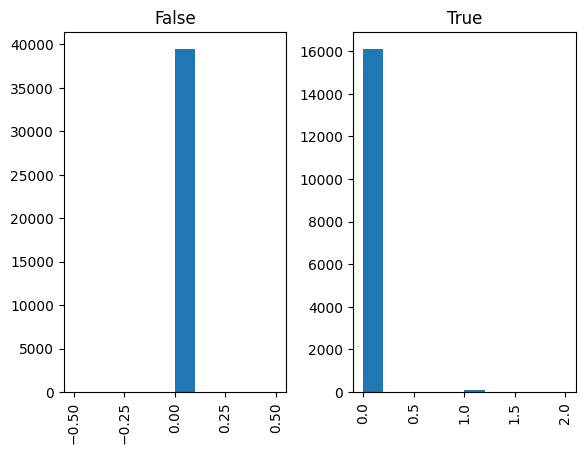

In [128]:
print(data_analysis.groupby('Defeitos')['S126'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S126'].describe(include='all')))

data_analysis['S126'].describe(include='all')
data_analysis.hist(column='S126', by='Defeitos')

Defeitos  S127
False     0.0     39443
True      0.0     15824
          1.0       302
          2.0        60
          3.0         1
          4.0         1
Name: S127, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.007712
std          0.100662
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: S127, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

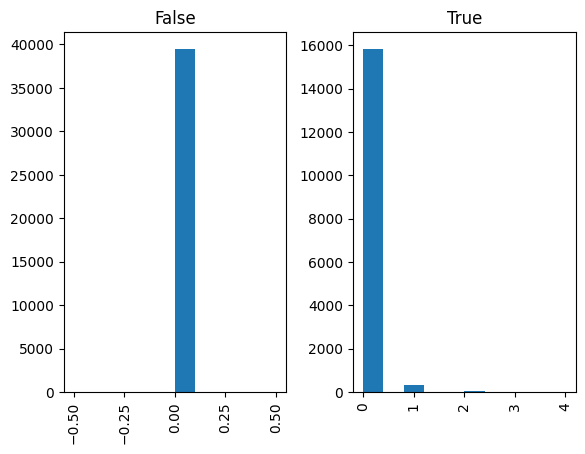

In [129]:
print(data_analysis.groupby('Defeitos')['S127'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S127'].describe(include='all')))

data_analysis['S127'].describe(include='all')
data_analysis.hist(column='S127', by='Defeitos')

Defeitos  S128
False     0.0     39442
          1.0         1
True      0.0     14446
          1.0      1432
          2.0       296
          3.0        10
          4.0         4
Name: S128, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.037227
std          0.220058
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: S128, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

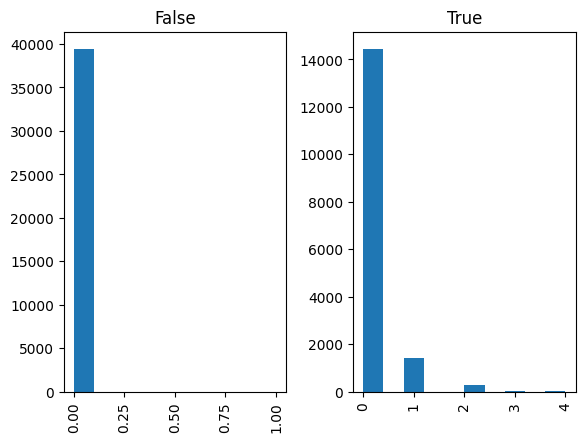

In [130]:
print(data_analysis.groupby('Defeitos')['S128'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S128'].describe(include='all')))

data_analysis['S128'].describe(include='all')
data_analysis.hist(column='S128', by='Defeitos')

Defeitos  S129
False     0.0     39443
True      0.0     16188
Name: S129, dtype: int64

Formatação das variaveis: 
count    55631.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: S129, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

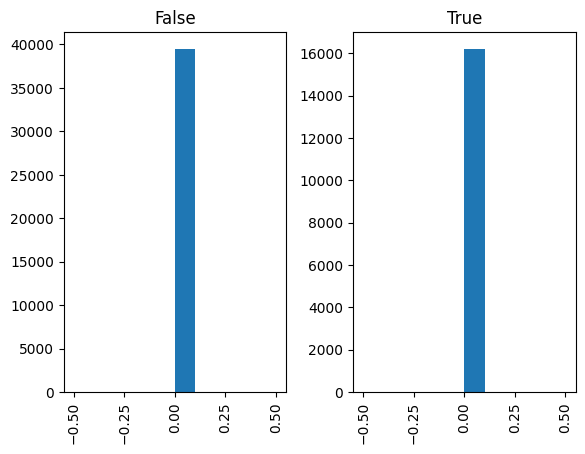

In [131]:
print(data_analysis.groupby('Defeitos')['S129'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S129'].describe(include='all')))

data_analysis['S129'].describe(include='all')
data_analysis.hist(column='S129', by='Defeitos')

Defeitos  S130
False     0.0     39432
          1.0        11
True      0.0     16181
          1.0         7
Name: S130, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.000324
std          0.017985
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: S130, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

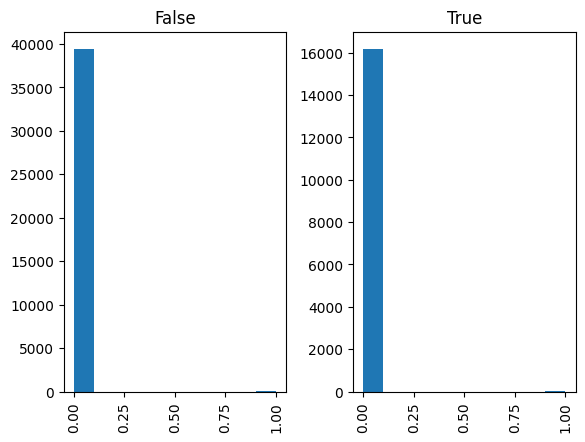

In [132]:
print(data_analysis.groupby('Defeitos')['S130'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S130'].describe(include='all')))

data_analysis['S130'].describe(include='all')
data_analysis.hist(column='S130', by='Defeitos')

Defeitos  S131
False     0.0     39443
True      0.0     16185
          1.0         3
Name: S131, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.000054
std          0.007343
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: S131, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

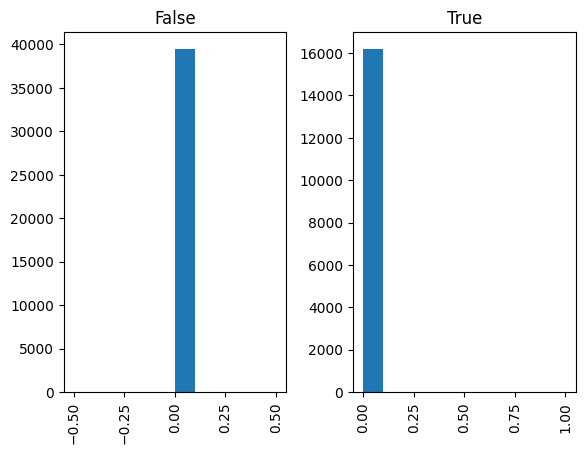

In [133]:
print(data_analysis.groupby('Defeitos')['S131'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S131'].describe(include='all')))

data_analysis['S131'].describe(include='all')
data_analysis.hist(column='S131', by='Defeitos')

Defeitos  S134
False     0.0     39443
True      0.0     16188
Name: S134, dtype: int64

Formatação das variaveis: 
count    55631.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: S134, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

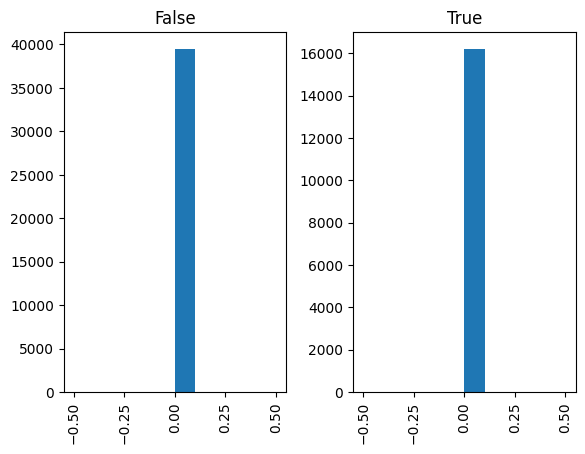

In [134]:
print(data_analysis.groupby('Defeitos')['S134'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S134'].describe(include='all')))

data_analysis['S134'].describe(include='all')
data_analysis.hist(column='S134', by='Defeitos')

Defeitos  S135
False     0.0     39443
True      0.0     16172
          1.0        16
Name: S135, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.000288
std          0.016957
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: S135, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

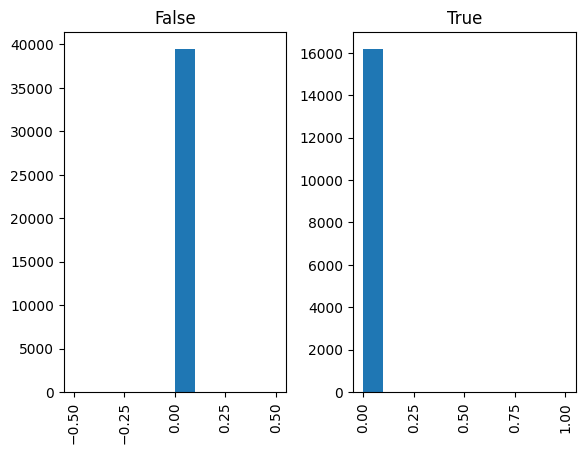

In [135]:
print(data_analysis.groupby('Defeitos')['S135'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S135'].describe(include='all')))

data_analysis['S135'].describe(include='all')
data_analysis.hist(column='S135', by='Defeitos')

Defeitos  S136
False     0.0     39441
          1.0         2
True      0.0     16139
          1.0        46
          2.0         3
Name: S136, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.000971
std          0.032827
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: S136, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

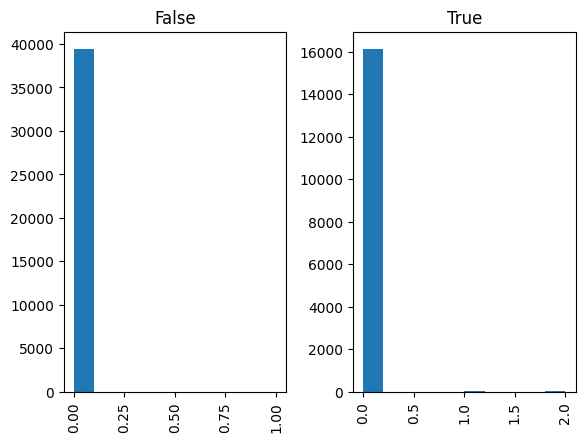

In [136]:
print(data_analysis.groupby('Defeitos')['S136'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S136'].describe(include='all')))

data_analysis['S136'].describe(include='all')
data_analysis.hist(column='S136', by='Defeitos')

Defeitos  S137
False     0.0     39441
          1.0         2
True      0.0     16183
          1.0         5
Name: S137, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.000126
std          0.011217
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: S137, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

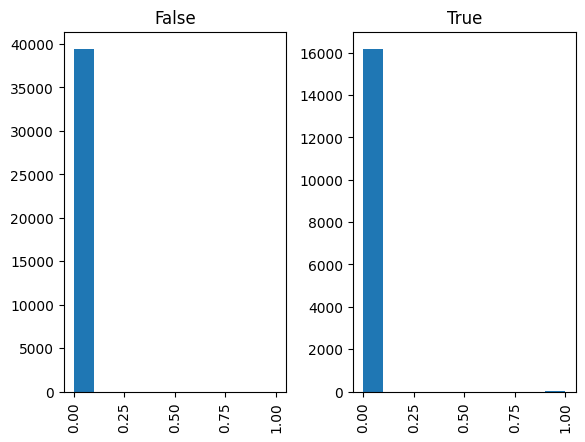

In [137]:
print(data_analysis.groupby('Defeitos')['S137'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S137'].describe(include='all')))

data_analysis['S137'].describe(include='all')
data_analysis.hist(column='S137', by='Defeitos')

Defeitos  S138
False     0.0     39443
True      0.0     16186
          1.0         2
Name: S138, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.000036
std          0.005996
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: S138, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

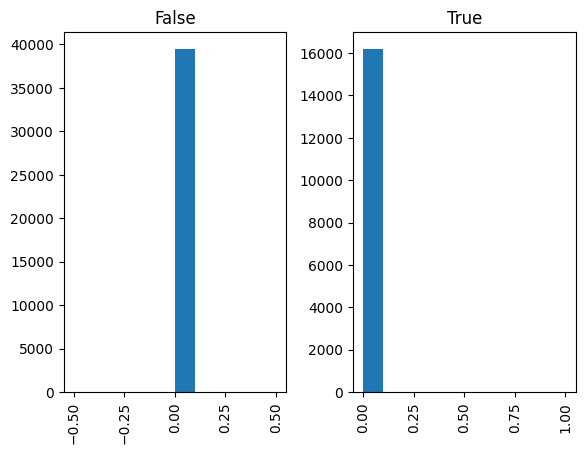

In [138]:
print(data_analysis.groupby('Defeitos')['S138'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S138'].describe(include='all')))

data_analysis['S138'].describe(include='all')
data_analysis.hist(column='S138', by='Defeitos')

Defeitos  S141
False     0.0     39443
True      0.0     16187
          1.0         1
Name: S141, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.000018
std          0.004240
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: S141, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

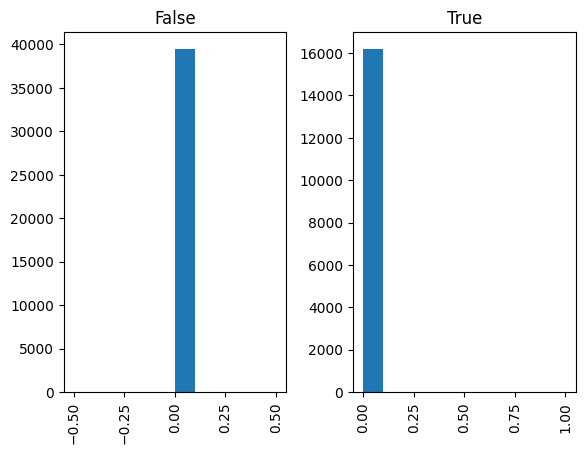

In [139]:
print(data_analysis.groupby('Defeitos')['S141'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S141'].describe(include='all')))

data_analysis['S141'].describe(include='all')
data_analysis.hist(column='S141', by='Defeitos')

Defeitos  S142
False     0.0     39443
True      0.0     16186
          1.0         2
Name: S142, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.000036
std          0.005996
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: S142, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

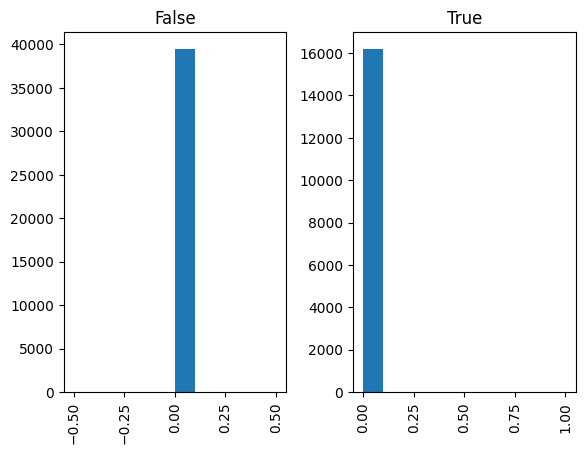

In [140]:
print(data_analysis.groupby('Defeitos')['S142'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S142'].describe(include='all')))

data_analysis['S142'].describe(include='all')
data_analysis.hist(column='S142', by='Defeitos')

Defeitos  S143
False     0.0     39443
True      0.0     16186
          1.0         2
Name: S143, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.000036
std          0.005996
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: S143, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

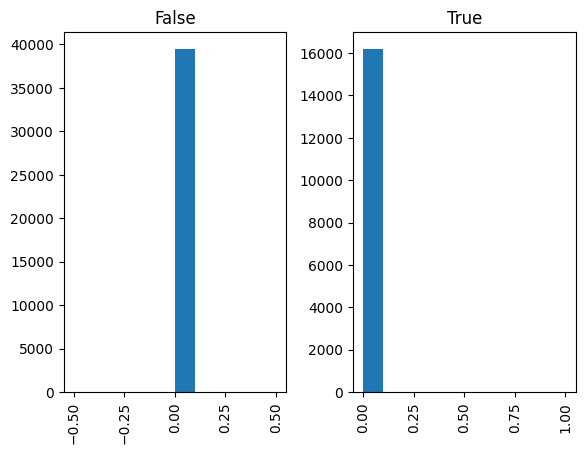

In [141]:
print(data_analysis.groupby('Defeitos')['S143'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S143'].describe(include='all')))

data_analysis['S143'].describe(include='all')
data_analysis.hist(column='S143', by='Defeitos')

Defeitos  S144
False     0.0     39442
          1.0         1
True      0.0     16188
Name: S144, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.000018
std          0.004240
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: S144, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

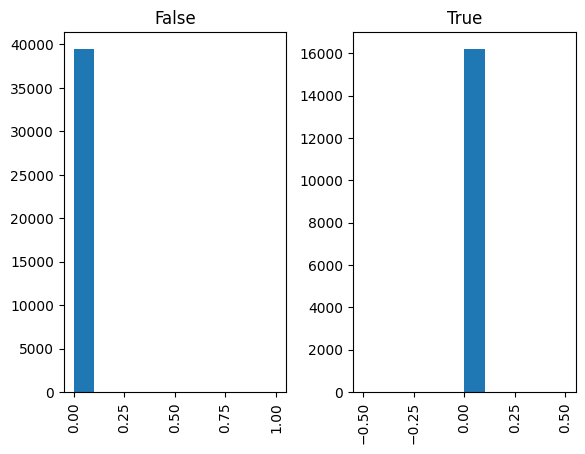

In [142]:
print(data_analysis.groupby('Defeitos')['S144'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S144'].describe(include='all')))

data_analysis['S144'].describe(include='all')
data_analysis.hist(column='S144', by='Defeitos')

Defeitos  S145
False     0.0     39432
          1.0        11
True      0.0     16106
          1.0        67
          2.0        15
Name: S145, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.001941
std          0.049769
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: S145, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

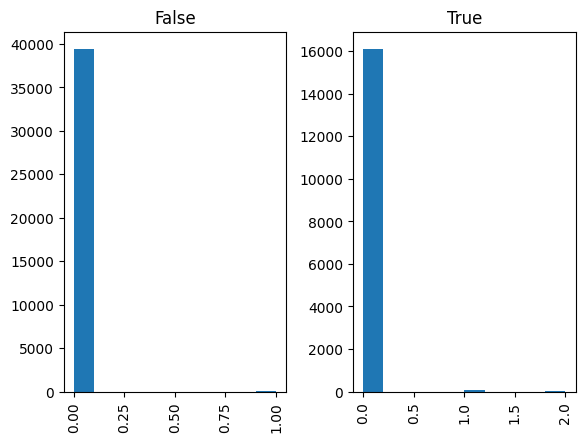

In [143]:
print(data_analysis.groupby('Defeitos')['S145'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S145'].describe(include='all')))

data_analysis['S145'].describe(include='all')
data_analysis.hist(column='S145', by='Defeitos')

Defeitos  S146
False     0.0     39433
          1.0        10
True      0.0     16160
          1.0        27
          2.0         1
Name: S146, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.000701
std          0.027139
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: S146, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

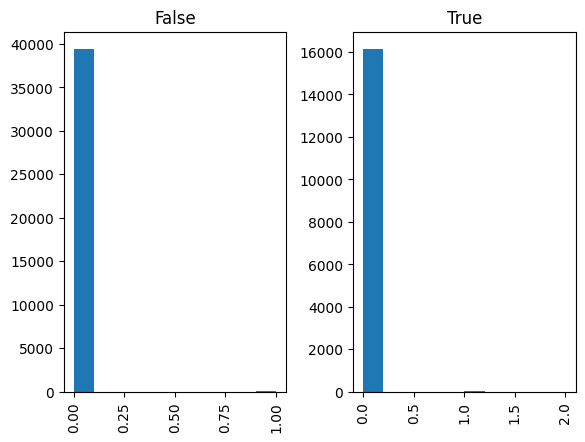

In [144]:
print(data_analysis.groupby('Defeitos')['S146'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S146'].describe(include='all')))

data_analysis['S146'].describe(include='all')
data_analysis.hist(column='S146', by='Defeitos')

Defeitos  S147
False     0.0     39443
True      0.0     16061
          1.0        84
          2.0        38
          3.0         4
          4.0         1
Name: S147, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.003164
std          0.071882
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: S147, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

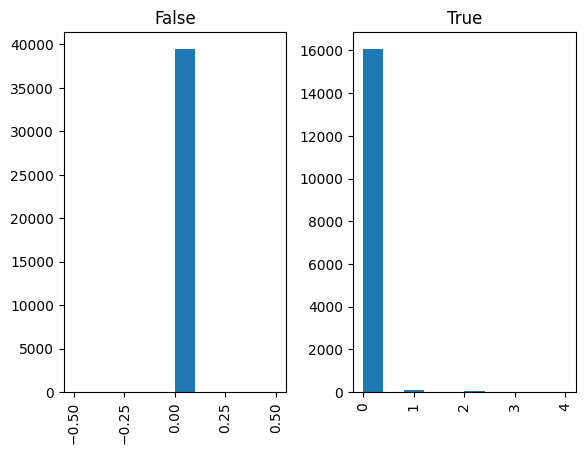

In [145]:
print(data_analysis.groupby('Defeitos')['S147'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S147'].describe(include='all')))

data_analysis['S147'].describe(include='all')
data_analysis.hist(column='S147', by='Defeitos')

Defeitos  S148
False     0.0     39443
True      0.0     15962
          1.0       160
          2.0        63
          3.0         2
          4.0         1
Name: S148, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.005321
std          0.089381
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: S148, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

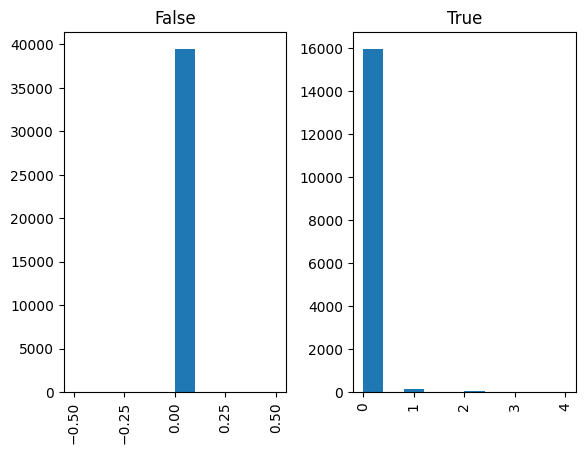

In [146]:
print(data_analysis.groupby('Defeitos')['S148'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S148'].describe(include='all')))

data_analysis['S148'].describe(include='all')
data_analysis.hist(column='S148', by='Defeitos')

Defeitos  S149
False     0.0     39443
True      0.0     15839
          1.0       345
          2.0         4
Name: S149, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.006345
std          0.080306
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: S149, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

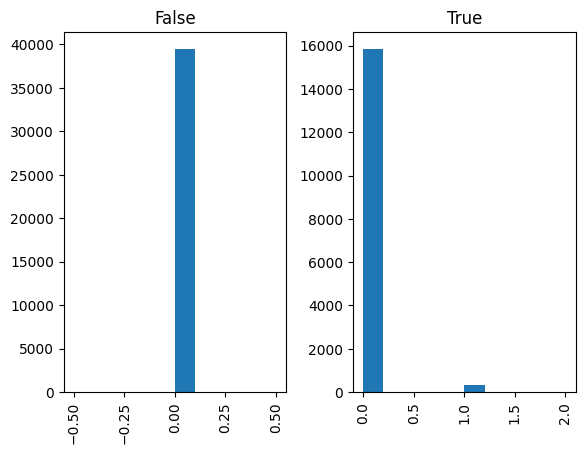

In [147]:
print(data_analysis.groupby('Defeitos')['S149'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S149'].describe(include='all')))

data_analysis['S149'].describe(include='all')
data_analysis.hist(column='S149', by='Defeitos')

Defeitos  S150
False     0.0     39321
          1.0       122
True      0.0     12307
          1.0      3574
          2.0       292
          3.0         8
          4.0         6
          5.0         1
Name: S150, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.077888
std          0.291269
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          5.000000
Name: S150, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

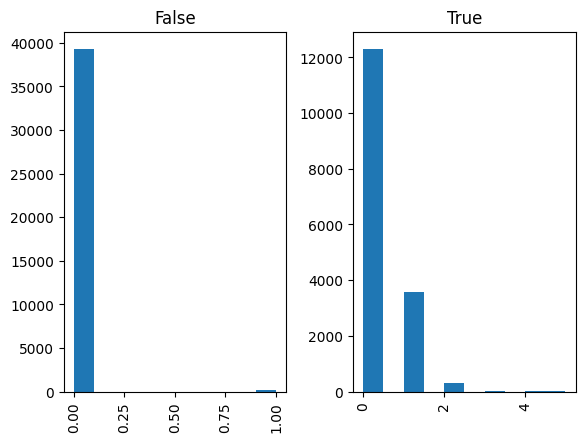

In [148]:
print(data_analysis.groupby('Defeitos')['S150'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S150'].describe(include='all')))

data_analysis['S150'].describe(include='all')
data_analysis.hist(column='S150', by='Defeitos')

Defeitos  S152
False     0.0     39443
True      0.0     16187
          1.0         1
Name: S152, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.000018
std          0.004240
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: S152, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

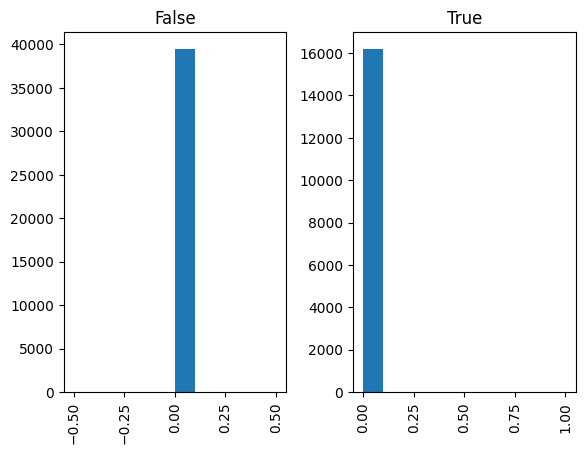

In [149]:
print(data_analysis.groupby('Defeitos')['S152'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S152'].describe(include='all')))

data_analysis['S152'].describe(include='all')
data_analysis.hist(column='S152', by='Defeitos')

Defeitos  S155
False     0.0     39443
True      0.0     15858
          1.0       327
          2.0         3
Name: S155, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.005986
std          0.077833
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: S155, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

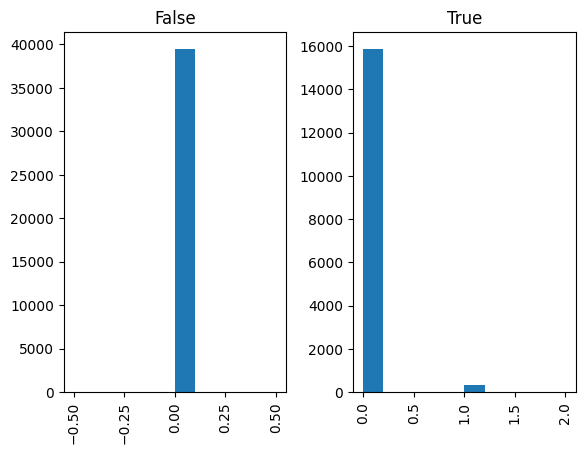

In [150]:
print(data_analysis.groupby('Defeitos')['S155'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S155'].describe(include='all')))

data_analysis['S155'].describe(include='all')
data_analysis.hist(column='S155', by='Defeitos')

Defeitos  S156
False     0.0     37455
          1.0      1988
True      0.0     14059
          1.0      2113
          2.0        11
          4.0         4
          3.0         1
Name: S156, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.074455
std          0.265101
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: S156, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

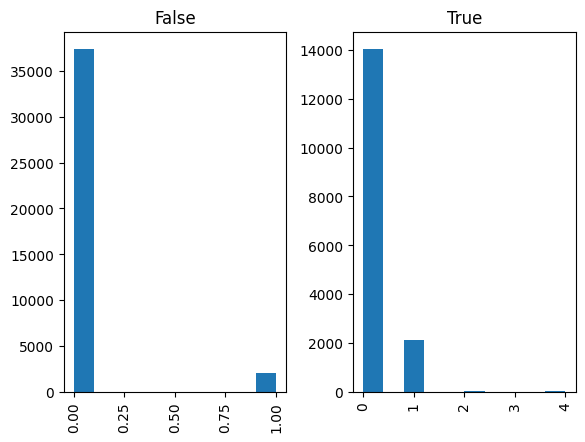

In [151]:
print(data_analysis.groupby('Defeitos')['S156'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S156'].describe(include='all')))

data_analysis['S156'].describe(include='all')
data_analysis.hist(column='S156', by='Defeitos')

Defeitos  S158
False     0.0     39443
True      0.0     16165
          1.0        21
          2.0         2
Name: S158, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.000449
std          0.022828
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: S158, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

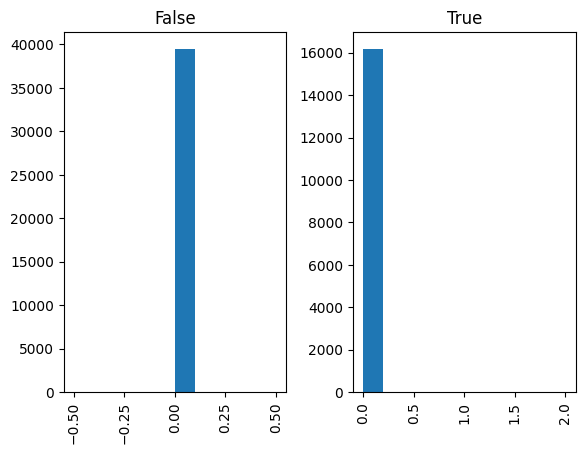

In [152]:
print(data_analysis.groupby('Defeitos')['S158'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S158'].describe(include='all')))

data_analysis['S158'].describe(include='all')
data_analysis.hist(column='S158', by='Defeitos')

Defeitos  S159
False     0.0     39442
          1.0         1
True      0.0     16140
          1.0        48
Name: S159, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.000881
std          0.029666
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: S159, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

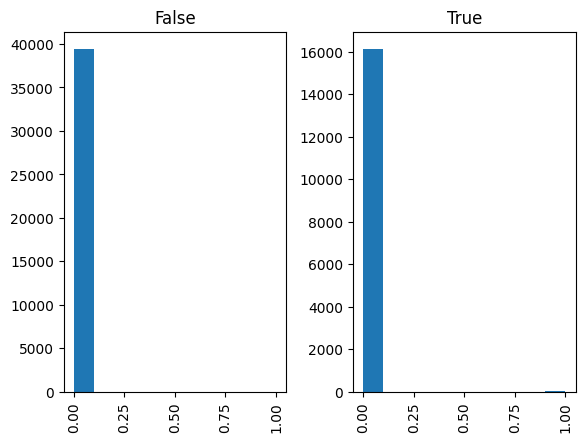

In [153]:
print(data_analysis.groupby('Defeitos')['S159'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S159'].describe(include='all')))

data_analysis['S159'].describe(include='all')
data_analysis.hist(column='S159', by='Defeitos')

Defeitos  S161
False     0.0     39443
True      0.0     16188
Name: S161, dtype: int64

Formatação das variaveis: 
count    55631.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: S161, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

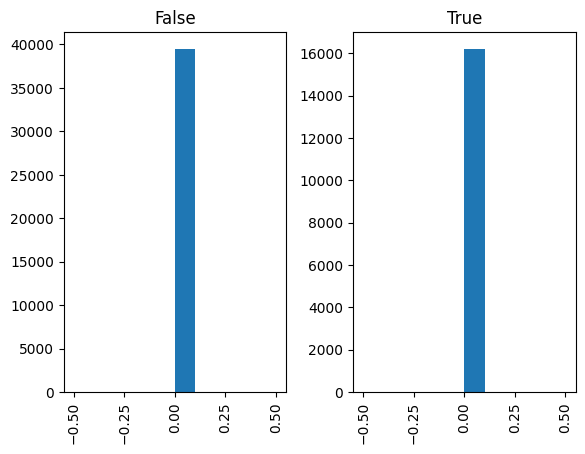

In [154]:
print(data_analysis.groupby('Defeitos')['S161'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S161'].describe(include='all')))

data_analysis['S161'].describe(include='all')
data_analysis.hist(column='S161', by='Defeitos')

Defeitos  S162
False     0.0     39441
          1.0         2
True      0.0     15099
          1.0       931
          2.0       148
          3.0         7
          4.0         2
          5.0         1
Name: S162, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.022703
std          0.170455
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          5.000000
Name: S162, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

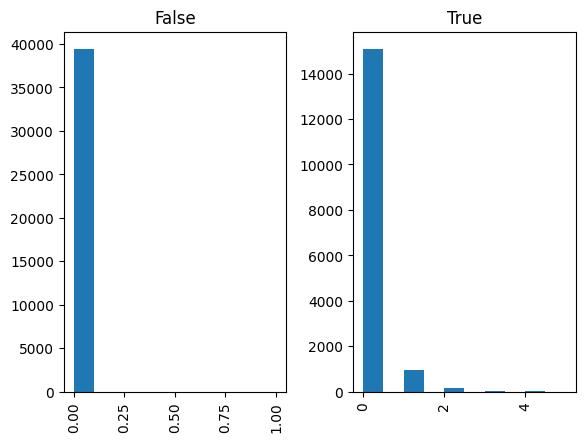

In [155]:
print(data_analysis.groupby('Defeitos')['S162'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S162'].describe(include='all')))

data_analysis['S162'].describe(include='all')
data_analysis.hist(column='S162', by='Defeitos')

Defeitos  S163
False     0.0     39443
True      0.0     16184
          2.0         3
          4.0         1
Name: S163, dtype: int64

Formatação das variaveis: 
count    55631.000000
mean         0.000180
std          0.022434
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: S163, dtype: float64



array([<Axes: title={'center': 'False'}>,
       <Axes: title={'center': 'True'}>], dtype=object)

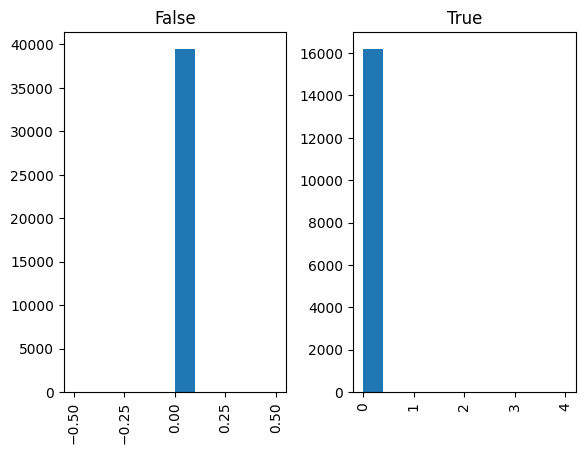

In [156]:
print(data_analysis.groupby('Defeitos')['S163'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['S163'].describe(include='all')))

data_analysis['S163'].describe(include='all')
data_analysis.hist(column='S163', by='Defeitos')

####ANALISE DE TEMPOS

#####KR


Formatação das variaveis: 
count    55631.000000
mean        31.518200
std          6.934243
min          0.000000
25%         28.000000
50%         31.000000
75%         34.000000
max         59.000000
Name: KR_TOTAL_TIME, dtype: float64



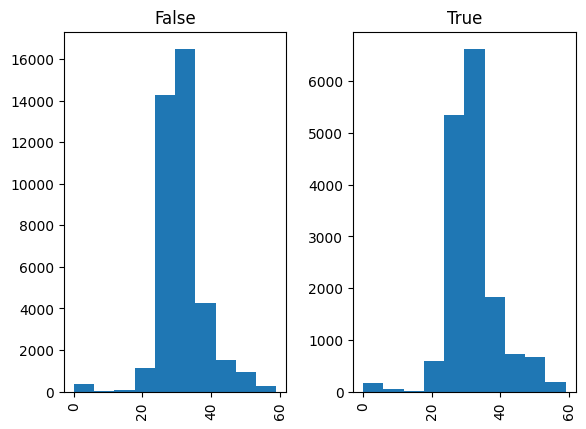

In [329]:
data_analysis.hist(column='KR_TOTAL_TIME', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['KR_TOTAL_TIME'].describe(include='all')))


Formatação das variaveis: 
count    55631.000000
mean        14.276626
std          5.561265
min          0.000000
25%         12.000000
50%         13.000000
75%         15.000000
max         58.000000
Name: KR_PROCESS_TIME, dtype: float64



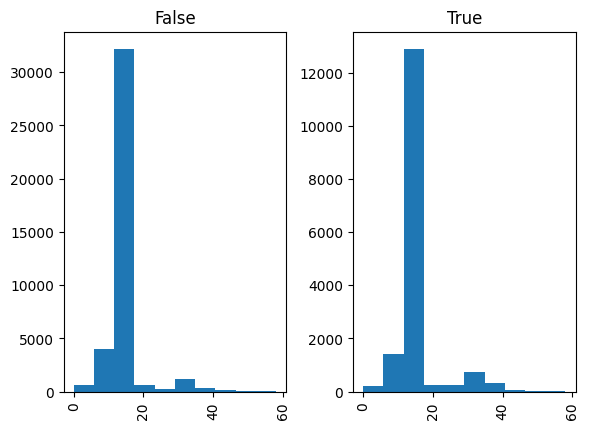

In [331]:
data_analysis.hist(column='KR_PROCESS_TIME', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['KR_PROCESS_TIME'].describe(include='all')))


Formatação das variaveis: 
count    55631.000000
mean         6.614909
std          3.461416
min        -45.000000
25%          5.000000
50%          6.000000
75%          8.000000
max         43.000000
Name: KR_WAIT_START_TIME, dtype: float64



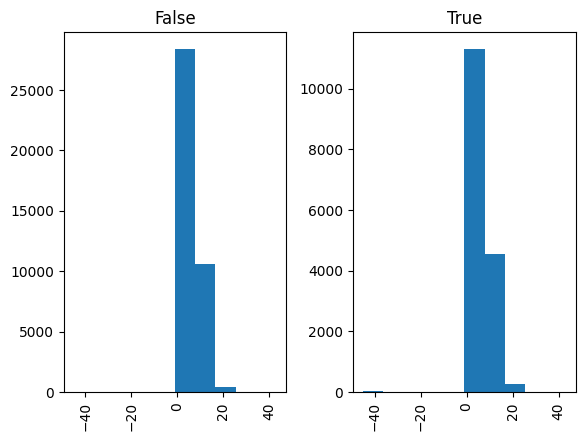

In [333]:
data_analysis.hist(column='KR_WAIT_START_TIME', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['KR_WAIT_START_TIME'].describe(include='all')))


Formatação das variaveis: 
count    55631.000000
mean         9.806726
std          3.905844
min          0.000000
25%          8.000000
50%          9.000000
75%         11.000000
max         44.000000
Name: KR_WAIT_DEPARTUE_TIME, dtype: float64



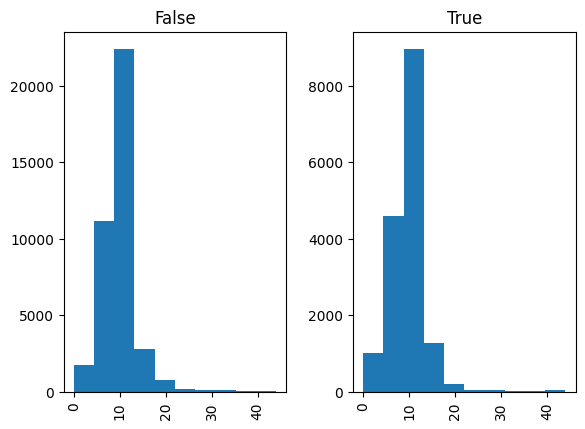

In [335]:
data_analysis.hist(column='KR_WAIT_DEPARTUE_TIME', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['KR_WAIT_DEPARTUE_TIME'].describe(include='all')))

#####BOF


Formatação das variaveis: 
count    55631.000000
mean        22.384534
std          4.995148
min          0.000000
25%         20.000000
50%         22.000000
75%         24.000000
max         54.000000
Name: BOF_BLW_TIME, dtype: float64



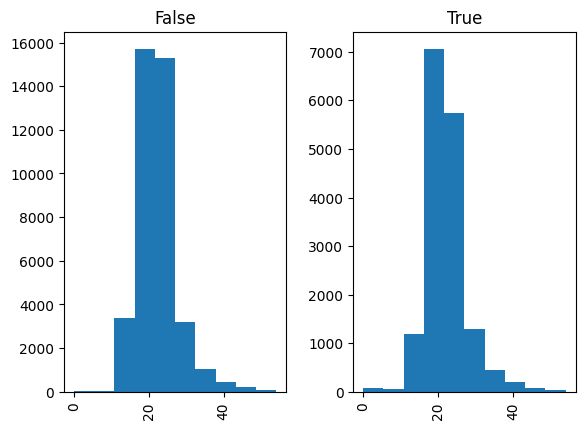

In [341]:
data_analysis.hist(column='BOF_BLW_TIME', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['BOF_BLW_TIME'].describe(include='all')))


Formatação das variaveis: 
count    55631.000000
mean         6.489889
std          1.931508
min          0.000000
25%          5.000000
50%          6.000000
75%          8.000000
max         21.000000
Name: BOF_TAP_TIME, dtype: float64



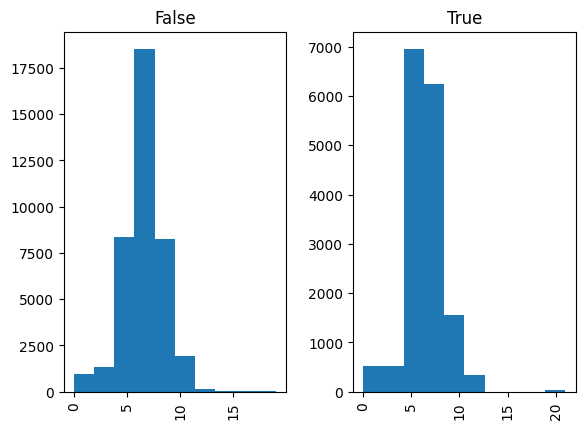

In [342]:
data_analysis.hist(column='BOF_TAP_TIME', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['BOF_TAP_TIME'].describe(include='all')))

#####BAP


Formatação das variaveis: 
count    55631.000000
mean         4.018191
std          3.989960
min          0.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         55.000000
Name: BAP_TOTAL_TIME, dtype: float64



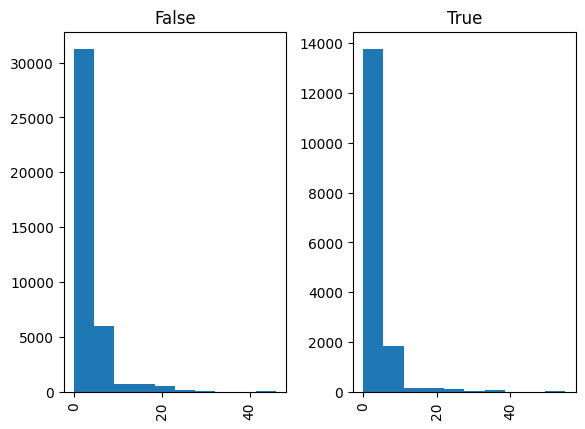

In [344]:
data_analysis.hist(column='BAP_TOTAL_TIME', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['BAP_TOTAL_TIME'].describe(include='all')))


Formatação das variaveis: 
count    55631.000000
mean         1.290054
std          2.484160
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max         26.000000
Name: BAP_PROCESS_TIME, dtype: float64



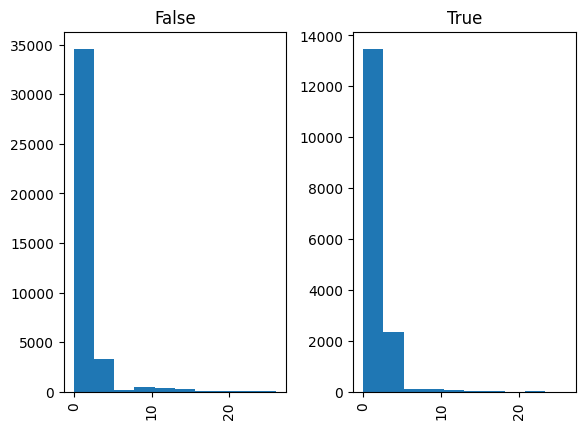

In [345]:
data_analysis.hist(column='BAP_PROCESS_TIME', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['BAP_PROCESS_TIME'].describe(include='all')))


Formatação das variaveis: 
count    55631.000000
mean         0.110909
std          0.775892
min         -6.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         20.000000
Name: BAP_WAIT_START_TIME, dtype: float64



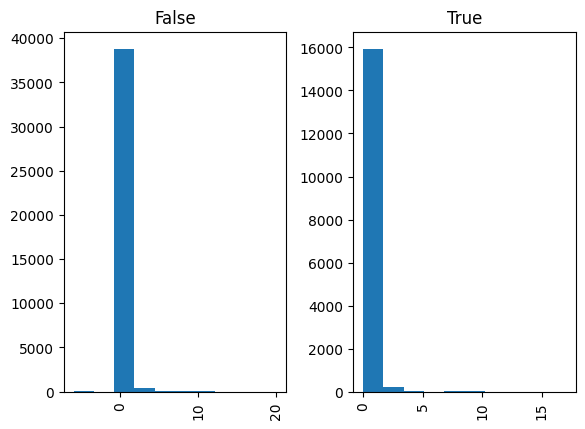

In [346]:
data_analysis.hist(column='BAP_WAIT_START_TIME', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['BAP_WAIT_START_TIME'].describe(include='all')))


Formatação das variaveis: 
count    55631.000000
mean         1.277795
std          2.711236
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max         52.000000
Name: BAP_WAIT_DEPARTUE_TIME, dtype: float64



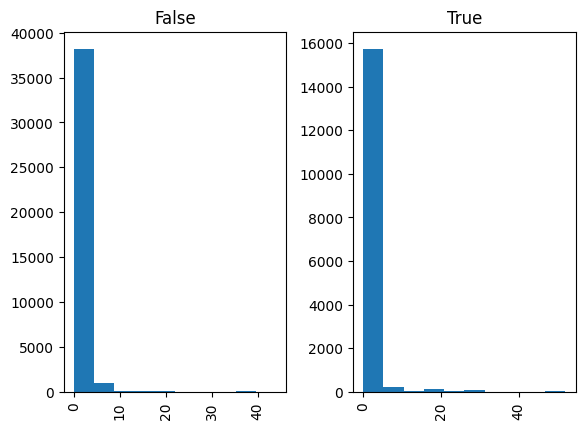

In [351]:
data_analysis.hist(column='BAP_WAIT_DEPARTUE_TIME', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['BAP_WAIT_DEPARTUE_TIME'].describe(include='all')))


Formatação das variaveis: 
count    55631.000000
mean         1.643177
std          2.577600
min          0.000000
25%          0.000000
50%          1.200000
75%          2.000000
max         26.100000
Name: BAP_RSLT_TIME, dtype: float64



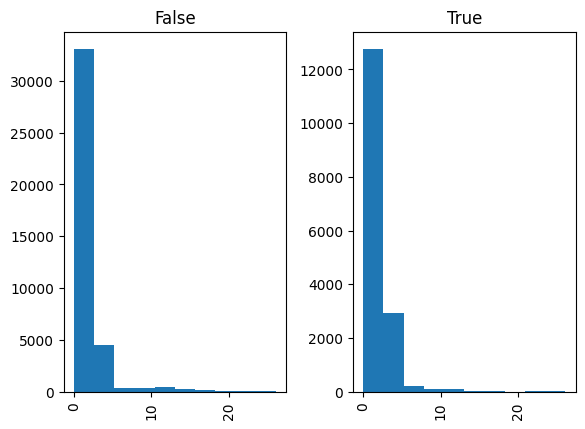

In [352]:
data_analysis.hist(column='BAP_RSLT_TIME', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['BAP_RSLT_TIME'].describe(include='all')))


Formatação das variaveis: 
count    55631.000000
mean         0.946249
std          1.439946
min          0.000000
25%          0.000000
50%          0.000000
75%          1.800000
max         15.100000
Name: BAP_TOP_BB_TOT_DUR, dtype: float64



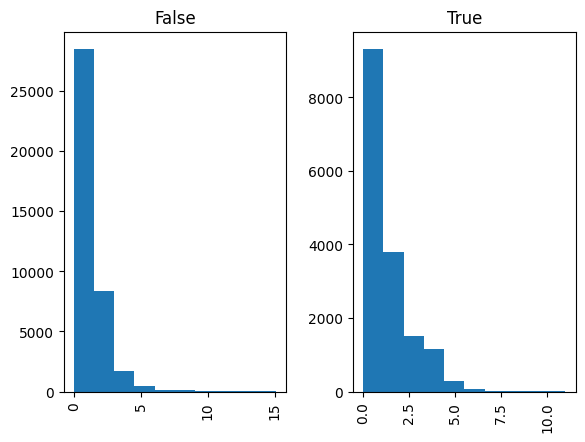

In [349]:
data_analysis.hist(column='BAP_TOP_BB_TOT_DUR', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['BAP_TOP_BB_TOT_DUR'].describe(include='all')))


Formatação das variaveis: 
count    55631.000000
mean         0.758365
std          1.336745
min          0.000000
25%          0.000000
50%          0.000000
75%          1.100000
max         21.300000
Name: BAP_BTM_BB_TOT_DUR, dtype: float64



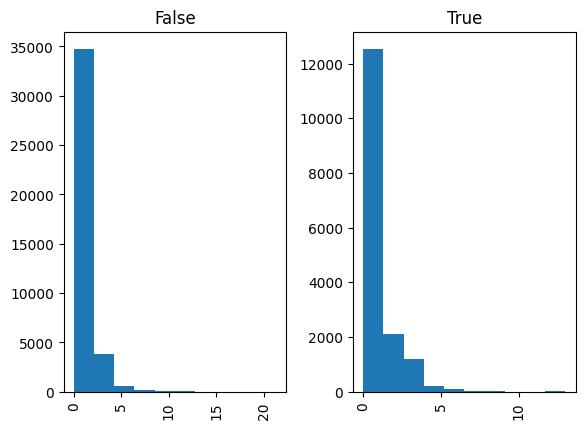

In [350]:
data_analysis.hist(column='BAP_BTM_BB_TOT_DUR', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['BAP_BTM_BB_TOT_DUR'].describe(include='all')))

#####RH


Formatação das variaveis: 
count    55631.000000
mean        17.977495
std         10.200353
min          0.000000
25%         15.000000
50%         18.000000
75%         23.000000
max         59.000000
Name: RH_TOTAL_TIME, dtype: float64



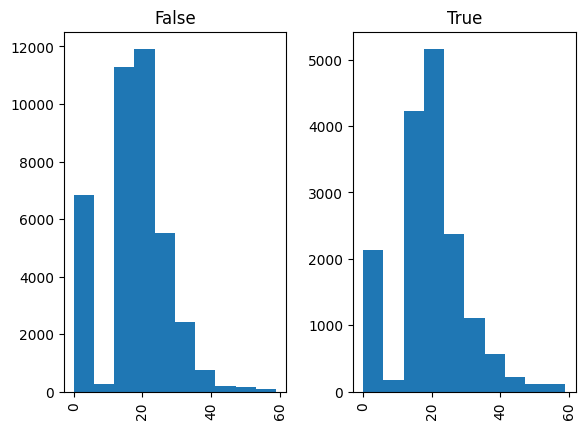

In [353]:
data_analysis.hist(column='RH_TOTAL_TIME', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['RH_TOTAL_TIME'].describe(include='all')))


Formatação das variaveis: 
count    55631.000000
mean        12.277489
std          8.585736
min          0.000000
25%          8.000000
50%         11.000000
75%         16.000000
max         55.000000
Name: RH_PROCESS_TIME, dtype: float64



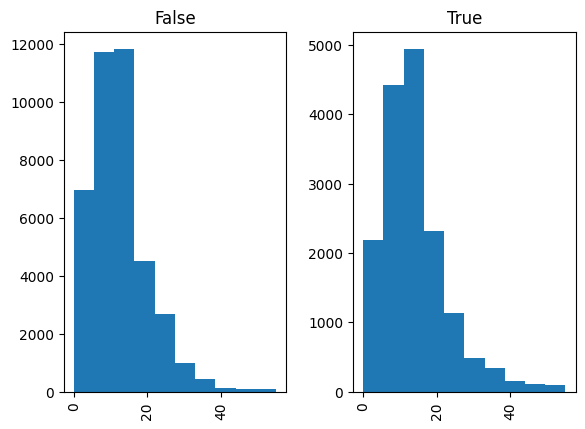

In [357]:
data_analysis.hist(column='RH_PROCESS_TIME', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['RH_PROCESS_TIME'].describe(include='all')))


Formatação das variaveis: 
count    55631.000000
mean         1.280311
std          1.115260
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         15.000000
Name: RH_WAIT_START_TIME, dtype: float64



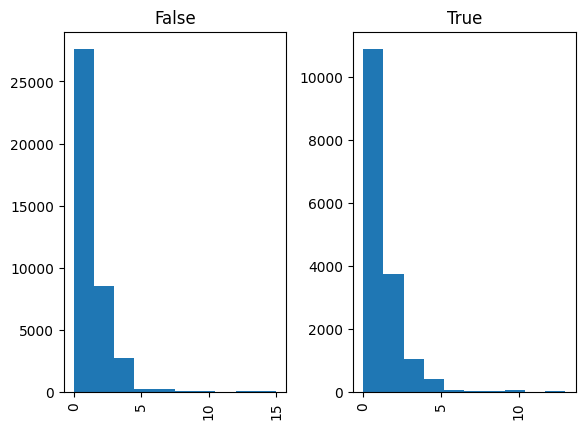

In [355]:
data_analysis.hist(column='RH_WAIT_START_TIME', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['RH_WAIT_START_TIME'].describe(include='all')))


Formatação das variaveis: 
count    55631.000000
mean         3.673276
std          2.808782
min          0.000000
25%          2.000000
50%          3.000000
75%          6.000000
max         41.000000
Name: RH_WAIT_DEPARTUE_TIME, dtype: float64



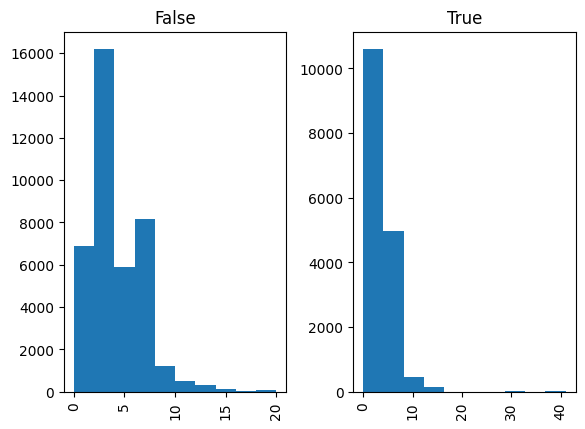

In [356]:
data_analysis.hist(column='RH_WAIT_DEPARTUE_TIME', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['RH_WAIT_DEPARTUE_TIME'].describe(include='all')))

#####LF

In [ ]:
data_analysis.hist(column='LF_TOTAL_TIME', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['LF_TOTAL_TIME'].describe(include='all')))


Formatação das variaveis: 
count    55631.000000
mean        10.393468
std         14.034236
min          0.000000
25%          0.000000
50%          0.000000
75%         21.000000
max         59.000000
Name: LF_PROCESS_TIME, dtype: float64



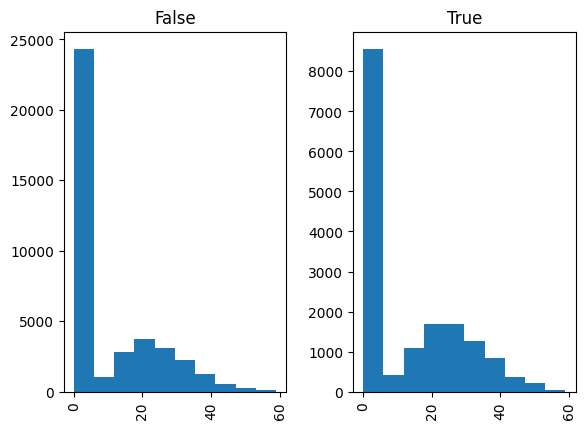

In [359]:
data_analysis.hist(column='LF_PROCESS_TIME', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['LF_PROCESS_TIME'].describe(include='all')))


Formatação das variaveis: 
count    55631.000000
mean         0.060632
std          0.881272
min        -35.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         23.000000
Name: LF_WAIT_START_TIME, dtype: float64



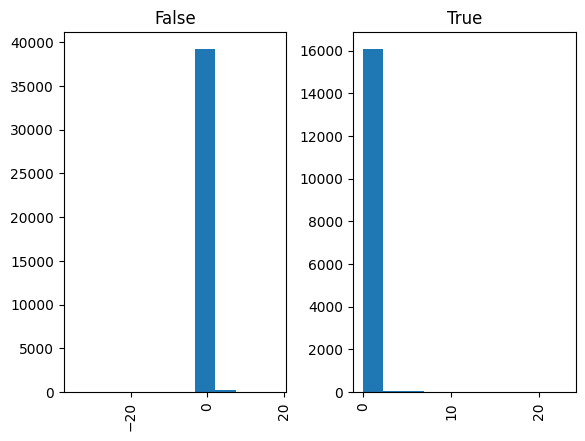

In [360]:
data_analysis.hist(column='LF_WAIT_START_TIME', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['LF_WAIT_START_TIME'].describe(include='all')))

In [ ]:
data_analysis.hist(column='LF_WAIT_DEPARTUE_TIME', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['LF_WAIT_DEPARTUE_TIME'].describe(include='all')))

#####CC

In [ ]:
data_analysis.hist(column='CC_TOTAL_TIME', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['CC_TOTAL_TIME'].describe(include='all')))

In [ ]:
data_analysis.hist(column='CC_PROCESS_TIME', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['CC_PROCESS_TIME'].describe(include='all')))

In [ ]:
data_analysis.hist(column='CC_WAIT_START_TIME', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['CC_WAIT_START_TIME'].describe(include='all')))

In [ ]:
data_analysis.hist(column='CC_WAIT_DEPARTUE_TIME', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['CC_WAIT_DEPARTUE_TIME'].describe(include='all')))

####ANALISE DE ROTAS

In [ ]:
print("Ocorrencia do evento sob defeitos: {0:.3f}%".format(data_analysis.groupby('Defeitos')['DESVIO_RH'].value_counts(dropna=False)[True][True].sum()/(data_analysis.groupby('Defeitos')['DESVIO_RH'].value_counts(dropna=False)[False][True].sum()+data_analysis.groupby('Defeitos')['DESVIO_RH'].value_counts(dropna=False)[True][True].sum())*100))
print("Não Ocorrencia do evento sob defeitos: {0:.3f}%\n".format(data_analysis.groupby('Defeitos')['DESVIO_RH'].value_counts(dropna=False)[False][True].sum()/(data_analysis.groupby('Defeitos')['DESVIO_RH'].value_counts(dropna=False)[False][True].sum()+data_analysis.groupby('Defeitos')['DESVIO_RH'].value_counts(dropna=False)[True][True].sum())*100))

print("Ocorrencia do eventos sob o total: {0:.3f}%\n".format(data_analysis.groupby('Defeitos')['DESVIO_RH'].value_counts(dropna=False)[True][True].sum()/(data_analysis.groupby('Defeitos')['DESVIO_RH'].value_counts(dropna=False)[False].sum()+data_analysis.groupby('Defeitos')['DESVIO_RH'].value_counts(dropna=False)[True].sum())*100))

print(data_analysis.groupby('Defeitos')['DESVIO_RH'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['DESVIO_RH'].describe(include='all')))

In [ ]:
print("Ocorrencia do evento sob defeitos: {0:.3f}%".format(data_analysis.groupby('Defeitos')['DESVIO_LF'].value_counts(dropna=False)[True][True].sum()/(data_analysis.groupby('Defeitos')['DESVIO_LF'].value_counts(dropna=False)[False][True].sum()+data_analysis.groupby('Defeitos')['DESVIO_LF'].value_counts(dropna=False)[True][True].sum())*100))
print("Não Ocorrencia do evento sob defeitos: {0:.3f}%\n".format(data_analysis.groupby('Defeitos')['DESVIO_LF'].value_counts(dropna=False)[False][True].sum()/(data_analysis.groupby('Defeitos')['DESVIO_LF'].value_counts(dropna=False)[False][True].sum()+data_analysis.groupby('Defeitos')['DESVIO_LF'].value_counts(dropna=False)[True][True].sum())*100))

print("Ocorrencia do eventos sob o total: {0:.3f}%\n".format(data_analysis.groupby('Defeitos')['DESVIO_LF'].value_counts(dropna=False)[True][True].sum()/(data_analysis.groupby('Defeitos')['DESVIO_LF'].value_counts(dropna=False)[False].sum()+data_analysis.groupby('Defeitos')['DESVIO_LF'].value_counts(dropna=False)[True].sum())*100))

print(data_analysis.groupby('Defeitos')['DESVIO_LF'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['DESVIO_LF'].describe(include='all')))

In [ ]:
print("Ocorrencia do eventos sob defeitos: {0:.3f}%".format(data_analysis.groupby('Defeitos')['ACT_DOUBLE_EQUIP_ROUTE_RH'].value_counts(dropna=False)[True][True].sum()/(data_analysis.groupby('Defeitos')['ACT_DOUBLE_EQUIP_ROUTE_RH'].value_counts(dropna=False)[False][True].sum()+data_analysis.groupby('Defeitos')['ACT_DOUBLE_EQUIP_ROUTE_RH'].value_counts(dropna=False)[True][True].sum())*100))
print("Não Ocorrencia do eventos sob defeitos: {0:.3f}%\n".format(data_analysis.groupby('Defeitos')['ACT_DOUBLE_EQUIP_ROUTE_RH'].value_counts(dropna=False)[False][True].sum()/(data_analysis.groupby('Defeitos')['ACT_DOUBLE_EQUIP_ROUTE_RH'].value_counts(dropna=False)[False][True].sum()+data_analysis.groupby('Defeitos')['ACT_DOUBLE_EQUIP_ROUTE_RH'].value_counts(dropna=False)[True][True].sum())*100))

print("Ocorrencia do eventos sob o total: {0:.3f}%\n".format(data_analysis.groupby('Defeitos')['ACT_DOUBLE_EQUIP_ROUTE_RH'].value_counts(dropna=False)[True][True].sum()/(data_analysis.groupby('Defeitos')['ACT_DOUBLE_EQUIP_ROUTE_RH'].value_counts(dropna=False)[False].sum()+data_analysis.groupby('Defeitos')['ACT_DOUBLE_EQUIP_ROUTE_RH'].value_counts(dropna=False)[True].sum())*100))
print(data_analysis.groupby('Defeitos')['ACT_DOUBLE_EQUIP_ROUTE_RH'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['ACT_DOUBLE_EQUIP_ROUTE_RH'].describe(include='all')))


In [ ]:
print("Ocorrencia do eventos sob defeitos: {0:.3f}%".format(data_analysis.groupby('Defeitos')['ACT_DOUBLE_EQUIP_ROUTE_LF'].value_counts(dropna=False)[True][True].sum()/(data_analysis.groupby('Defeitos')['ACT_DOUBLE_EQUIP_ROUTE_LF'].value_counts(dropna=False)[False][True].sum()+data_analysis.groupby('Defeitos')['ACT_DOUBLE_EQUIP_ROUTE_LF'].value_counts(dropna=False)[True][True].sum())*100))
print("Não Ocorrencia do eventos sob defeitos: {0:.3f}%\n".format(data_analysis.groupby('Defeitos')['ACT_DOUBLE_EQUIP_ROUTE_LF'].value_counts(dropna=False)[False][True].sum()/(data_analysis.groupby('Defeitos')['ACT_DOUBLE_EQUIP_ROUTE_LF'].value_counts(dropna=False)[False][True].sum()+data_analysis.groupby('Defeitos')['ACT_DOUBLE_EQUIP_ROUTE_LF'].value_counts(dropna=False)[True][True].sum())*100))

print("Ocorrencia do eventos sob o total: {0:.3f}%\n".format(data_analysis.groupby('Defeitos')['ACT_DOUBLE_EQUIP_ROUTE_LF'].value_counts(dropna=False)[True][True].sum()/(data_analysis.groupby('Defeitos')['ACT_DOUBLE_EQUIP_ROUTE_LF'].value_counts(dropna=False)[False].sum()+data_analysis.groupby('Defeitos')['ACT_DOUBLE_EQUIP_ROUTE_LF'].value_counts(dropna=False)[True].sum())*100))
print(data_analysis.groupby('Defeitos')['ACT_DOUBLE_EQUIP_ROUTE_LF'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['ACT_DOUBLE_EQUIP_ROUTE_LF'].describe(include='all')))

In [ ]:

print("Ocorrencia do eventos sob defeitos: {0:.3f}%".format(data_analysis.groupby('Defeitos')['DESVIO_ROTA'].value_counts(dropna=False)[True][True].sum()/(data_analysis.groupby('Defeitos')['DESVIO_ROTA'].value_counts(dropna=False)[False][True].sum()+data_analysis.groupby('Defeitos')['DESVIO_ROTA'].value_counts(dropna=False)[True][True].sum())*100))
print("Não Ocorrencia do eventos sob defeitos: {0:.3f}%\n".format(data_analysis.groupby('Defeitos')['DESVIO_ROTA'].value_counts(dropna=False)[False][True].sum()/(data_analysis.groupby('Defeitos')['DESVIO_ROTA'].value_counts(dropna=False)[False][True].sum()+data_analysis.groupby('Defeitos')['DESVIO_ROTA'].value_counts(dropna=False)[True][True].sum())*100))

print("Ocorrencia do eventos sob o total: {0:.3f}%\n".format(data_analysis.groupby('Defeitos')['DESVIO_ROTA'].value_counts(dropna=False)[True][True].sum()/(data_analysis.groupby('Defeitos')['DESVIO_ROTA'].value_counts(dropna=False)[False].sum()+data_analysis.groupby('Defeitos')['DESVIO_ROTA'].value_counts(dropna=False)[True].sum())*100))

print(data_analysis.groupby('Defeitos')['DESVIO_ROTA'].value_counts(dropna=False))
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['DESVIO_ROTA'].describe(include='all')))

####ANALISE DE PLANEJAMENTO

In [ ]:
data_analysis.hist(column='HEAT_SEQ_POSITION', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['HEAT_SEQ_POSITION'].describe(include='all')))

In [ ]:
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['cod_posit_cut'].describe(include='all')))
data_analysis.hist(column='cod_posit_cut', by='Defeitos')

####ANALISE DE RESULTADOS

In [ ]:
data_analysis.hist(column='HEAT_ACT_WGT', by='Defeitos')
print("Formatação das variaveis: \n{0}\n".format(data_analysis['HEAT_ACT_WGT'].describe(include='all')))

In [ ]:
data_analysis.hist(column='cod_bap_process', by='Defeitos')
print("\nFormatação das variaveis: \n{0}\n".format(data_analysis['cod_bap_process'].describe(include='all')))

In [ ]:
data_analysis.hist(column='TAPER_REDUCAO', by='Defeitos')
print("Formatação das variaveis: \n{0}\n".format(data_analysis['TAPER_REDUCAO'].describe(include='all')))

In [ ]:
data_analysis.hist(column='cod_taper', by='Defeitos')
print("Formatação das variaveis: \n{0}\n".format(data_analysis['cod_taper'].describe(include='all')))

In [ ]:
data_analysis.hist(column='TD_STEEL_SUPERH_DGR', by='Defeitos')
print("Formatação das variaveis: \n{0}\n".format(data_analysis['TD_STEEL_SUPERH_DGR'].describe(include='all')))

In [ ]:
data_analysis.hist(column='TD_AVG_TEMP', by='Defeitos')
print("Formatação das variaveis: \n{0}\n".format(data_analysis['TD_AVG_TEMP'].describe(include='all')))

In [ ]:
data_analysis.hist(column='TD_STEEL_WGT', by='Defeitos')
print("Formatação das variaveis: \n{0}\n".format(data_analysis['TD_STEEL_WGT'].describe(include='all')))

In [ ]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['CAST_MIN_SPD'].describe(include='all')))
data_analysis.hist(column='CAST_MIN_SPD', by='Defeitos')

In [ ]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['CAST_MAX_SPD'].describe(include='all')))
data_analysis.hist(column='CAST_MAX_SPD', by='Defeitos')

In [ ]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['CAST_AVG_SPD'].describe(include='all')))
data_analysis.hist(column='CAST_AVG_SPD', by='Defeitos')

In [ ]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['MLD_OSCILL_GAP'].describe(include='all')))
data_analysis.hist(column='MLD_OSCILL_GAP', by='Defeitos')

In [ ]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['CAST_IN_CAST_SPD_CHG_VAL'].describe(include='all')))
data_analysis.hist(column='CAST_IN_CAST_SPD_CHG_VAL', by='Defeitos')

In [ ]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['BAP_TOP_BB_TOT_CNT'].describe(include='all')))
data_analysis.hist(column='BAP_TOP_BB_TOT_CNT', by='Defeitos')

In [ ]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['BAP_BTM_BB_TOT_CNT'].describe(include='all')))
data_analysis.hist(column='BAP_BTM_BB_TOT_CNT', by='Defeitos')

In [ ]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['BAP_TEMPERATURA_SAIDA'].describe(include='all')))
data_analysis.hist(column='BAP_TEMPERATURA_SAIDA', by='Defeitos')

In [ ]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['BAP_PI_USED_CNT'].describe(include='all')))
data_analysis.hist(column='BAP_PI_USED_CNT', by='Defeitos')

In [ ]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['BAP_VOLUME_ARGONIO'].describe(include='all')))
data_analysis.hist(column='BAP_VOLUME_ARGONIO', by='Defeitos')

In [ ]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['BAP_VOLUME_N2'].describe(include='all')))
data_analysis.hist(column='BAP_VOLUME_N2', by='Defeitos')

In [ ]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['CAST_IN_LD_STEEL_WGT'].describe(include='all')))
data_analysis.hist(column='CAST_IN_LD_STEEL_WGT', by='Defeitos')

In [ ]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['MLD_TAPR_RGT_CHG_VAL'].describe(include='all')))
data_analysis.hist(column='MLD_TAPR_RGT_CHG_VAL', by='Defeitos')

In [ ]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['MLD_TAPR_LFT_CHG_VAL'].describe(include='all')))
data_analysis.hist(column='MLD_TAPR_LFT_CHG_VAL', by='Defeitos')

In [ ]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['RGT_MD_TAPR_RATE'].describe(include='all')))
data_analysis.hist(column='RGT_MD_TAPR_RATE', by='Defeitos')

In [ ]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['LFT_MD_TAPR_RATE'].describe(include='all')))
data_analysis.hist(column='LFT_MD_TAPR_RATE', by='Defeitos')

In [ ]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['TD_SLID_NZ_MAX_OPEN'].describe(include='all')))
data_analysis.hist(column='TD_SLID_NZ_MAX_OPEN', by='Defeitos')

In [ ]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['TD_SLID_NZ_MIN_OPEN'].describe(include='all')))
data_analysis.hist(column='TD_SLID_NZ_MIN_OPEN', by='Defeitos')

In [ ]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['TD_SLID_GATE_OPEN_QTY'].describe(include='all')))
data_analysis.hist(column='TD_SLID_GATE_OPEN_QTY', by='Defeitos')

In [ ]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['TD_SLID_NZ_OPEN_VAR_RATE'].describe(include='all')))
data_analysis.hist(column='TD_SLID_NZ_OPEN_VAR_RATE', by='Defeitos')   

In [ ]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['MLD_WIDE_IS_CW_TEMP_DIFF'].describe(include='all')))
data_analysis.hist(column='MLD_WIDE_IS_CW_TEMP_DIFF', by='Defeitos')   

In [ ]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['MLD_NARW_LFT_CW_TEMP_DIFF'].describe(include='all')))
data_analysis.hist(column='MLD_NARW_LFT_CW_TEMP_DIFF', by='Defeitos')   

In [ ]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['MLD_WIDE_OS_CW_TEMP_DIFF'].describe(include='all')))
data_analysis.hist(column='MLD_WIDE_OS_CW_TEMP_DIFF', by='Defeitos')   

In [ ]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['MLD_NARW_RGT_CW_TEMP_DIFF'].describe(include='all')))
data_analysis.hist(column='MLD_NARW_RGT_CW_TEMP_DIFF', by='Defeitos')   

In [ ]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['MLAC_SCAN_TOT_CNT'].describe(include='all')))
data_analysis.hist(column='MLAC_SCAN_TOT_CNT', by='Defeitos')   

In [ ]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['MLAC_3MM_OVER_CNT'].describe(include='all')))
data_analysis.hist(column='MLAC_3MM_OVER_CNT', by='Defeitos')   

In [ ]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['MLAC_5MM_OVER_CNT'].describe(include='all')))
data_analysis.hist(column='MLAC_5MM_OVER_CNT', by='Defeitos')   

In [ ]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['MLAC_10MM_OVER_CNT'].describe(include='all')))
data_analysis.hist(column='MLAC_10MM_OVER_CNT', by='Defeitos')   

In [ ]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['MLAC_20MM_OVER_CNT'].describe(include='all')))
data_analysis.hist(column='MLAC_20MM_OVER_CNT', by='Defeitos')   

In [ ]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['SH_NZ_DIP_MAX_DEPTH'].describe(include='all')))
data_analysis.hist(column='SH_NZ_DIP_MAX_DEPTH', by='Defeitos')   

In [ ]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['SH_NZ_DIP_MIN_DEPTH'].describe(include='all')))
data_analysis.hist(column='SH_NZ_DIP_MIN_DEPTH', by='Defeitos')   

In [ ]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['SH_NZ_DIP_AVG_DEPTH'].describe(include='all')))
data_analysis.hist(column='SH_NZ_DIP_AVG_DEPTH', by='Defeitos')   

In [ ]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['SN_SETTLE_MIN_DEPTH'].describe(include='all')))
data_analysis.hist(column='SN_SETTLE_MIN_DEPTH', by='Defeitos')   

In [ ]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['SN_SETTLE_MAX_DEPTH'].describe(include='all')))
data_analysis.hist(column='SN_SETTLE_MAX_DEPTH', by='Defeitos')   

In [ ]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['SN_SETTLE_AVG_DEPTH'].describe(include='all')))
data_analysis.hist(column='SN_SETTLE_AVG_DEPTH', by='Defeitos')   

In [ ]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['SH_NZ_AR_FLW_MIN'].describe(include='all')))
data_analysis.hist(column='SH_NZ_AR_FLW_MIN', by='Defeitos')   

In [ ]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['SH_NZ_AR_FLW_MAX'].describe(include='all')))
data_analysis.hist(column='SH_NZ_AR_FLW_MAX', by='Defeitos')   

In [ ]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['SH_NZ_AR_PRS_MIN'].describe(include='all')))
data_analysis.hist(column='SH_NZ_AR_PRS_MIN', by='Defeitos')   

In [ ]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['SH_NZ_AR_PRS_MAX'].describe(include='all')))
data_analysis.hist(column='SH_NZ_AR_PRS_MAX', by='Defeitos')   

In [ ]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['TD_UP_NZ_AR_FLW_MAX'].describe(include='all')))
data_analysis.hist(column='TD_UP_NZ_AR_FLW_MAX', by='Defeitos')   

In [ ]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['TD_UP_NZ_AR_FLW_MIN'].describe(include='all')))
data_analysis.hist(column='TD_UP_NZ_AR_FLW_MIN', by='Defeitos')   

In [ ]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['TD_UP_NZ_AR_FLW_AVG'].describe(include='all')))
data_analysis.hist(column='TD_UP_NZ_AR_FLW_AVG', by='Defeitos')   

In [ ]:
print("Formatação das variaveis: \n{0}\n".format(data_analysis['MLD_NARW_RGT_CW_TEMP_DIFF'].describe(include='all')))
data_analysis.hist(column='MLD_NARW_RGT_CW_TEMP_DIFF', by='Defeitos')   

##DADOS PARA MODELOS

In [72]:
#montando dataframe do modelo considerando as caracteristicas mais relevantes
model_data = pd.DataFrame()

model_data['Defeitos']          = data_analysis['Defeitos'].astype('bool')
model_data['chem_01']           = data_analysis['PDA1417101V07'].astype('bool')
model_data['chem_02']           = data_analysis['PDA1417101V01'].astype('bool')
model_data['chem_03']           = data_analysis['PDA1417101V36'].astype('bool')
model_data['HEAT_ACT_WGT']      = data_analysis['HEAT_ACT_WGT']
model_data['GAP_LARGURA_PLAN']  = data_analysis['GAP_LARGURA_PLAN']
model_data['GAP_LARGU_CABECA']  = data_analysis['GAP_LARGU_CABECA']
model_data['GAP_LARGU_CAUDA']   = data_analysis['GAP_LARGU_CAUDA']
model_data['BOF_NO']            = data_analysis['BOF_NO']
model_data['DESVIO_LF']         = data_analysis['DESVIO_LF']
model_data['DESVIO_ROTA']       = data_analysis['DESVIO_ROTA']
model_data['S150']              = data_analysis['S150']
model_data['S156']              = data_analysis['S156']
model_data['S162']              = data_analysis['S162']
model_data['HEAT_SEQ_POSITION'] = data_analysis['HEAT_SEQ_POSITION']
model_data['CC_WAIT_START_TIME']= data_analysis['CC_WAIT_START_TIME']
model_data['cod_posit_cut']= data_analysis['cod_posit_cut']
model_data['TAPER_REDUCAO']= data_analysis['TAPER_REDUCAO']
model_data['cod_taper']			= data_analysis['cod_taper']
model_data['TD_STEEL_WGT']		= data_analysis['TD_STEEL_WGT']
model_data['CAST_MIN_SPD']		= data_analysis['CAST_MIN_SPD']
model_data['CAST_AVG_SPD']		= data_analysis['CAST_AVG_SPD']
model_data['CAST_MAX_SPD']		= data_analysis['CAST_MAX_SPD']
model_data['MLD_OSCILL_GAP']	= data_analysis['MLD_OSCILL_GAP']
model_data['BAP_VOLUME_ARGONIO']= data_analysis['BAP_VOLUME_ARGONIO']
model_data['CAST_IN_LD_STEEL_WGT']= data_analysis['CAST_IN_LD_STEEL_WGT']
model_data['MLD_TAPR_RGT_CHG_VAL']= data_analysis['MLD_TAPR_RGT_CHG_VAL']
model_data['MLD_TAPR_LFT_CHG_VAL']= data_analysis['MLD_TAPR_LFT_CHG_VAL']
model_data['TD_SLID_NZ_MIN_OPEN']= data_analysis['TD_SLID_NZ_MIN_OPEN']
model_data['TD_SLID_GATE_OPEN_QTY']= data_analysis['TD_SLID_GATE_OPEN_QTY']
model_data['TD_SLID_NZ_OPEN_VAR_RATE']= data_analysis['TD_SLID_NZ_OPEN_VAR_RATE']
model_data['MLD_WIDE_IS_CW_TEMP_DIFF']= data_analysis['MLD_WIDE_IS_CW_TEMP_DIFF']
model_data['MLD_WIDE_OS_CW_TEMP_DIFF']= data_analysis['MLD_WIDE_OS_CW_TEMP_DIFF']
model_data['MLD_NARW_LFT_CW_TEMP_DIFF']= data_analysis['MLD_NARW_LFT_CW_TEMP_DIFF']
model_data['MLD_NARW_RGT_CW_TEMP_DIFF']= data_analysis['MLD_NARW_RGT_CW_TEMP_DIFF']
model_data['SH_NZ_AR_PRS_MAX']= data_analysis['SH_NZ_AR_PRS_MAX']
model_data['SH_NZ_AR_PRS_MIN']=data_analysis['SH_NZ_AR_PRS_MIN']
model_data['SH_NZ_AR_FLW_MAX']=data_analysis['SH_NZ_AR_FLW_MAX']
model_data['SH_NZ_AR_FLW_MIN']=data_analysis['SH_NZ_AR_FLW_MIN']
model_data['SN_SETTLE_AVG_DEPTH']=data_analysis['SN_SETTLE_AVG_DEPTH']
model_data['SN_SETTLE_MAX_DEPTH']=data_analysis['SN_SETTLE_MAX_DEPTH']
model_data['SN_SETTLE_MIN_DEPTH']=data_analysis['SN_SETTLE_MIN_DEPTH']
model_data['SH_NZ_DIP_AVG_DEPTH']=data_analysis['SH_NZ_DIP_AVG_DEPTH']
model_data['SH_NZ_DIP_MIN_DEPTH']=data_analysis['SH_NZ_DIP_MIN_DEPTH']
model_data['SH_NZ_DIP_MAX_DEPTH']=data_analysis['SH_NZ_DIP_MAX_DEPTH']
model_data['MLAC_SCAN_TOT_CNT']=data_analysis['MLAC_SCAN_TOT_CNT']

model_data.shape


(55631, 46)

In [73]:
print("Formatação das variaveis: \n{0}\n".format(model_data.describe(include='all')))

Formatação das variaveis: 
       Defeitos chem_01 chem_02 chem_03  HEAT_ACT_WGT  GAP_LARGURA_PLAN  \
count     55631   55631   55631   55631  55631.000000      55631.000000   
unique        2       2       2       2           NaN               NaN   
top       False    True    True    True           NaN               NaN   
freq      39443   48386   52352   53943           NaN               NaN   
mean        NaN     NaN     NaN     NaN    345.040396        -10.298918   
std         NaN     NaN     NaN     NaN      5.092337        133.942281   
min         NaN     NaN     NaN     NaN    286.300000       -841.528843   
25%         NaN     NaN     NaN     NaN    342.000000          2.000000   
50%         NaN     NaN     NaN     NaN    345.820000         12.000000   
75%         NaN     NaN     NaN     NaN    348.600000         18.000000   
max         NaN     NaN     NaN     NaN    378.800000        462.000000   

        GAP_LARGU_CABECA  GAP_LARGU_CAUDA        BOF_NO DESVIO_LF DESVIO

###OUTLIERS

In [ ]:
# Obtendo as estatísticas descritivas do DataFrame
descricao = model_data.describe()

# Discriminando os quartis
Q1 = descricao.loc['25%']
Q3 = descricao.loc['75%']
IQR = Q3 - Q1

# Definir limites para identificar outliers
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Identificar os outliers
outliers = (model_data < limite_inferior) | (model_data > limite_superior)

# Contar o número de outliers em cada coluna
num_outliers = outliers.sum()

# Exibir as colunas com outliers
colunas_com_outliers = num_outliers[num_outliers > 0].index
print("Colunas com outliers:", colunas_com_outliers)

# Visualizar os boxplots das colunas com outliers
for coluna in colunas_com_outliers:
    model_data.boxplot(column=coluna)
    plt.title(coluna)
    plt.show()

In [74]:
model_data_tratado = model_data.copy()
for coluna in colunas_com_outliers:
    model_data_tratado[coluna] = np.where(model_data_tratado[coluna] < limite_inferior[coluna], limite_inferior[coluna], model_data_tratado[coluna])
    model_data_tratado[coluna] = np.where(model_data_tratado[coluna] > limite_superior[coluna], limite_superior[coluna], model_data_tratado[coluna])

model_data_tratado.describe()

,HEAT_ACT_WGT,GAP_LARGURA_PLAN,GAP_LARGU_CABECA,GAP_LARGU_CAUDA,BOF_NO,S150,S156,S162,HEAT_SEQ_POSITION,CC_WAIT_START_TIME,cod_posit_cut,TAPER_REDUCAO,cod_taper,TD_STEEL_WGT,CAST_MIN_SPD,CAST_AVG_SPD,CAST_MAX_SPD,MLD_OSCILL_GAP,BAP_VOLUME_ARGONIO,CAST_IN_LD_STEEL_WGT,MLD_TAPR_RGT_CHG_VAL,MLD_TAPR_LFT_CHG_VAL,TD_SLID_NZ_MIN_OPEN,TD_SLID_GATE_OPEN_QTY,TD_SLID_NZ_OPEN_VAR_RATE,MLD_WIDE_IS_CW_TEMP_DIFF,MLD_WIDE_OS_CW_TEMP_DIFF,MLD_NARW_LFT_CW_TEMP_DIFF,MLD_NARW_RGT_CW_TEMP_DIFF,SH_NZ_AR_PRS_MAX,SH_NZ_AR_PRS_MIN,SH_NZ_AR_FLW_MAX,SH_NZ_AR_FLW_MIN,SN_SETTLE_AVG_DEPTH,SN_SETTLE_MAX_DEPTH,SN_SETTLE_MIN_DEPTH,SH_NZ_DIP_AVG_DEPTH,SH_NZ_DIP_MIN_DEPTH,SH_NZ_DIP_MAX_DEPTH,MLAC_SCAN_TOT_CNT
count,55631.000000,55631.000000,55631.000000,55631.000000,55631.000000,55631.0,55631.0,55631.0,55631.000000,55631.000000,55631.000000,53097.0,55631.0,55631.000000,55631.000000,55631.000000,55631.000000,55631.000000,55631.000000,55631.000000,55631.0,55631.0,55631.000000,55631.000000,55631.000000,55631.000000,55631.000000,55631.000000,55631.000000,55631.000000,55631.000000,55631.000000,55631.000000,55631.000000,55631.000000,55631.000000,55631.000000,55631.000000,55631.000000,55631.000000
mean,345.099262,10.560756,10.931088,10.978089,1.486977,0.0,0.0,0.0,0.548840,22.557171,7.724551,0.0,0.0,63.066333,1.385372,1.431001,1.488817,7.767302,3.385217,115.580385,0.0,0.0,82.429265,83.642978,0.030325,4.878648,4.809959,7.602335,7.512428,149.564928,149.317048,149.197302,148.066071,141.046900,144.839523,137.358105,276.228251,242.727013,295.787136,235.551504
std,4.715152,13.222034,10.893606,10.977077,0.499835,0.0,0.0,0.0,0.287643,8.368551,1.128025,0.0,0.0,4.489807,0.281071,0.240148,0.200929,0.913938,3.205124,85.647113,0.0,0.0,6.210692,5.774048,0.024909,0.755929,0.723439,0.892106,0.891434,0.567003,0.676810,0.968405,2.471985,28.081464,28.228133,28.928190,50.120955,81.135938,44.633650,46.134065
min,332.100000,-22.000000,-19.500000,-19.500000,1.000000,0.0,0.0,0.0,0.020000,3.000000,5.500000,0.0,0.0,54.636720,0.725000,0.900000,1.100000,5.900000,0.000000,0.000000,0.0,0.0,67.000000,68.000000,0.000000,3.050000,2.950000,5.600000,5.500000,148.500000,148.150000,147.500000,143.700000,14.000000,18.500000,12.000000,148.000000,85.500000,169.500000,119.500000
25%,342.000000,2.000000,3.000000,3.000000,1.000000,0.0,0.0,0.0,0.300000,16.000000,7.000000,0.0,0.0,61.454688,1.250000,1.320000,1.400000,7.400000,1.000000,34.400000,0.0,0.0,79.000000,80.000000,0.010000,4.400000,4.300000,7.100000,7.000000,149.400000,149.200000,149.000000,147.300000,110.000000,113.000000,108.000000,247.000000,216.000000,264.000000,205.000000
50%,345.820000,12.000000,12.000000,12.000000,1.000000,0.0,0.0,0.0,0.560000,23.000000,8.000000,0.0,0.0,65.000000,1.400000,1.427671,1.500000,7.754108,3.000000,115.580385,0.0,0.0,83.000000,84.000000,0.020000,4.873873,4.800000,7.566121,7.478810,149.800000,149.500000,149.600000,149.200000,139.000000,142.000000,137.315557,275.000000,258.000000,294.554271,225.000000
75%,348.600000,18.000000,18.000000,18.000000,2.000000,0.0,0.0,0.0,0.800000,29.000000,8.000000,0.0,0.0,66.000000,1.600000,1.600000,1.600000,8.400000,5.000000,186.000000,0.0,0.0,87.000000,88.000000,0.040000,5.300000,5.200000,8.100000,8.000000,150.000000,149.900000,150.000000,149.700000,174.000000,176.000000,172.000000,313.000000,303.000000,327.000000,262.000000
max,358.500000,42.000000,40.500000,40.500000,2.000000,0.0,0.0,0.0,1.000000,48.500000,9.500000,0.0,0.0,72.817968,1.800000,1.800000,1.850000,9.200000,11.000000,344.200000,0.0,0.0,99.000000,100.000000,0.085000,6.650000,6.550000,9.600000,9.500000,150.000000,150.000000,150.000000,150.000000,175.000000,201.000000,174.000000,412.000000,433.500000,421.500000,347.500000


In [ ]:
model_data_tratado.pop('S150')
model_data_tratado.pop('S156')
model_data_tratado.pop('S162')
model_data_tratado.pop('TAPER_REDUCAO')
model_data_tratado.pop('cod_taper')
model_data_tratado.pop('MLD_TAPR_RGT_CHG_VAL')
model_data_tratado.pop('MLD_TAPR_LFT_CHG_VAL')

In [ ]:
model_data_tratado.hist(figsize = (30, 50), layout=(11,3))

###NORMALIZAÇÃO DE DADOS DO MODELO

In [ ]:
col = model_data_tratado.columns
scaler_std = StandardScaler()
model_data_std = pd.DataFrame(scaler_std.fit_transform(model_data_tratado), columns = col)
model_data_std.head()

In [86]:
mn_mx_scal = MinMaxScaler()
dados_normalizados = pd.DataFrame(mn_mx_scal.fit_transform(model_data_std), columns = col)
dados_normalizados.head()

,Defeitos,chem_01,chem_02,chem_03,HEAT_ACT_WGT,GAP_LARGURA_PLAN,GAP_LARGU_CABECA,GAP_LARGU_CAUDA,BOF_NO,DESVIO_LF,DESVIO_ROTA,HEAT_SEQ_POSITION,CC_WAIT_START_TIME,cod_posit_cut,TD_STEEL_WGT,CAST_MIN_SPD,CAST_AVG_SPD,CAST_MAX_SPD,MLD_OSCILL_GAP,BAP_VOLUME_ARGONIO,CAST_IN_LD_STEEL_WGT,TD_SLID_NZ_MIN_OPEN,TD_SLID_GATE_OPEN_QTY,TD_SLID_NZ_OPEN_VAR_RATE,MLD_WIDE_IS_CW_TEMP_DIFF,MLD_WIDE_OS_CW_TEMP_DIFF,MLD_NARW_LFT_CW_TEMP_DIFF,MLD_NARW_RGT_CW_TEMP_DIFF,SH_NZ_AR_PRS_MAX,SH_NZ_AR_PRS_MIN,SH_NZ_AR_FLW_MAX,SH_NZ_AR_FLW_MIN,SN_SETTLE_AVG_DEPTH,SN_SETTLE_MAX_DEPTH,SN_SETTLE_MIN_DEPTH,SH_NZ_DIP_AVG_DEPTH,SH_NZ_DIP_MIN_DEPTH,SH_NZ_DIP_MAX_DEPTH,MLAC_SCAN_TOT_CNT
0,0.0,1.0,1.0,1.0,0.405303,0.484375,0.475,0.475,1.0,0.0,0.0,0.306122,0.439560,1.000,0.294990,0.544186,0.488889,0.333333,0.454545,0.000000,0.690006,0.65625,0.65625,0.235294,0.680556,0.652778,0.375,0.325,1.0,0.567568,1.0,0.952381,0.993789,0.863014,0.981481,0.151515,0.000000,0.176587,0.247807
1,0.0,1.0,1.0,1.0,0.405303,0.484375,0.475,0.475,1.0,0.0,0.0,0.306122,0.439560,0.125,0.514997,0.581395,0.500000,0.333333,0.060606,0.000000,0.823649,0.37500,0.40625,0.588235,0.402778,0.458333,0.200,0.175,1.0,0.891892,1.0,0.968254,0.993789,0.863014,0.993827,0.306818,0.397989,0.259921,0.331140
2,0.0,1.0,1.0,1.0,0.397727,0.484375,0.475,0.475,1.0,0.0,0.0,0.346939,0.395604,0.125,0.514997,0.581395,0.500000,0.333333,0.454545,0.181818,0.597327,0.68750,0.68750,0.235294,0.736111,0.708333,0.425,0.400,1.0,0.945946,1.0,0.968254,0.993789,0.868493,0.993827,0.018939,0.001437,0.259921,0.116228
3,0.0,1.0,1.0,1.0,0.397727,0.484375,0.475,0.475,1.0,0.0,0.0,0.346939,0.395604,0.375,0.514997,0.581395,0.500000,0.333333,0.454545,0.181818,0.505520,0.68750,0.68750,0.235294,0.736111,0.680556,0.475,0.400,1.0,0.945946,1.0,0.968254,0.993789,0.863014,0.981481,0.299242,0.392241,0.259921,0.103070
4,0.0,1.0,1.0,1.0,0.397727,0.484375,0.475,0.475,1.0,0.0,0.0,0.346939,0.395604,0.625,0.514997,0.581395,0.500000,0.333333,0.454545,0.181818,0.413422,0.68750,0.65625,0.117647,0.736111,0.680556,0.450,0.400,1.0,0.891892,1.0,0.968254,0.993789,0.863014,0.987654,0.303030,0.383621,0.255952,0.120614


In [ ]:
dados_normalizados.hist(figsize = (30, 50), layout=(10,4))

#>MODELOS

##LOGISTIC REGRESSION

In [113]:
model_data_log = dados_normalizados.copy(deep=True)
atributos = list(model_data_log)[1:(model_data_log.shape[1]-2)]
rotulos = list(model_data_log)[0]

def_class_names = ['Sem Defeitos', 'Com Defeitos']

x = model_data_log.iloc[:, 1:999]
y = model_data_log.loc[:, 'Defeitos']

x_train_log, x_test_log, y_train_log, y_test_log = train_test_split(x, y, test_size=0.2, random_state=0) 

print("Base de Treinamento: {0}".format(x_train_log.shape))
print("Base de Testes: {0}".format(x_test_log.shape))

log_regression_model = LogisticRegression(penalty='none', solver='lbfgs')

log_regression_model.fit(x_train_log, y_train_log)
y_prev = log_regression_model.predict(x_test_log)

print("Acuracia base treinamento: {:.2f}%".format(log_regression_model.score(x_train_log, y_train_log)*100))
print("Acuracia base testes: {:.2f}%".format(log_regression_model.score(x_test_log, y_test_log)*100))
print("R^2 Score: {:.3f};".format(r2_score(y_prev, y_test_log) ))
print("Número de atributos usados: {}".format(np.sum(log_regression_model.coef_ != 0)))

Base de Treinamento: (44504, 38)
Base de Testes: (11127, 38)
Acuracia base treinamento: 81.65%
Acuracia base testes: 81.42%
R^2 Score: -0.111;
Número de atributos usados: 38


In [ ]:
print(classification_report(y_test_log, y_prev, target_names=def_class_names))

cnf_matrix = confusion_matrix(y_test_log, y_prev)
cnf_table = pd.DataFrame(data=cnf_matrix, columns = ['Sem Defeitos', 'Com Defeitos'] )

sb.heatmap(data = cnf_table, annot=True, fmt=".1f", linewidth=.5, cmap="crest")

results = cross_val_score(log_regression_model, x_train_log, y_train_log, cv = 5, scoring = 'accuracy')
print("Acurácia em cada fold:", results)
print("Acurácia média: {:.2f}".format(results.mean()))
print("Desvio padrão: {:.4f}".format(results.std()))

def intervalo(results):
    mean = results.mean()
    dv = results.std()
    print('\n\nAcurácia média: {:.2f}%'.format(mean*100))
    print('Intervalo de acurácia: [{:.2f}% ~ {:.2f}%]'.format((mean - 2*dv)*100, (mean + 2*dv)*100))

intervalo(results)

##DECISION TREE

In [ ]:
model_data_dtree = dados_normalizados.copy(deep=True)
atributos_tree = list(model_data_dtree)[1:999]

x = model_data_dtree.iloc[:, 1:999]
y = model_data_dtree.loc[:, 'Defeitos']

x_train_tree, x_test_tree, y_train_tree, y_test_tree = train_test_split(x, y, test_size=0.2, random_state=0) 

print("Base de Treinamento: {0}".format(x_train_tree.shape))
print("Base de Testes: {0}".format(x_test_tree.shape))

def_class_names = ['Sem Defeitos', 'Com Defeitos']

dtree_model = DecisionTreeClassifier (random_state=0)

dtree_model.fit(x_train_tree, y_train_tree)
y_tree_predict = dtree_model.predict(x_test_tree)

print("Acuracia base treinamento: {:.2f}%".format(dtree_model.score(x_train_tree, y_train_tree)*100))
print("Acuracia base testes: {:.2f}%".format(dtree_model.score(x_test_tree, y_test_tree)*100))
print("R^2 Score: {:.3f};".format(r2_score(y_tree_predict, y_test_tree) ))

In [ ]:
print(classification_report(y_test_tree, y_tree_predict, target_names=def_class_names))

results = cross_val_score(dtree_model, x_train_tree, y_train_tree, cv = 5, scoring = 'accuracy')
print("Acurácia em cada fold:", results)
print("Acurácia média: {:.2f}".format(results.mean()))
print("Desvio padrão: {:.4f}".format(results.std()))

def intervalo(results):
    mean = results.mean()
    dv = results.std()
    print('\n\nAcurácia média: {:.2f}%'.format(mean*100))
    print('Intervalo de acurácia: [{:.2f}% ~ {:.2f}%]'.format((mean - 2*dv)*100, (mean + 2*dv)*100))

intervalo(results)

cnf_matrix = confusion_matrix(y_test_tree, y_tree_predict)
cnf_table = pd.DataFrame(data=cnf_matrix, columns = ['Sem Defeitos', 'Com Defeitos'] )
sb.heatmap(data = cnf_table, annot=True, fmt=".1f", linewidth=.5, cmap="crest")

####ARVORE DE DECISÃO

In [138]:
from sklearn.tree import export_text, export_graphviz
#r = export_text(dtree_model, feature_names=atributos_tree)

tree.export_graphviz(dtree_model)

'digraph Tree {\nnode [shape=box, fontname="helvetica"] ;\nedge [fontname="helvetica"] ;\n0 [label="x[14] <= 0.599\\ngini = 0.413\\nsamples = 44504\\nvalue = [31554, 12950]"] ;\n1 [label="x[22] <= 0.496\\ngini = 0.485\\nsamples = 16707\\nvalue = [6925, 9782]"] ;\n0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;\n2 [label="x[14] <= 0.312\\ngini = 0.478\\nsamples = 7592\\nvalue = [4592, 3000]"] ;\n1 -> 2 ;\n3 [label="x[4] <= 0.289\\ngini = 0.486\\nsamples = 2407\\nvalue = [999, 1408]"] ;\n2 -> 3 ;\n4 [label="x[3] <= 0.113\\ngini = 0.48\\nsamples = 1202\\nvalue = [721, 481]"] ;\n3 -> 4 ;\n5 [label="x[36] <= 0.373\\ngini = 0.33\\nsamples = 115\\nvalue = [24, 91]"] ;\n4 -> 5 ;\n6 [label="x[34] <= 0.347\\ngini = 0.413\\nsamples = 24\\nvalue = [17, 7]"] ;\n5 -> 6 ;\n7 [label="x[12] <= 0.375\\ngini = 0.469\\nsamples = 8\\nvalue = [3, 5]"] ;\n6 -> 7 ;\n8 [label="x[5] <= 0.217\\ngini = 0.375\\nsamples = 4\\nvalue = [3, 1]"] ;\n7 -> 8 ;\n9 [label="gini = 0.0\\nsamples = 3\\nvalue = [

##RANDOM FOREST

In [139]:
model_data_rf = dados_normalizados.copy(deep=True)
atributos = list(model_data_rf)[1:(model_data_log.shape[1]-2)]
rotulos = list(model_data_rf)[0]

x_rf = model_data_rf.iloc[:, 1:999]
y_rf = model_data_rf.loc[:, 'Defeitos']

x_train_rf, x_test_rf, y_train_rf, y_test_rf = train_test_split(x_rf, y_rf, test_size=0.2, random_state=0) 

random_forest_model = RandomForestClassifier(random_state=4, n_jobs=-1, n_estimators=20, min_samples_leaf=5, criterion='gini', max_depth=8)
random_forest_model.fit(x_train_rf, y_train_rf)
y_pred_rf = random_forest_model.predict(x_test_rf)

print("Acuracia base treinamento: {:.2f}%".format(random_forest_model.score(x_train_rf, y_train_rf)*100))
print("Acuracia base testes: {:.2f}%".format(random_forest_model.score(x_test_rf, y_test_rf)*100))
print("R^2 Score: {:.3f};".format(r2_score(y_pred_rf, y_test_rf) ))

Acuracia base treinamento: 89.49%
Acuracia base testes: 88.90%
R^2 Score: 0.326;


              precision    recall  f1-score   support

Sem Defeitos       0.88      0.98      0.93      7889
Com Defeitos       0.93      0.67      0.78      3238

    accuracy                           0.89     11127
   macro avg       0.91      0.82      0.85     11127
weighted avg       0.89      0.89      0.88     11127

Acurácia em cada fold: [0.88810246 0.88417032 0.88574317 0.88226042 0.8952809 ]
Acurácia média: 0.89
Desvio padrão: 0.0045
Acurácia média: 88.71%
Intervalo de acurácia: [87.81% ~ 89.61%]


<Axes: >

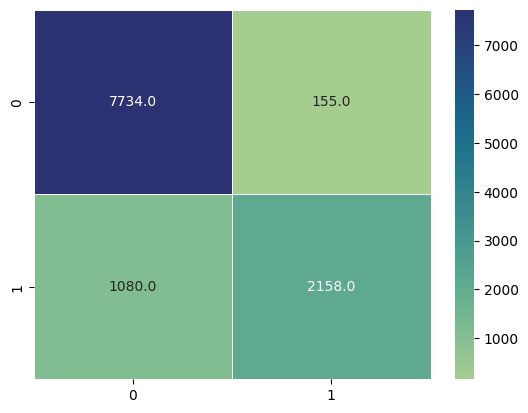

In [141]:
print(classification_report(y_test_rf, y_pred_rf, target_names = def_class_names) )

from sklearn.model_selection import cross_val_score
results = cross_val_score(random_forest_model, x_train_rf, y_train_rf, cv = 5, scoring = 'accuracy')
print("Acurácia em cada fold:", results)
print("Acurácia média: {:.2f}".format(results.mean()))
print("Desvio padrão: {:.4f}".format(results.std()))

def intervalo(results):
    mean = results.mean()
    dv = results.std()
    print('Acurácia média: {:.2f}%'.format(mean*100))
    print('Intervalo de acurácia: [{:.2f}% ~ {:.2f}%]'
           .format((mean - 2*dv)*100, (mean + 2*dv)*100))
intervalo(results)

cnf_matrix = confusion_matrix(y_test_rf, y_pred_rf)
cnf_table = pd.DataFrame(data=cnf_matrix)
sb.heatmap(data = cnf_table, annot=True, fmt=".1f", linewidth=.5, cmap="crest")

##XGBOOST

In [142]:
model_data_xg = dados_normalizados.copy(deep=True)
atributos = list(model_data_xg)[1:(model_data_xg.shape[1]-2)]
rotulos = list(model_data_xg)[0]

x = model_data_xg.iloc[:, 1:999]
y = model_data_xg.loc[:, 'Defeitos']

x_train, x_test, y_train, y_test = train_test_split(x_rf, y_rf, test_size=0.2, random_state=0) 

model = XGBClassifier(eval_metric='mlogloss', booster='dart')
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

print("Acuracia base treinamento: {:.2f}%".format(model.score(x_train, y_train)*100))
print("Acuracia base testes: {:.2f}%".format(model.score(x_test, y_test)*100))
print("R^2 Score: {:.3f};".format(r2_score(y_pred, y_test) ))

Acuracia base treinamento: 96.83%
Acuracia base testes: 94.19%
R^2 Score: 0.695;


              precision    recall  f1-score   support

Sem Defeitos       0.94      0.98      0.96      7889
Com Defeitos       0.95      0.84      0.89      3238

    accuracy                           0.94     11127
   macro avg       0.95      0.91      0.93     11127
weighted avg       0.94      0.94      0.94     11127

Acurácia em cada fold: [0.94225368 0.93877092 0.94034378 0.94180429 0.94595506]
Acurácia média: 0.94
Desvio padrão: 0.0024
Acurácia média: 94.18%
Intervalo de acurácia: [93.70% ~ 94.66%]


<Axes: >

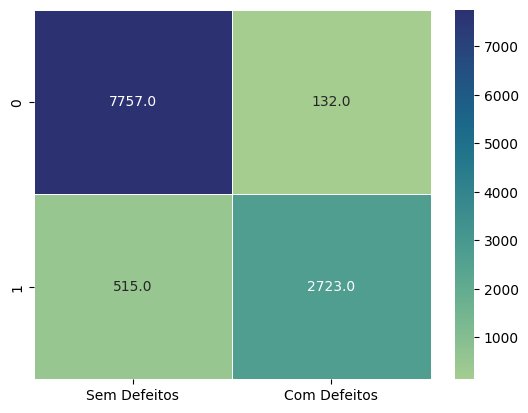

In [143]:
print(classification_report(y_test, y_pred, target_names = def_class_names) )

results = cross_val_score(model, x_train, y_train, cv = 5, scoring = 'accuracy')
print("Acurácia em cada fold:", results)
print("Acurácia média: {:.2f}".format(results.mean()))
print("Desvio padrão: {:.4f}".format(results.std()))

def intervalo(results):
    mean = results.mean()
    dv = results.std()
    print('Acurácia média: {:.2f}%'.format(mean*100))
    print('Intervalo de acurácia: [{:.2f}% ~ {:.2f}%]'
           .format((mean - 2*dv)*100, (mean + 2*dv)*100))
intervalo(results)

cnf_matrix = confusion_matrix(y_test, y_pred)
cnf_table = pd.DataFrame(data=cnf_matrix, columns = ['Sem Defeitos', 'Com Defeitos'] )
sb.heatmap(data = cnf_table, annot=True, fmt=".1f", linewidth=.5, cmap="crest")

##KNN

In [144]:
model_data_knn = dados_normalizados.copy(deep=True)
x = model_data_knn.iloc[:, 1:999]
y = model_data_knn.loc[:, 'Defeitos']

x_train, x_test, y_train, y_test = train_test_split(x_rf, y_rf, test_size=0.2, random_state=0) 
knn = KNeighborsClassifier(n_neighbors=2, algorithm='ball_tree', leaf_size=50)
knn.fit(x_train, y_train)

y_pred =knn.predict(x_test)

print("Acuracia base treinamento: {:.2f}%".format(model.score(x_train, y_train)*100))
print("Acuracia base testes: {:.2f}%".format(model.score(x_test, y_test)*100))
print("R^2 Score: {:.3f};".format(r2_score(y_pred, y_test) ))

Acuracia base treinamento: 96.83%
Acuracia base testes: 94.19%
R^2 Score: 0.542;


              precision    recall  f1-score   support

Sem Defeitos       0.89      0.98      0.93      7889
Com Defeitos       0.93      0.72      0.81      3238

    accuracy                           0.90     11127
   macro avg       0.91      0.85      0.87     11127
weighted avg       0.91      0.90      0.90     11127

Acurácia em cada fold: [0.94225368 0.93877092 0.94034378 0.94180429 0.94595506]
Acurácia média: 0.94
Desvio padrão: 0.0024
Acurácia média: 94.18%
Intervalo de acurácia: [93.70% ~ 94.66%]


<Axes: >

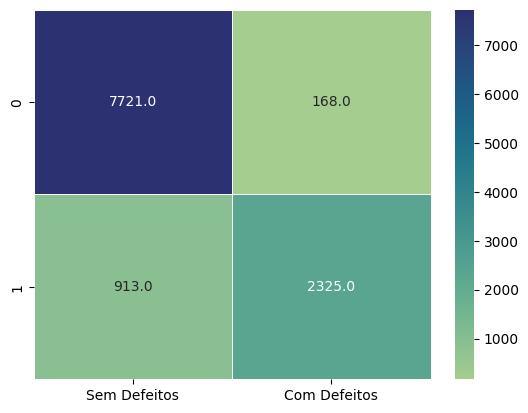

In [148]:
print(classification_report(y_test, y_pred, target_names = def_class_names) )

results = cross_val_score(model, x_train, y_train, cv = 5, scoring = 'accuracy')
print("Acurácia em cada fold:", results)
print("Acurácia média: {:.2f}".format(results.mean()))
print("Desvio padrão: {:.4f}".format(results.std()))

def intervalo(results):
    mean = results.mean()
    dv = results.std()
    print('Acurácia média: {:.2f}%'.format(mean*100))
    print('Intervalo de acurácia: [{:.2f}% ~ {:.2f}%]'.format((mean - 2*dv)*100, (mean + 2*dv)*100))
intervalo(results)

cnf_matrix = confusion_matrix(y_test, y_pred)
cnf_table = pd.DataFrame(data=cnf_matrix, columns = ['Sem Defeitos', 'Com Defeitos'] )
sb.heatmap(data = cnf_table, annot=True, fmt=".1f", linewidth=.5, cmap="crest")

##SVM

In [ ]:
model_data_SVM = dados_normalizados.copy(deep=True)
x = model_data_SVM.iloc[:, 1:999]
y = model_data_SVM.loc[:, 'Defeitos']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0) 

# Criar o modelo SVM
svm = SVC(kernel='poly', C=1.0, random_state=0)  # Usar kernel linear e parâmetro de regularização C=1.0

# Treinar o modelo SVM
svm.fit(x_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = svm.predict(x_test)

# Calcular a acurácia do modelo
print("Acuracia base treinamento: {:.2f}%".format(svm.score(x_train, y_train)*100))
print("Acuracia base testes: {:.2f}%".format(svm.score(x_test, y_test)*100))
print("R^2 Score: {:.3f};".format(r2_score(y_pred, y_test) ))


              precision    recall  f1-score   support

Sem Defeitos       0.89      0.98      0.93      7889
Com Defeitos       0.93      0.72      0.81      3238

    accuracy                           0.90     11127
   macro avg       0.91      0.85      0.87     11127
weighted avg       0.91      0.90      0.90     11127

Acurácia em cada fold: [0.94225368 0.93877092 0.94034378 0.94180429 0.94595506]
Acurácia média: 0.94
Desvio padrão: 0.0024
Acurácia média: 94.18%
Intervalo de acurácia: [93.70% ~ 94.66%]


<Axes: >

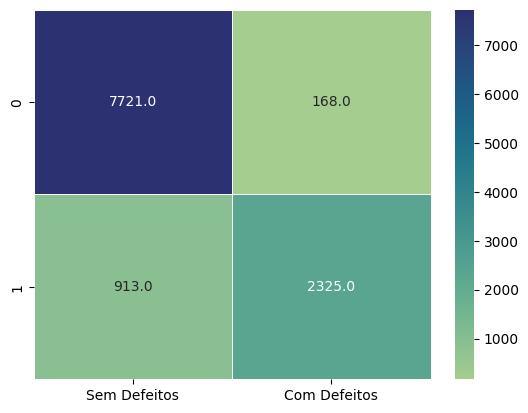

In [149]:
print(classification_report(y_test, y_pred, target_names = def_class_names) )

results = cross_val_score(model, x_train, y_train, cv = 5, scoring = 'accuracy')
print("Acurácia em cada fold:", results)
print("Acurácia média: {:.2f}".format(results.mean()))
print("Desvio padrão: {:.4f}".format(results.std()))

def intervalo(results):
    mean = results.mean()
    dv = results.std()
    print('Acurácia média: {:.2f}%'.format(mean*100))
    print('Intervalo de acurácia: [{:.2f}% ~ {:.2f}%]'.format((mean - 2*dv)*100, (mean + 2*dv)*100))
intervalo(results)

cnf_matrix = confusion_matrix(y_test, y_pred)
cnf_table = pd.DataFrame(data=cnf_matrix, columns = ['Sem Defeitos', 'Com Defeitos'] )
sb.heatmap(data = cnf_table, annot=True, fmt=".1f", linewidth=.5, cmap="crest")